## KAN RL

In [ ]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 51.5 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=f45b6078d1c7433acb72ad374903e461b1081ed42557a22b5c87ac6dfe2e9cea
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 31559247.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 932717.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7802215.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2050869.71it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(8)
Feedback shape: torch.Size([1, 8, 8])


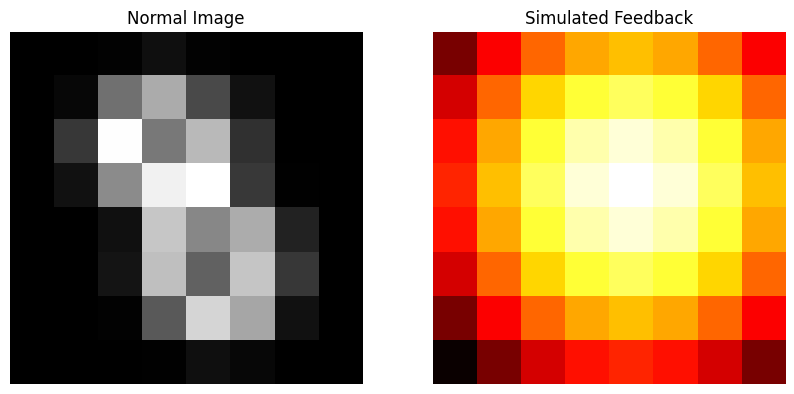

tensor(0.5273) tensor(1.)


In [ ]:
# @title

import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

class MNISTEnvironment:
    def __init__(self, batch_size, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        dataset = MNIST('./data', train=True, download=True, transform=self.transform)
        self.loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape))

        x, y = np.meshgrid(np.arange(image_np.shape[1]), np.arange(image_np.shape[0]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'jet' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = MNISTEnvironment(batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())

In [ ]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [ ]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-08-14 18:30:41.987689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 18:30:41.987884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 18:30:42.158120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())

          correct = 0
          total = 0
          with torch.no_grad():
              for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


In [ ]:

# config = {
#     "batch_size": 128,
#     "n_epochs": 5,
#     "gamma": 0.8,
#     "learning_rate": 1e-3, # 0.0005
#     "weight_decay": 1e-4,
#     "width": 8,
#     "grid": 3,
#     "method": "KAN",  # "MLP", "KAN"
#     "seed": 0,
#     "input_size": 8 * 8, # number of features
#     "output_size": 10, # number of classes
#     "buffer_size": 100000,
#     "target_update": 10,
#     "warm_up_episodes": 2,
#     "num_filters": 4,
#     "num_conv_layers": 2,
#     "first_channel": 1, # (1,8,8)
#     "hidden_dim": 128,
#     "feature_selection": True,
#     "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
#     "initial_tau": 1.0, # positive float value

# }

# q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

For grid size = 3, test accuracy =


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 1, 3, 5], input_shape=(1, 8, 8)):
#     # Determine the side length of the image
#     side_length = int(np.sqrt(probs_history[0].shape[1]))

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for i, epoch in enumerate(epochs):
#         ax = axes[i // 2, i % 2]
#         if epoch < len(probs_history):
#             probs = probs_history[epoch].flatten()
#             if side_length ** 2 != probs.shape[0]:
#                 continue
#             probs_image = probs.reshape((side_length, side_length))
#             cax = ax.matshow(probs_image, cmap='viridis')
#             fig.colorbar(cax, ax=ax)
#             ax.set_title(f'Probabilities at Epoch {epoch}')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Feedback Cost')
#     plt.title('Evolution of Feedback Cost (MSE)')
#     plt.legend()
#     plt.show()


# plot_evolution(probs_history, feedback_cost_history)


bernoulli - Final Train Accuracy: 0.89 ± 0.01\
bernoulli - Final Test Accuracy: 0.90 ± 0.00\
gumbel_softmax - Final Train Accuracy: 0.12 ± 0.01\
gumbel_softmax - Final Test Accuracy: 0.13 ± 0.01\
gaussian - Final Train Accuracy: 0.35 ± 0.02\
gaussian - Final Test Accuracy: 0.31 ± 0.01\
beta - Final Train Accuracy: 0.95 ± 0.01\
beta - Final Test Accuracy: 0.94 ± 0.00\
dirichlet - Final Train Accuracy: 0.21 ± 0.01\
dirichlet - Final Test Accuracy: 0.21 ± 0.00\
multinomial - Final Train Accuracy: 0.09 ± 0.01\
multinomial - Final Test Accuracy: 0.12 ± 0.01\
cauchy - Final Train Accuracy: 0.13 ± 0.02\
cauchy - Final Test Accuracy: 0.12 ± 0.01\
laplace - Final Train Accuracy: 0.28 ± 0.03\
laplace - Final Test Accuracy: 0.28 ± 0.01\
uniform - Final Train Accuracy: 0.94 ± 0.01\
uniform - Final Test Accuracy: 0.93 ± 0.00

# MLP

In [ ]:
!pip install torchview

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1723660269:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06011684574901676
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1723660269:   1%|          | 1/100 [00:05<08:41,  5.27s/it]

 Test accuracy:  0.2766

correct: 48 total: 469
loss: 0.07447904724873967
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1723660269:   2%|▏         | 2/100 [00:10<08:41,  5.33s/it]

 Test accuracy:  0.4113

correct: 193 total: 469
loss: 0.08375995087502862
 Train accuracy:  0.4115138592750533 | 


MLP_MNIST_0_1723660269:   3%|▎         | 3/100 [00:16<08:49,  5.46s/it]

 Test accuracy:  0.4832

correct: 236 total: 469
loss: 0.09378980055673798
 Train accuracy:  0.5031982942430704 | 


MLP_MNIST_0_1723660269:   4%|▍         | 4/100 [00:21<08:47,  5.49s/it]

 Test accuracy:  0.519

correct: 256 total: 469
loss: 0.09991097340642262
 Train accuracy:  0.5458422174840085 | 


MLP_MNIST_0_1723660269:   5%|▌         | 5/100 [00:27<08:45,  5.53s/it]

 Test accuracy:  0.5558

correct: 264 total: 469
loss: 0.1037590011382408
 Train accuracy:  0.5628997867803838 | 


MLP_MNIST_0_1723660269:   6%|▌         | 6/100 [00:33<08:42,  5.56s/it]

 Test accuracy:  0.5755

correct: 271 total: 469
loss: 0.10704797820877164
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723660269:   7%|▋         | 7/100 [00:39<09:08,  5.90s/it]

 Test accuracy:  0.5889

correct: 286 total: 469
loss: 0.10874874155912827
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1723660269:   8%|▊         | 8/100 [00:46<09:33,  6.23s/it]

 Test accuracy:  0.605

correct: 277 total: 469
loss: 0.1095868455988766
 Train accuracy:  0.5906183368869936 | 


MLP_MNIST_0_1723660269:   9%|▉         | 9/100 [00:52<09:26,  6.22s/it]

 Test accuracy:  0.6104

correct: 286 total: 469
loss: 0.11168012472548719
 Train accuracy:  0.6098081023454158 | 


MLP_MNIST_0_1723660269:  10%|█         | 10/100 [00:58<09:17,  6.19s/it]

 Test accuracy:  0.612

correct: 271 total: 469
loss: 0.11230597700645674
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1723660269:  11%|█         | 11/100 [01:05<09:09,  6.18s/it]

 Test accuracy:  0.634

correct: 293 total: 469
loss: 0.11322094018716039
 Train accuracy:  0.6247334754797441 | 


MLP_MNIST_0_1723660269:  12%|█▏        | 12/100 [01:11<08:59,  6.13s/it]

 Test accuracy:  0.6346

correct: 302 total: 469
loss: 0.11458934216039267
 Train accuracy:  0.6439232409381663 | 


MLP_MNIST_0_1723660269:  13%|█▎        | 13/100 [01:17<09:08,  6.30s/it]

 Test accuracy:  0.6385

correct: 317 total: 469
loss: 0.11507778201720861
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1723660269:  14%|█▍        | 14/100 [01:24<09:03,  6.32s/it]

 Test accuracy:  0.668

correct: 310 total: 469
loss: 0.11546330211132066
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1723660269:  15%|█▌        | 15/100 [01:30<08:52,  6.26s/it]

 Test accuracy:  0.6811

correct: 320 total: 469
loss: 0.1165033398406592
 Train accuracy:  0.6823027718550106 | 


MLP_MNIST_0_1723660269:  16%|█▌        | 16/100 [01:36<08:48,  6.29s/it]

 Test accuracy:  0.6755

correct: 322 total: 469
loss: 0.11619943243735381
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1723660269:  17%|█▋        | 17/100 [01:42<08:35,  6.21s/it]

 Test accuracy:  0.6815

correct: 329 total: 469
loss: 0.11682717282888985
 Train accuracy:  0.7014925373134329 | 


MLP_MNIST_0_1723660269:  18%|█▊        | 18/100 [01:48<08:26,  6.18s/it]

 Test accuracy:  0.6756

correct: 324 total: 469
loss: 0.11656997626079425
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1723660269:  19%|█▉        | 19/100 [01:54<08:20,  6.18s/it]

 Test accuracy:  0.6864

correct: 322 total: 469
loss: 0.1170125879299666
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1723660269:  20%|██        | 20/100 [02:00<08:11,  6.14s/it]

 Test accuracy:  0.6834

correct: 319 total: 469
loss: 0.11750138417553546
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1723660269:  21%|██        | 21/100 [02:07<08:10,  6.21s/it]

 Test accuracy:  0.689

correct: 331 total: 469
loss: 0.11786383968680653
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1723660269:  22%|██▏       | 22/100 [02:13<08:07,  6.25s/it]

 Test accuracy:  0.6915

correct: 319 total: 469
loss: 0.1179228644889555
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1723660269:  23%|██▎       | 23/100 [02:19<08:02,  6.27s/it]

 Test accuracy:  0.6881

correct: 316 total: 469
loss: 0.11847244843300472
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1723660269:  24%|██▍       | 24/100 [02:26<07:52,  6.22s/it]

 Test accuracy:  0.6918

correct: 325 total: 469
loss: 0.11818868325336147
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1723660269:  25%|██▌       | 25/100 [02:31<07:38,  6.12s/it]

 Test accuracy:  0.6873

correct: 330 total: 469
loss: 0.11827656407473183
 Train accuracy:  0.7036247334754797 | 


MLP_MNIST_0_1723660269:  26%|██▌       | 26/100 [02:37<07:26,  6.04s/it]

 Test accuracy:  0.6967

correct: 323 total: 469
loss: 0.11902969262239013
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1723660269:  27%|██▋       | 27/100 [02:43<07:20,  6.04s/it]

 Test accuracy:  0.6944

correct: 317 total: 469
loss: 0.11912053775812771
 Train accuracy:  0.67590618336887 | 


MLP_MNIST_0_1723660269:  28%|██▊       | 28/100 [02:49<07:13,  6.02s/it]

 Test accuracy:  0.6875

correct: 318 total: 469
loss: 0.11880273905707829
 Train accuracy:  0.6780383795309168 | 


MLP_MNIST_0_1723660269:  29%|██▉       | 29/100 [02:55<07:09,  6.05s/it]

 Test accuracy:  0.6959

correct: 334 total: 469
loss: 0.11917629809394828
 Train accuracy:  0.7121535181236673 | 


MLP_MNIST_0_1723660269:  30%|███       | 30/100 [03:02<07:05,  6.07s/it]

 Test accuracy:  0.6994

correct: 325 total: 469
loss: 0.11883820304230078
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1723660269:  31%|███       | 31/100 [03:08<07:00,  6.09s/it]

 Test accuracy:  0.6968

correct: 316 total: 469
loss: 0.11972315984367053
 Train accuracy:  0.673773987206823 | 


MLP_MNIST_0_1723660269:  32%|███▏      | 32/100 [03:14<06:54,  6.09s/it]

 Test accuracy:  0.7026

correct: 335 total: 469
loss: 0.11975427048165661
 Train accuracy:  0.7142857142857143 | 


MLP_MNIST_0_1723660269:  33%|███▎      | 33/100 [03:20<06:53,  6.16s/it]

 Test accuracy:  0.7021

correct: 339 total: 469
loss: 0.11987749002635606
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  34%|███▍      | 34/100 [03:27<06:52,  6.25s/it]

 Test accuracy:  0.6995

correct: 323 total: 469
loss: 0.12030179115500786
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1723660269:  35%|███▌      | 35/100 [03:33<06:46,  6.25s/it]

 Test accuracy:  0.702

correct: 324 total: 469
loss: 0.12000899601465603
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1723660269:  36%|███▌      | 36/100 [03:39<06:41,  6.27s/it]

 Test accuracy:  0.702

correct: 307 total: 469
loss: 0.12098457813580661
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1723660269:  37%|███▋      | 37/100 [03:46<06:42,  6.40s/it]

 Test accuracy:  0.6993

correct: 326 total: 469
loss: 0.1208101582012451
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1723660269:  38%|███▊      | 38/100 [03:52<06:38,  6.43s/it]

 Test accuracy:  0.6972

correct: 324 total: 469
loss: 0.12080787602009804
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1723660269:  39%|███▉      | 39/100 [03:59<06:33,  6.45s/it]

 Test accuracy:  0.7059

correct: 329 total: 469
loss: 0.12047338461888625
 Train accuracy:  0.7014925373134329 | 


MLP_MNIST_0_1723660269:  40%|████      | 40/100 [04:05<06:27,  6.46s/it]

 Test accuracy:  0.7088

correct: 333 total: 469
loss: 0.12039908906544196
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1723660269:  41%|████      | 41/100 [04:12<06:19,  6.43s/it]

 Test accuracy:  0.7069

correct: 339 total: 469
loss: 0.12067559736369769
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  42%|████▏     | 42/100 [04:18<06:14,  6.46s/it]

 Test accuracy:  0.7146

correct: 331 total: 469
loss: 0.12082753395602139
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1723660269:  43%|████▎     | 43/100 [04:25<06:08,  6.46s/it]

 Test accuracy:  0.7103

correct: 342 total: 469
loss: 0.12149910053718826
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1723660269:  44%|████▍     | 44/100 [04:31<05:55,  6.35s/it]

 Test accuracy:  0.7156

correct: 339 total: 469
loss: 0.1217349682853166
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  45%|████▌     | 45/100 [04:37<05:47,  6.32s/it]

 Test accuracy:  0.7126

correct: 320 total: 469
loss: 0.12181816078515957
 Train accuracy:  0.6823027718550106 | 


MLP_MNIST_0_1723660269:  46%|████▌     | 46/100 [04:43<05:38,  6.28s/it]

 Test accuracy:  0.7079

correct: 327 total: 469
loss: 0.12152885124563917
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1723660269:  47%|████▋     | 47/100 [04:49<05:31,  6.25s/it]

 Test accuracy:  0.7103

correct: 325 total: 469
loss: 0.12175090128043567
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1723660269:  48%|████▊     | 48/100 [04:56<05:25,  6.25s/it]

 Test accuracy:  0.7113

correct: 338 total: 469
loss: 0.12172202694454173
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1723660269:  49%|████▉     | 49/100 [05:02<05:20,  6.29s/it]

 Test accuracy:  0.717

correct: 321 total: 469
loss: 0.12209268030263722
 Train accuracy:  0.6844349680170576 | 


MLP_MNIST_0_1723660269:  50%|█████     | 50/100 [05:08<05:13,  6.27s/it]

 Test accuracy:  0.7097

correct: 333 total: 469
loss: 0.1218274844798452
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1723660269:  51%|█████     | 51/100 [05:14<05:06,  6.26s/it]

 Test accuracy:  0.7037

correct: 319 total: 469
loss: 0.12157639489372148
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1723660269:  52%|█████▏    | 52/100 [05:21<05:01,  6.27s/it]

 Test accuracy:  0.7128

correct: 312 total: 469
loss: 0.12194020979440034
 Train accuracy:  0.6652452025586354 | 


MLP_MNIST_0_1723660269:  53%|█████▎    | 53/100 [05:27<04:54,  6.27s/it]

 Test accuracy:  0.7151

correct: 335 total: 469
loss: 0.12185777752384194
 Train accuracy:  0.7142857142857143 | 


MLP_MNIST_0_1723660269:  54%|█████▍    | 54/100 [05:33<04:50,  6.32s/it]

 Test accuracy:  0.7147

correct: 314 total: 469
loss: 0.1221658895328355
 Train accuracy:  0.6695095948827292 | 


MLP_MNIST_0_1723660269:  55%|█████▌    | 55/100 [05:40<04:42,  6.29s/it]

 Test accuracy:  0.7112

correct: 337 total: 469
loss: 0.12191914141114586
 Train accuracy:  0.7185501066098081 | 


MLP_MNIST_0_1723660269:  56%|█████▌    | 56/100 [05:46<04:37,  6.30s/it]

 Test accuracy:  0.7184

correct: 324 total: 469
loss: 0.12184661164530304
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1723660269:  57%|█████▋    | 57/100 [05:52<04:30,  6.28s/it]

 Test accuracy:  0.7115

correct: 328 total: 469
loss: 0.12202463769264567
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1723660269:  58%|█████▊    | 58/100 [05:59<04:24,  6.30s/it]

 Test accuracy:  0.7113

correct: 342 total: 469
loss: 0.12189199991508333
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1723660269:  59%|█████▉    | 59/100 [06:05<04:22,  6.40s/it]

 Test accuracy:  0.7167

correct: 330 total: 469
loss: 0.12274640410947901
 Train accuracy:  0.7036247334754797 | 


MLP_MNIST_0_1723660269:  60%|██████    | 60/100 [06:12<04:14,  6.37s/it]

 Test accuracy:  0.7128

correct: 335 total: 469
loss: 0.1220241405530525
 Train accuracy:  0.7142857142857143 | 


MLP_MNIST_0_1723660269:  61%|██████    | 61/100 [06:18<04:07,  6.33s/it]

 Test accuracy:  0.7154

correct: 333 total: 469
loss: 0.12211912369994975
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1723660269:  62%|██████▏   | 62/100 [06:24<04:00,  6.32s/it]

 Test accuracy:  0.7144

correct: 328 total: 469
loss: 0.12276035973003932
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1723660269:  63%|██████▎   | 63/100 [06:30<03:53,  6.30s/it]

 Test accuracy:  0.7116

correct: 339 total: 469
loss: 0.1229782952015588
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  64%|██████▍   | 64/100 [06:37<03:52,  6.47s/it]

 Test accuracy:  0.7192

correct: 332 total: 469
loss: 0.12214419995543799
 Train accuracy:  0.7078891257995735 | 


MLP_MNIST_0_1723660269:  65%|██████▌   | 65/100 [06:43<03:44,  6.41s/it]

 Test accuracy:  0.7146

correct: 340 total: 469
loss: 0.12258017741477312
 Train accuracy:  0.7249466950959488 | 


MLP_MNIST_0_1723660269:  66%|██████▌   | 66/100 [06:50<03:36,  6.38s/it]

 Test accuracy:  0.7134

correct: 326 total: 469
loss: 0.12229149693301491
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1723660269:  67%|██████▋   | 67/100 [06:56<03:30,  6.37s/it]

 Test accuracy:  0.7092

correct: 335 total: 469
loss: 0.12243805584241586
 Train accuracy:  0.7142857142857143 | 


MLP_MNIST_0_1723660269:  68%|██████▊   | 68/100 [07:03<03:24,  6.38s/it]

 Test accuracy:  0.714

correct: 329 total: 469
loss: 0.12269033564687538
 Train accuracy:  0.7014925373134329 | 


MLP_MNIST_0_1723660269:  69%|██████▉   | 69/100 [07:09<03:21,  6.49s/it]

 Test accuracy:  0.7205

correct: 339 total: 469
loss: 0.1223086858513767
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  70%|███████   | 70/100 [07:16<03:14,  6.47s/it]

 Test accuracy:  0.7196

correct: 334 total: 469
loss: 0.12217698262126715
 Train accuracy:  0.7121535181236673 | 


MLP_MNIST_0_1723660269:  71%|███████   | 71/100 [07:22<03:07,  6.48s/it]

 Test accuracy:  0.7158

correct: 336 total: 469
loss: 0.1225140611690753
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1723660269:  72%|███████▏  | 72/100 [07:29<03:00,  6.45s/it]

 Test accuracy:  0.7118

correct: 324 total: 469
loss: 0.12224302380514551
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1723660269:  73%|███████▎  | 73/100 [07:35<02:53,  6.43s/it]

 Test accuracy:  0.7211

correct: 347 total: 469
loss: 0.12264865945015889
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1723660269:  74%|███████▍  | 74/100 [07:41<02:46,  6.40s/it]

 Test accuracy:  0.7156

correct: 318 total: 469
loss: 0.12260756611442769
 Train accuracy:  0.6780383795309168 | 


MLP_MNIST_0_1723660269:  75%|███████▌  | 75/100 [07:48<02:41,  6.46s/it]

 Test accuracy:  0.7238

correct: 323 total: 469
loss: 0.12304876512810112
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1723660269:  76%|███████▌  | 76/100 [07:54<02:32,  6.37s/it]

 Test accuracy:  0.7187

correct: 348 total: 469
loss: 0.12232295244233186
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1723660269:  77%|███████▋  | 77/100 [08:00<02:25,  6.32s/it]

 Test accuracy:  0.7141

correct: 336 total: 469
loss: 0.12220686038674068
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1723660269:  78%|███████▊  | 78/100 [08:07<02:18,  6.31s/it]

 Test accuracy:  0.7167

correct: 310 total: 469
loss: 0.12285796622795336
 Train accuracy:  0.6609808102345416 | 


MLP_MNIST_0_1723660269:  79%|███████▉  | 79/100 [08:13<02:12,  6.31s/it]

 Test accuracy:  0.7199

correct: 353 total: 469
loss: 0.12296614505207615
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1723660269:  80%|████████  | 80/100 [08:19<02:05,  6.27s/it]

 Test accuracy:  0.7212

correct: 338 total: 469
loss: 0.12226966919421133
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1723660269:  81%|████████  | 81/100 [08:25<01:59,  6.30s/it]

 Test accuracy:  0.7221

correct: 349 total: 469
loss: 0.12325410976974187
 Train accuracy:  0.744136460554371 | 


MLP_MNIST_0_1723660269:  82%|████████▏ | 82/100 [08:32<01:53,  6.30s/it]

 Test accuracy:  0.7187

correct: 339 total: 469
loss: 0.12273539231021775
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1723660269:  83%|████████▎ | 83/100 [08:38<01:49,  6.41s/it]

 Test accuracy:  0.7211

correct: 327 total: 469
loss: 0.12256407415244117
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1723660269:  84%|████████▍ | 84/100 [08:45<01:43,  6.45s/it]

 Test accuracy:  0.7228

correct: 330 total: 469
loss: 0.12341538769032147
 Train accuracy:  0.7036247334754797 | 


MLP_MNIST_0_1723660269:  85%|████████▌ | 85/100 [08:51<01:37,  6.48s/it]

 Test accuracy:  0.7253

correct: 349 total: 469
loss: 0.12218979537995385
 Train accuracy:  0.744136460554371 | 


MLP_MNIST_0_1723660269:  86%|████████▌ | 86/100 [08:58<01:30,  6.43s/it]

 Test accuracy:  0.725

correct: 331 total: 469
loss: 0.12272915661906891
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1723660269:  87%|████████▋ | 87/100 [09:04<01:24,  6.49s/it]

 Test accuracy:  0.7283

correct: 319 total: 469
loss: 0.12193032295337872
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1723660269:  88%|████████▊ | 88/100 [09:11<01:18,  6.58s/it]

 Test accuracy:  0.7214

correct: 327 total: 469
loss: 0.12270647404925909
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1723660269:  89%|████████▉ | 89/100 [09:18<01:12,  6.60s/it]

 Test accuracy:  0.7233

correct: 340 total: 469
loss: 0.1226920140291582
 Train accuracy:  0.7249466950959488 | 


MLP_MNIST_0_1723660269:  90%|█████████ | 90/100 [09:25<01:06,  6.65s/it]

 Test accuracy:  0.7252

correct: 329 total: 469
loss: 0.12324669849135474
 Train accuracy:  0.7014925373134329 | 


MLP_MNIST_0_1723660269:  91%|█████████ | 91/100 [09:31<01:00,  6.68s/it]

 Test accuracy:  0.7199

correct: 333 total: 469
loss: 0.12315176490908747
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1723660269:  92%|█████████▏| 92/100 [09:38<00:53,  6.74s/it]

 Test accuracy:  0.72

correct: 333 total: 469
loss: 0.12257983665794198
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1723660269:  93%|█████████▎| 93/100 [09:45<00:47,  6.85s/it]

 Test accuracy:  0.718

correct: 336 total: 469
loss: 0.12314034056371209
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1723660269:  94%|█████████▍| 94/100 [09:52<00:41,  6.86s/it]

 Test accuracy:  0.722

correct: 327 total: 469
loss: 0.1227565451280903
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1723660269:  95%|█████████▌| 95/100 [09:59<00:34,  6.85s/it]

 Test accuracy:  0.7198

correct: 313 total: 469
loss: 0.12285205985564412
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1723660269:  96%|█████████▌| 96/100 [10:06<00:27,  6.77s/it]

 Test accuracy:  0.727

correct: 346 total: 469
loss: 0.12296601124346129
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1723660269:  97%|█████████▋| 97/100 [10:12<00:20,  6.72s/it]

 Test accuracy:  0.724

correct: 323 total: 469
loss: 0.12343071882468043
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1723660269:  98%|█████████▊| 98/100 [10:19<00:13,  6.70s/it]

 Test accuracy:  0.7178

correct: 331 total: 469
loss: 0.12268671447407208
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1723660269:  99%|█████████▉| 99/100 [10:25<00:06,  6.65s/it]

 Test accuracy:  0.7249

correct: 350 total: 469
loss: 0.1234255497739005
 Train accuracy:  0.746268656716418 | 


MLP_MNIST_0_1723660269: 100%|██████████| 100/100 [10:32<00:00,  6.32s/it]

 Test accuracy:  0.7216


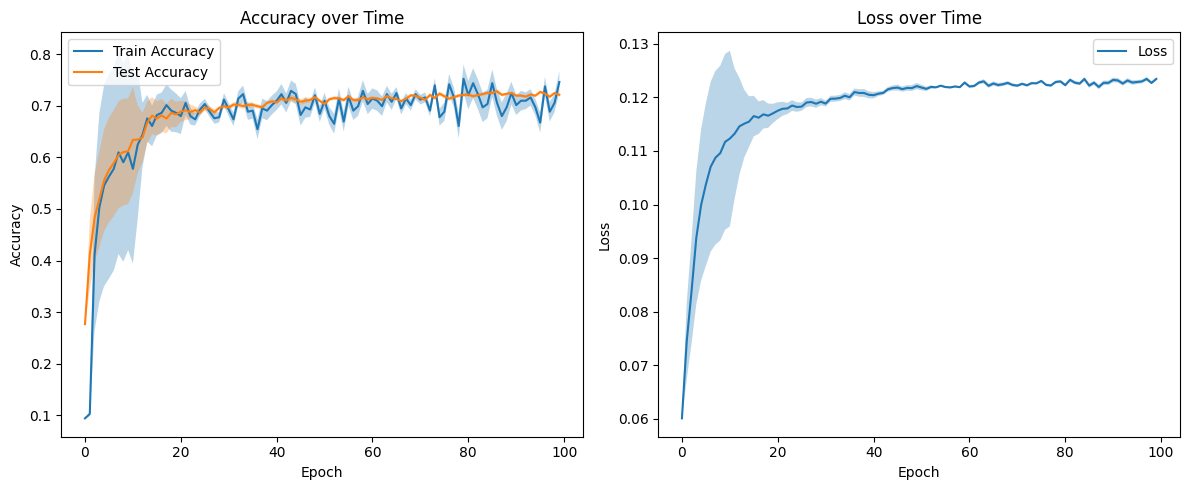

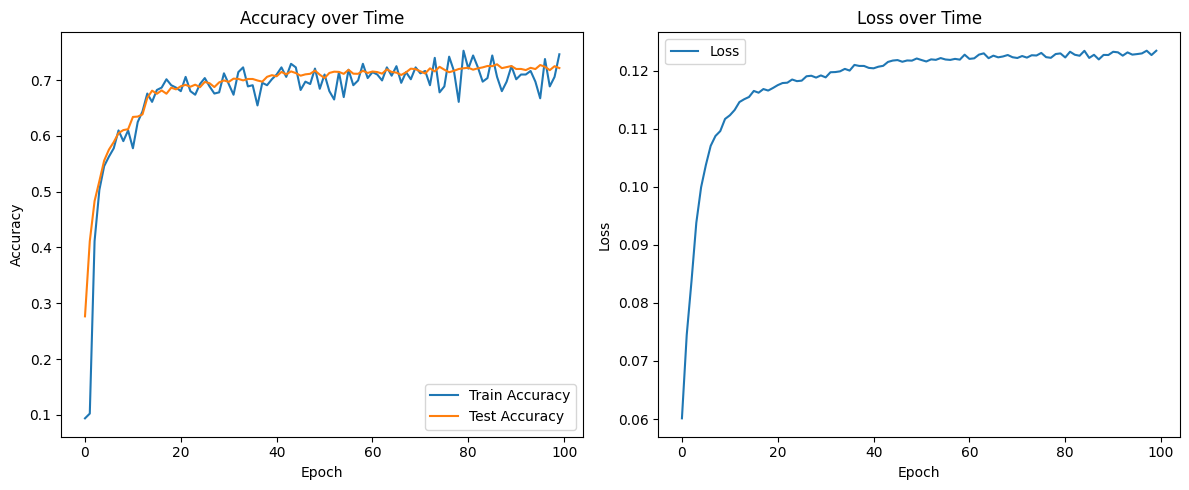

Final Train Accuracy: 0.75 ± 0.02
Final Test Accuracy: 0.72 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # "bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

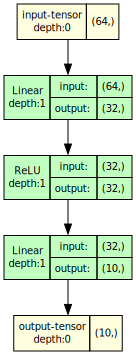

In [ ]:
## MLP architecture
import torchvision
from torchview import draw_graph

model_graph = draw_graph(q_network, input_size=(8 * 8,), expand_nested=True)
model_graph.visual_graph

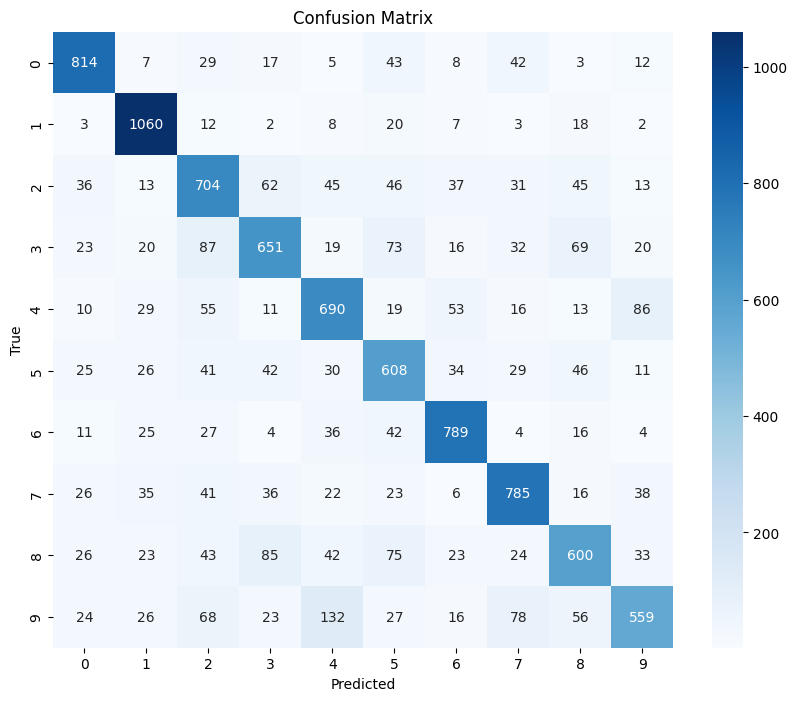

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
    for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       980
           1       0.84      0.93      0.88      1135
           2       0.64      0.68      0.66      1032
           3       0.70      0.64      0.67      1010
           4       0.67      0.70      0.69       982
           5       0.62      0.68      0.65       892
           6       0.80      0.82      0.81       958
           7       0.75      0.76      0.76      1028
           8       0.68      0.62      0.65       974
           9       0.72      0.55      0.63      1009

    accuracy                           0.73     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.73      0.73      0.72     10000



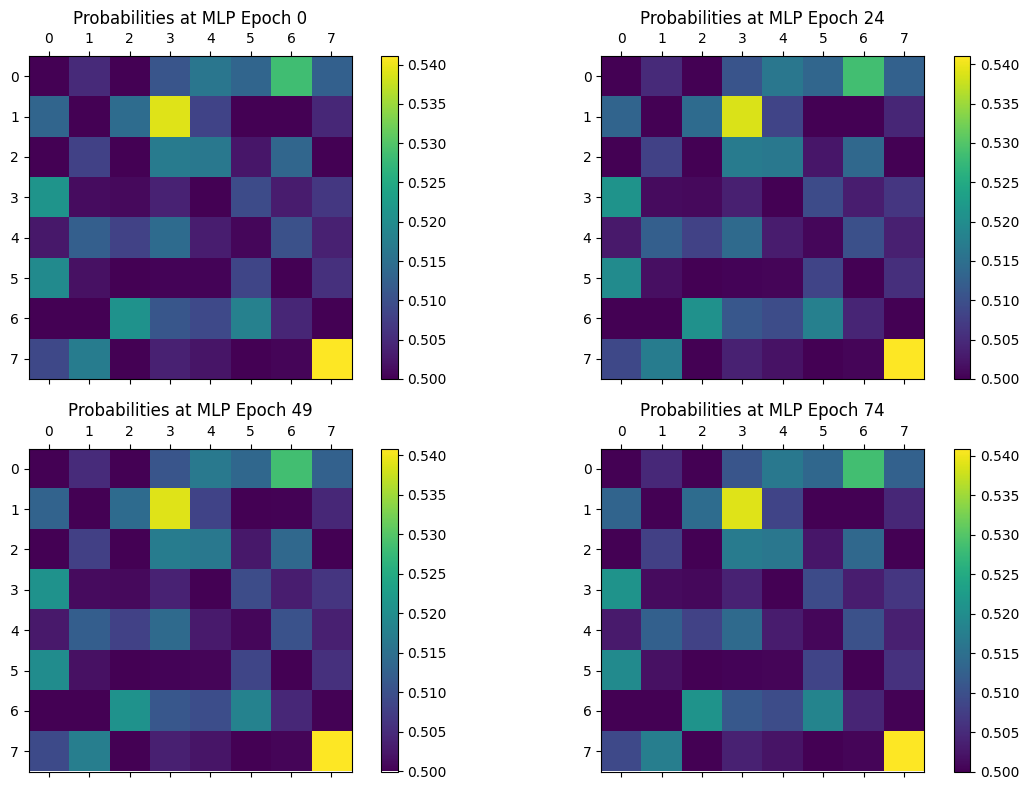

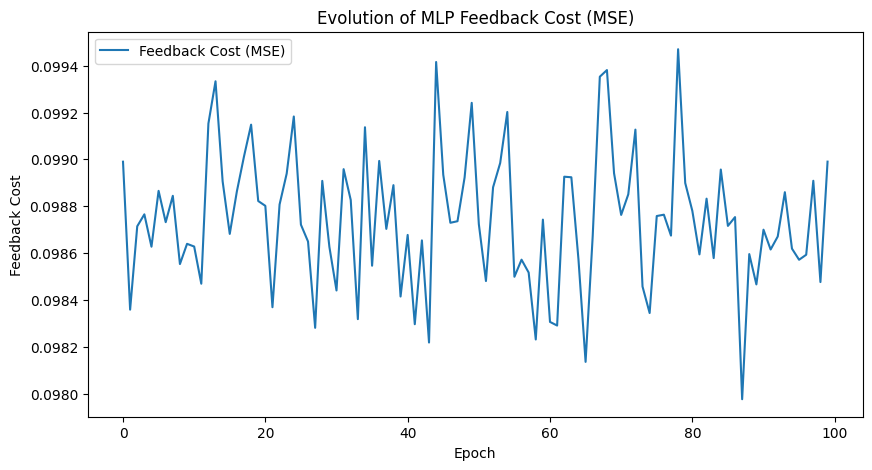

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at MLP Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of MLP Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


In [ ]:
import gc
gc.collect()

29938

# KAN

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


KAN_MNIST_0_1723660915:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06415963952920076
 Train accuracy:  0.09381663113006397 | 


KAN_MNIST_0_1723660915:   1%|          | 1/100 [02:15<3:43:08, 135.24s/it]

 Test accuracy:  0.1774

correct: 48 total: 469
loss: 0.06158933326252488
 Train accuracy:  0.1023454157782516 | 


KAN_MNIST_0_1723660915:   2%|▏         | 2/100 [05:19<4:28:06, 164.15s/it]

 Test accuracy:  0.2917

correct: 139 total: 469
loss: 0.06054254401244843
 Train accuracy:  0.29637526652452023 | 


KAN_MNIST_0_1723660915:   3%|▎         | 3/100 [08:43<4:54:53, 182.41s/it]

 Test accuracy:  0.3535

correct: 162 total: 469
loss: 0.0655695695374439
 Train accuracy:  0.34541577825159914 | 


KAN_MNIST_0_1723660915:   4%|▍         | 4/100 [12:13<5:08:53, 193.06s/it]

 Test accuracy:  0.3558

correct: 166 total: 469
loss: 0.069630371744254
 Train accuracy:  0.35394456289978676 | 


KAN_MNIST_0_1723660915:   5%|▌         | 5/100 [15:37<5:12:09, 197.15s/it]

 Test accuracy:  0.378

correct: 186 total: 469
loss: 0.07260780305718817
 Train accuracy:  0.39658848614072495 | 


KAN_MNIST_0_1723660915:   6%|▌         | 6/100 [19:02<5:13:12, 199.92s/it]

 Test accuracy:  0.3926

correct: 209 total: 469
loss: 0.07553414433304943
 Train accuracy:  0.44562899786780386 | 


KAN_MNIST_0_1723660915:   7%|▋         | 7/100 [22:27<5:12:19, 201.50s/it]

 Test accuracy:  0.4062

correct: 182 total: 469
loss: 0.07838782984247086
 Train accuracy:  0.3880597014925373 | 


KAN_MNIST_0_1723660915:   8%|▊         | 8/100 [25:53<5:11:14, 202.98s/it]

 Test accuracy:  0.4254

correct: 198 total: 469
loss: 0.07957492118228728
 Train accuracy:  0.42217484008528783 | 


KAN_MNIST_0_1723660915:   9%|▉         | 9/100 [29:19<5:09:10, 203.85s/it]

 Test accuracy:  0.4383

correct: 200 total: 469
loss: 0.08234701593960526
 Train accuracy:  0.42643923240938164 | 


KAN_MNIST_0_1723660915:  10%|█         | 10/100 [32:44<5:06:04, 204.06s/it]

 Test accuracy:  0.4448

correct: 196 total: 469
loss: 0.08522043880750375
 Train accuracy:  0.417910447761194 | 


KAN_MNIST_0_1723660915:  11%|█         | 11/100 [36:08<5:02:45, 204.10s/it]

 Test accuracy:  0.4658

correct: 216 total: 469
loss: 0.08704369087844516
 Train accuracy:  0.4605543710021322 | 


KAN_MNIST_0_1723660915:  12%|█▏        | 12/100 [39:33<4:59:40, 204.32s/it]

 Test accuracy:  0.4769

correct: 226 total: 469
loss: 0.08913722337245433
 Train accuracy:  0.48187633262260127 | 


KAN_MNIST_0_1723660915:  13%|█▎        | 13/100 [42:58<4:56:46, 204.67s/it]

 Test accuracy:  0.4836

correct: 222 total: 469
loss: 0.09119516347389994
 Train accuracy:  0.47334754797441364 | 


KAN_MNIST_0_1723660915:  14%|█▍        | 14/100 [46:25<4:54:12, 205.26s/it]

 Test accuracy:  0.5063

correct: 240 total: 469
loss: 0.0919648912637981
 Train accuracy:  0.511727078891258 | 


KAN_MNIST_0_1723660915:  15%|█▌        | 15/100 [49:51<4:51:18, 205.63s/it]

 Test accuracy:  0.517

correct: 250 total: 469
loss: 0.09272194520306232
 Train accuracy:  0.5330490405117271 | 


KAN_MNIST_0_1723660915:  16%|█▌        | 16/100 [53:16<4:47:39, 205.47s/it]

 Test accuracy:  0.5286

correct: 263 total: 469
loss: 0.09362581246760862
 Train accuracy:  0.5607675906183369 | 


KAN_MNIST_0_1723660915:  17%|█▋        | 17/100 [56:45<4:45:29, 206.38s/it]

 Test accuracy:  0.5325

correct: 234 total: 469
loss: 0.09456564171481997
 Train accuracy:  0.4989339019189765 | 


KAN_MNIST_0_1723660915:  18%|█▊        | 18/100 [1:00:14<4:43:09, 207.19s/it]

 Test accuracy:  0.5522

correct: 238 total: 469
loss: 0.09502650030068498
 Train accuracy:  0.5074626865671642 | 


KAN_MNIST_0_1723660915:  19%|█▉        | 19/100 [1:03:41<4:39:54, 207.33s/it]

 Test accuracy:  0.5633

correct: 263 total: 469
loss: 0.09475633627506716
 Train accuracy:  0.5607675906183369 | 


KAN_MNIST_0_1723660915:  20%|██        | 20/100 [1:07:09<4:36:30, 207.38s/it]

 Test accuracy:  0.5691

correct: 272 total: 469
loss: 0.09563861199533508
 Train accuracy:  0.579957356076759 | 


KAN_MNIST_0_1723660915:  21%|██        | 21/100 [1:10:34<4:32:18, 206.81s/it]

 Test accuracy:  0.5714

correct: 255 total: 469
loss: 0.09628464619932907
 Train accuracy:  0.5437100213219617 | 


KAN_MNIST_0_1723660915:  22%|██▏       | 22/100 [1:14:01<4:28:44, 206.73s/it]

 Test accuracy:  0.5675

correct: 279 total: 469
loss: 0.09682462871201765
 Train accuracy:  0.5948827292110874 | 


KAN_MNIST_0_1723660915:  23%|██▎       | 23/100 [1:17:27<4:24:55, 206.43s/it]

 Test accuracy:  0.5847

correct: 274 total: 469
loss: 0.09708414561967098
 Train accuracy:  0.5842217484008528 | 


KAN_MNIST_0_1723660915:  24%|██▍       | 24/100 [1:20:54<4:21:55, 206.78s/it]

 Test accuracy:  0.5986

correct: 295 total: 469
loss: 0.09817765001803319
 Train accuracy:  0.6289978678038379 | 


KAN_MNIST_0_1723660915:  25%|██▌       | 25/100 [1:24:25<4:19:57, 207.96s/it]

 Test accuracy:  0.5961

correct: 287 total: 469
loss: 0.09792727676790151
 Train accuracy:  0.6119402985074627 | 


KAN_MNIST_0_1723660915:  26%|██▌       | 26/100 [1:28:25<4:28:25, 217.64s/it]

 Test accuracy:  0.627

correct: 285 total: 469
loss: 0.10538241289444823
 Train accuracy:  0.6076759061833689 | 


KAN_MNIST_0_1723660915:  27%|██▋       | 27/100 [1:31:54<4:21:35, 215.00s/it]

 Test accuracy:  0.646

correct: 314 total: 469
loss: 0.10385461169074593
 Train accuracy:  0.6695095948827292 | 


KAN_MNIST_0_1723660915:  28%|██▊       | 28/100 [1:35:22<4:15:33, 212.96s/it]

 Test accuracy:  0.6582

correct: 313 total: 469
loss: 0.1044679802935769
 Train accuracy:  0.6673773987206824 | 


KAN_MNIST_0_1723660915:  29%|██▉       | 29/100 [1:38:51<4:10:35, 211.76s/it]

 Test accuracy:  0.6594

correct: 324 total: 469
loss: 0.10397476458282613
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1723660915:  30%|███       | 30/100 [1:42:20<4:05:59, 210.84s/it]

 Test accuracy:  0.6584

correct: 312 total: 469
loss: 0.10360641841059809
 Train accuracy:  0.6652452025586354 | 


KAN_MNIST_0_1723660915:  31%|███       | 31/100 [1:45:51<4:02:28, 210.85s/it]

 Test accuracy:  0.6751

correct: 303 total: 469
loss: 0.10398787647676366
 Train accuracy:  0.6460554371002132 | 


KAN_MNIST_0_1723660915:  32%|███▏      | 32/100 [1:49:24<3:59:52, 211.66s/it]

 Test accuracy:  0.6655

correct: 322 total: 469
loss: 0.10386900314644201
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1723660915:  33%|███▎      | 33/100 [1:53:00<3:57:46, 212.93s/it]

 Test accuracy:  0.6695

correct: 325 total: 469
loss: 0.10424324406235456
 Train accuracy:  0.6929637526652452 | 


KAN_MNIST_0_1723660915:  34%|███▍      | 34/100 [1:56:35<3:54:41, 213.35s/it]

 Test accuracy:  0.6752

correct: 314 total: 469
loss: 0.10437246278595569
 Train accuracy:  0.6695095948827292 | 


KAN_MNIST_0_1723660915:  35%|███▌      | 35/100 [2:00:04<3:49:41, 212.02s/it]

 Test accuracy:  0.6827

correct: 320 total: 469
loss: 0.10432109697414105
 Train accuracy:  0.6823027718550106 | 


KAN_MNIST_0_1723660915:  36%|███▌      | 36/100 [2:03:33<3:45:26, 211.34s/it]

 Test accuracy:  0.6794

correct: 306 total: 469
loss: 0.10558950588075337
 Train accuracy:  0.652452025586354 | 


KAN_MNIST_0_1723660915:  37%|███▋      | 37/100 [2:07:07<3:42:39, 212.06s/it]

 Test accuracy:  0.6899

correct: 335 total: 469
loss: 0.10567993605568973
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723660915:  38%|███▊      | 38/100 [2:10:47<3:41:35, 214.44s/it]

 Test accuracy:  0.6691

correct: 309 total: 469
loss: 0.1054399236083539
 Train accuracy:  0.6588486140724946 | 


KAN_MNIST_0_1723660915:  39%|███▉      | 39/100 [2:14:20<3:37:28, 213.91s/it]

 Test accuracy:  0.6918

correct: 324 total: 469
loss: 0.10581691594901624
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1723660915:  40%|████      | 40/100 [2:17:50<3:32:45, 212.76s/it]

 Test accuracy:  0.6913

correct: 330 total: 469
loss: 0.10585966739636749
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1723660915:  41%|████      | 41/100 [2:21:21<3:28:47, 212.33s/it]

 Test accuracy:  0.6968

correct: 340 total: 469
loss: 0.10593650853837222
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1723660915:  42%|████▏     | 42/100 [2:24:53<3:25:14, 212.32s/it]

 Test accuracy:  0.7036

correct: 338 total: 469
loss: 0.10647007902420914
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1723660915:  43%|████▎     | 43/100 [2:28:30<3:22:48, 213.48s/it]

 Test accuracy:  0.6921

correct: 340 total: 469
loss: 0.1069310785992059
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1723660915:  44%|████▍     | 44/100 [2:32:03<3:19:11, 213.42s/it]

 Test accuracy:  0.705

correct: 342 total: 469
loss: 0.1077321173984613
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1723660915:  45%|████▌     | 45/100 [2:35:37<3:15:50, 213.65s/it]

 Test accuracy:  0.7018

correct: 324 total: 469
loss: 0.10690877842369365
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1723660915:  46%|████▌     | 46/100 [2:39:08<3:11:26, 212.71s/it]

 Test accuracy:  0.7025

correct: 332 total: 469
loss: 0.10710501443666182
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1723660915:  47%|████▋     | 47/100 [2:42:38<3:07:11, 211.91s/it]

 Test accuracy:  0.7002

correct: 327 total: 469
loss: 0.10678496566027212
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1723660915:  48%|████▊     | 48/100 [2:46:08<3:03:12, 211.39s/it]

 Test accuracy:  0.7152

correct: 335 total: 469
loss: 0.10776875055293793
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723660915:  49%|████▉     | 49/100 [2:49:43<3:00:44, 212.64s/it]

 Test accuracy:  0.7209

correct: 330 total: 469
loss: 0.10796758874075245
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1723660915:  50%|█████     | 50/100 [2:53:18<2:57:49, 213.38s/it]

 Test accuracy:  0.7094

correct: 327 total: 469
loss: 0.10783922295771174
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1723660915:  51%|█████     | 51/100 [2:56:54<2:54:51, 214.11s/it]

 Test accuracy:  0.7103

correct: 317 total: 469
loss: 0.10782811385609194
 Train accuracy:  0.67590618336887 | 


KAN_MNIST_0_1723660915:  52%|█████▏    | 52/100 [3:00:28<2:51:14, 214.06s/it]

 Test accuracy:  0.7101

correct: 334 total: 469
loss: 0.10811575681670134
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723660915:  53%|█████▎    | 53/100 [3:04:02<2:47:32, 213.89s/it]

 Test accuracy:  0.7197

correct: 347 total: 469
loss: 0.10860390768948394
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1723660915:  54%|█████▍    | 54/100 [3:07:36<2:44:08, 214.09s/it]

 Test accuracy:  0.7093

correct: 307 total: 469
loss: 0.1086857729374981
 Train accuracy:  0.6545842217484008 | 


KAN_MNIST_0_1723660915:  55%|█████▌    | 55/100 [3:11:10<2:40:30, 214.02s/it]

 Test accuracy:  0.712

correct: 343 total: 469
loss: 0.10838701944551997
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1723660915:  56%|█████▌    | 56/100 [3:14:41<2:36:19, 213.17s/it]

 Test accuracy:  0.7211

correct: 316 total: 469
loss: 0.10890867729494566
 Train accuracy:  0.673773987206823 | 


KAN_MNIST_0_1723660915:  57%|█████▋    | 57/100 [3:18:12<2:32:17, 212.51s/it]

 Test accuracy:  0.7157

correct: 339 total: 469
loss: 0.10887847578665341
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1723660915:  58%|█████▊    | 58/100 [3:21:44<2:28:38, 212.36s/it]

 Test accuracy:  0.7101

correct: 332 total: 469
loss: 0.10944470115053628
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1723660915:  59%|█████▉    | 59/100 [3:25:17<2:25:14, 212.55s/it]

 Test accuracy:  0.7214

correct: 336 total: 469
loss: 0.11003163744455208
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1723660915:  60%|██████    | 60/100 [3:28:49<2:21:33, 212.33s/it]

 Test accuracy:  0.7215

correct: 332 total: 469
loss: 0.1101611362241987
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1723660915:  61%|██████    | 61/100 [3:32:19<2:17:31, 211.58s/it]

 Test accuracy:  0.7109

correct: 331 total: 469
loss: 0.10977142021409485
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1723660915:  62%|██████▏   | 62/100 [3:35:51<2:14:00, 211.59s/it]

 Test accuracy:  0.7135

correct: 335 total: 469
loss: 0.10942754630785761
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723660915:  63%|██████▎   | 63/100 [3:39:23<2:10:37, 211.82s/it]

 Test accuracy:  0.7167

correct: 340 total: 469
loss: 0.11048508004974454
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1723660915:  64%|██████▍   | 64/100 [3:42:55<2:07:13, 212.05s/it]

 Test accuracy:  0.717

correct: 338 total: 469
loss: 0.1102453411451535
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1723660915:  65%|██████▌   | 65/100 [3:46:28<2:03:42, 212.08s/it]

 Test accuracy:  0.7135

correct: 313 total: 469
loss: 0.11013940742402188
 Train accuracy:  0.6673773987206824 | 


KAN_MNIST_0_1723660915:  66%|██████▌   | 66/100 [3:50:09<2:01:40, 214.73s/it]

 Test accuracy:  0.7241

correct: 329 total: 469
loss: 0.1099285670816263
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1723660915:  67%|██████▋   | 67/100 [3:53:44<1:58:14, 214.99s/it]

 Test accuracy:  0.7201

correct: 329 total: 469
loss: 0.11023505716753412
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1723660915:  68%|██████▊   | 68/100 [3:57:16<1:54:10, 214.09s/it]

 Test accuracy:  0.7114

correct: 338 total: 469
loss: 0.11053045297355286
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1723660915:  69%|██████▉   | 69/100 [4:00:48<1:50:18, 213.50s/it]

 Test accuracy:  0.7271

correct: 343 total: 469
loss: 0.10972838966386404
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1723660915:  70%|███████   | 70/100 [4:04:21<1:46:34, 213.14s/it]

 Test accuracy:  0.7246

correct: 338 total: 469
loss: 0.11038962322702287
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1723660915:  71%|███████   | 71/100 [4:07:51<1:42:41, 212.47s/it]

 Test accuracy:  0.7212

correct: 355 total: 469
loss: 0.11085484091089225
 Train accuracy:  0.7569296375266524 | 


KAN_MNIST_0_1723660915:  72%|███████▏  | 72/100 [4:11:22<1:38:55, 211.99s/it]

 Test accuracy:  0.7181

correct: 337 total: 469
loss: 0.11047279049974007
 Train accuracy:  0.7185501066098081 | 


KAN_MNIST_0_1723660915:  73%|███████▎  | 73/100 [4:14:54<1:35:21, 211.90s/it]

 Test accuracy:  0.7299

correct: 351 total: 469
loss: 0.11098354373341685
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1723660915:  74%|███████▍  | 74/100 [4:18:24<1:31:32, 211.24s/it]

 Test accuracy:  0.723

correct: 335 total: 469
loss: 0.11135525275458659
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723660915:  75%|███████▌  | 75/100 [4:21:55<1:28:03, 211.33s/it]

 Test accuracy:  0.7278

correct: 337 total: 469
loss: 0.11136297335121423
 Train accuracy:  0.7185501066098081 | 


KAN_MNIST_0_1723660915:  76%|███████▌  | 76/100 [4:25:30<1:24:57, 212.40s/it]

 Test accuracy:  0.7303

correct: 337 total: 469
loss: 0.11131378704868654
 Train accuracy:  0.7185501066098081 | 


KAN_MNIST_0_1723660915:  77%|███████▋  | 77/100 [4:29:01<1:21:12, 211.85s/it]

 Test accuracy:  0.7313

correct: 350 total: 469
loss: 0.11101096078975876
 Train accuracy:  0.746268656716418 | 


KAN_MNIST_0_1723660915:  78%|███████▊  | 78/100 [4:32:31<1:17:30, 211.40s/it]

 Test accuracy:  0.7216

correct: 343 total: 469
loss: 0.11109843812009165
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1723660915:  79%|███████▉  | 79/100 [4:36:04<1:14:09, 211.87s/it]

 Test accuracy:  0.7237

correct: 339 total: 469
loss: 0.11138332732069467
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1723660915:  80%|████████  | 80/100 [4:39:34<1:10:28, 211.43s/it]

 Test accuracy:  0.7358

correct: 342 total: 469
loss: 0.11148285698979649
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1723660915:  81%|████████  | 81/100 [4:43:07<1:07:05, 211.86s/it]

 Test accuracy:  0.733

correct: 322 total: 469
loss: 0.11224519080126971
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1723660915:  82%|████████▏ | 82/100 [4:46:40<1:03:36, 212.00s/it]

 Test accuracy:  0.733

correct: 323 total: 469
loss: 0.1115821798218847
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1723660915:  83%|████████▎ | 83/100 [4:50:11<59:59, 211.73s/it]  

 Test accuracy:  0.7277

correct: 344 total: 469
loss: 0.11125929987252649
 Train accuracy:  0.7334754797441365 | 


KAN_MNIST_0_1723660915:  84%|████████▍ | 84/100 [4:53:40<56:17, 211.09s/it]

 Test accuracy:  0.7275

correct: 354 total: 469
loss: 0.11149156818003543
 Train accuracy:  0.7547974413646056 | 


KAN_MNIST_0_1723660915:  85%|████████▌ | 85/100 [4:57:12<52:48, 211.22s/it]

 Test accuracy:  0.7301

correct: 325 total: 469
loss: 0.11120415316906565
 Train accuracy:  0.6929637526652452 | 


KAN_MNIST_0_1723660915:  86%|████████▌ | 86/100 [5:00:45<49:26, 211.92s/it]

 Test accuracy:  0.7343

correct: 334 total: 469
loss: 0.11205014445062385
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723660915:  87%|████████▋ | 87/100 [5:04:17<45:54, 211.89s/it]

 Test accuracy:  0.7329

correct: 343 total: 469
loss: 0.11229613650518694
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1723660915:  88%|████████▊ | 88/100 [5:07:51<42:29, 212.49s/it]

 Test accuracy:  0.7276

correct: 334 total: 469
loss: 0.11279798666043069
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723660915:  89%|████████▉ | 89/100 [5:11:24<38:59, 212.69s/it]

 Test accuracy:  0.7353

correct: 349 total: 469
loss: 0.11226743945816178
 Train accuracy:  0.744136460554371 | 


KAN_MNIST_0_1723660915:  90%|█████████ | 90/100 [5:14:56<35:24, 212.44s/it]

 Test accuracy:  0.7276

correct: 345 total: 469
loss: 0.11225402064478474
 Train accuracy:  0.7356076759061834 | 


KAN_MNIST_0_1723660915:  91%|█████████ | 91/100 [5:18:27<31:47, 211.89s/it]

 Test accuracy:  0.7213

correct: 342 total: 469
loss: 0.1122534534474934
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1723660915:  92%|█████████▏| 92/100 [5:21:59<28:16, 212.01s/it]

 Test accuracy:  0.7305

correct: 328 total: 469
loss: 0.11191839186240361
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1723660915:  93%|█████████▎| 93/100 [5:25:33<24:47, 212.47s/it]

 Test accuracy:  0.7235

correct: 336 total: 469
loss: 0.11260386862988665
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1723660915:  94%|█████████▍| 94/100 [5:29:06<21:16, 212.79s/it]

 Test accuracy:  0.73

correct: 347 total: 469
loss: 0.11249613178882009
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1723660915:  95%|█████████▌| 95/100 [5:32:41<17:46, 213.31s/it]

 Test accuracy:  0.7319

correct: 350 total: 469
loss: 0.11227967215181668
 Train accuracy:  0.746268656716418 | 


KAN_MNIST_0_1723660915:  96%|█████████▌| 96/100 [5:36:13<14:11, 213.00s/it]

 Test accuracy:  0.7371

correct: 345 total: 469
loss: 0.1123047465962896
 Train accuracy:  0.7356076759061834 | 


KAN_MNIST_0_1723660915:  97%|█████████▋| 97/100 [5:39:47<10:39, 213.25s/it]

 Test accuracy:  0.7374

correct: 341 total: 469
loss: 0.11291720039808928
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1723660915:  98%|█████████▊| 98/100 [5:43:21<07:06, 213.42s/it]

 Test accuracy:  0.7275

correct: 317 total: 469
loss: 0.11230146524303758
 Train accuracy:  0.67590618336887 | 


KAN_MNIST_0_1723660915:  99%|█████████▉| 99/100 [5:46:55<03:33, 213.69s/it]

 Test accuracy:  0.7276

correct: 354 total: 469
loss: 0.11316400969714753
 Train accuracy:  0.7547974413646056 | 


KAN_MNIST_0_1723660915: 100%|██████████| 100/100 [5:50:29<00:00, 210.29s/it]

 Test accuracy:  0.7296


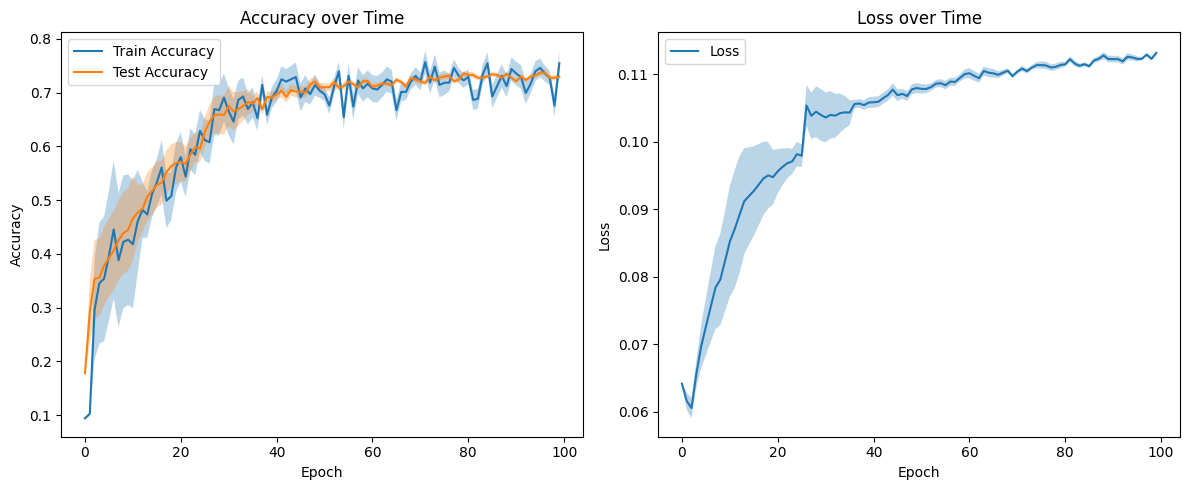

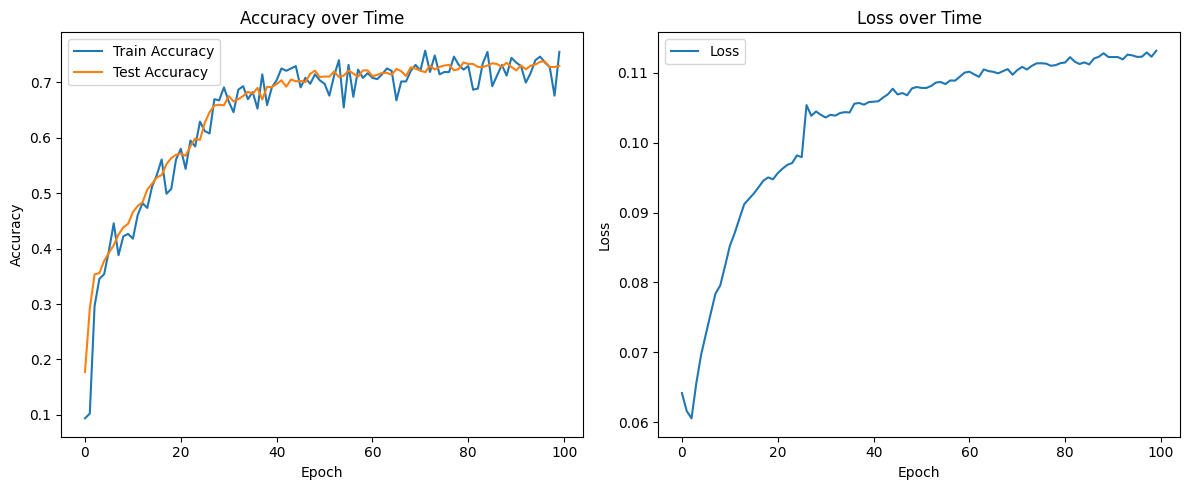

Final Train Accuracy: 0.75 ± 0.02
Final Test Accuracy: 0.73 ± 0.00


In [ ]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

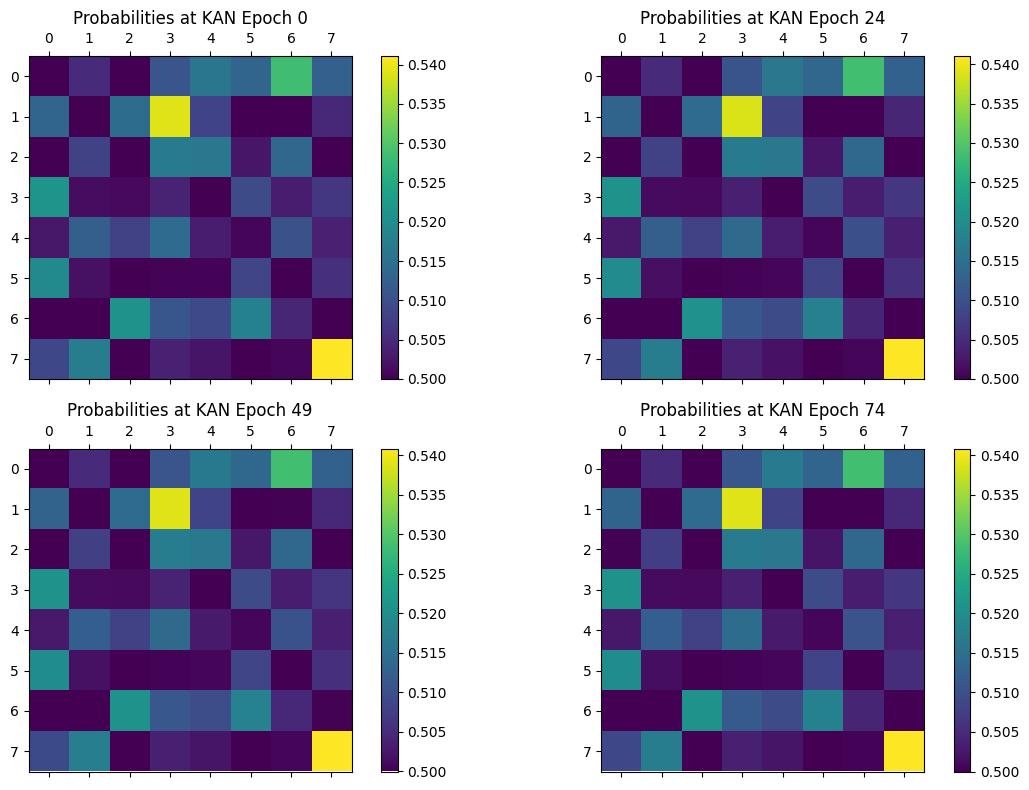

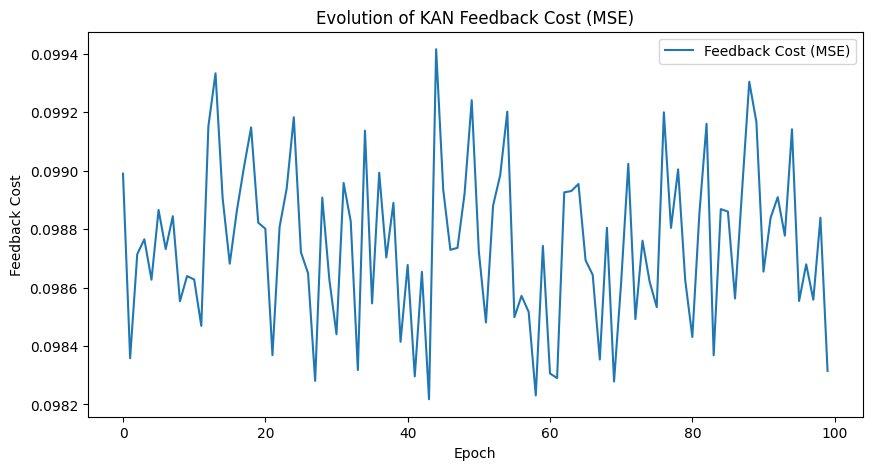

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at KAN Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of KAN Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


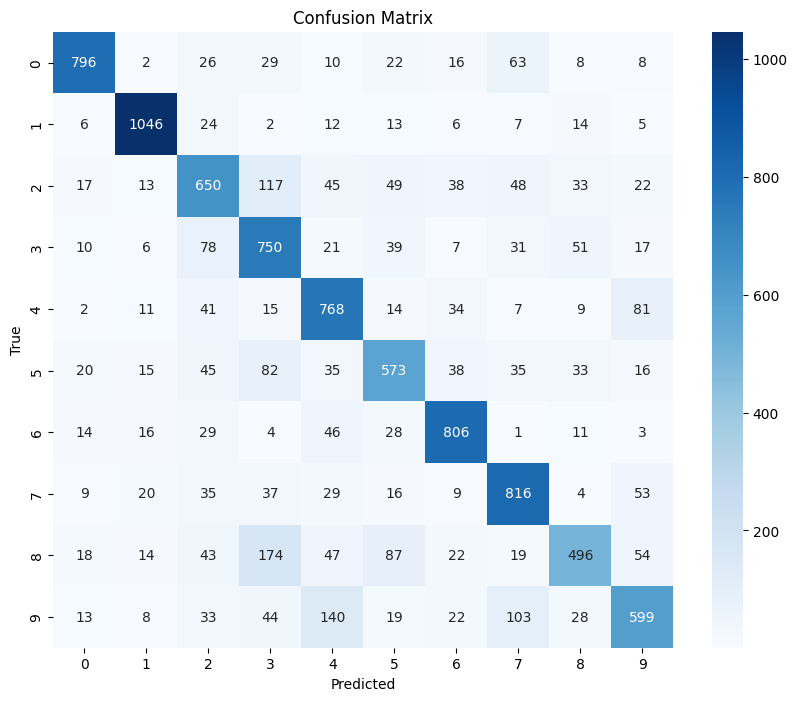

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
    for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       980
           1       0.91      0.92      0.92      1135
           2       0.65      0.63      0.64      1032
           3       0.60      0.74      0.66      1010
           4       0.67      0.78      0.72       982
           5       0.67      0.64      0.65       892
           6       0.81      0.84      0.82       958
           7       0.72      0.79      0.76      1028
           8       0.72      0.51      0.60       974
           9       0.70      0.59      0.64      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



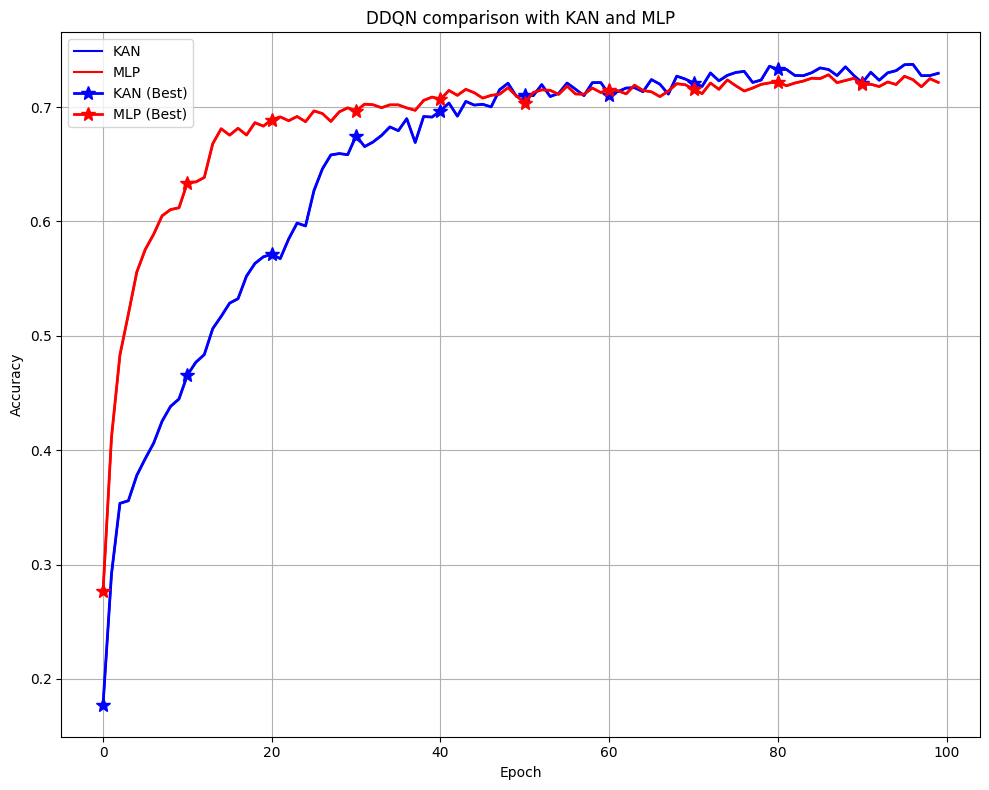

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
import gc
gc.collect()

61101

In [ ]:
q_network.prune()

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=8, out_features=1, bias=False)
    (1): Linear(in_features=10, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

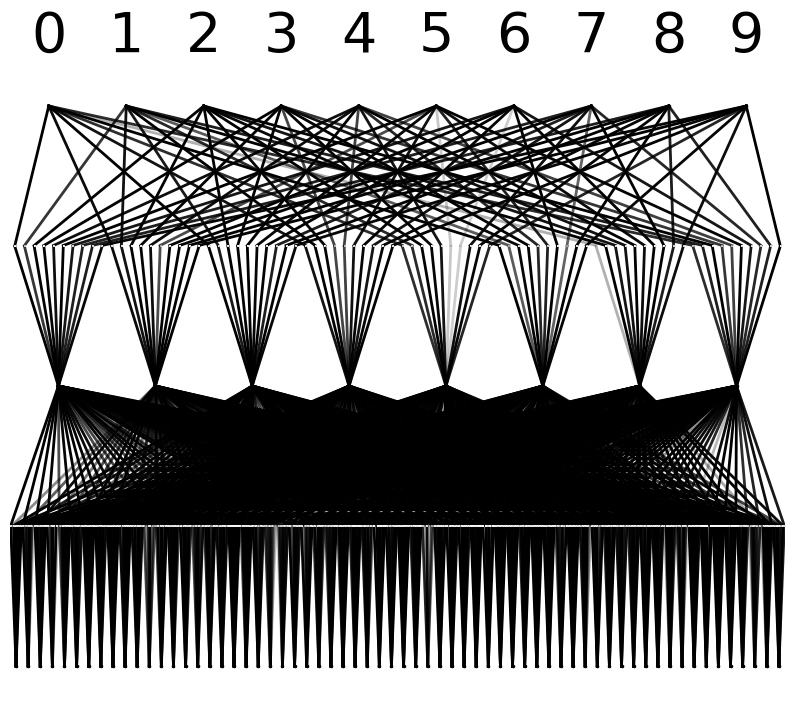

In [ ]:
q_network.plot(beta=30, scale=1, out_vars=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
q_network.auto_symbolic(lib=lib)

fixing (0,0,0) with tan, r2=0.9999465942382812
fixing (0,0,1) with tan, r2=0.9806284308433533
fixing (0,0,2) with tan, r2=0.9999517798423767
fixing (0,0,3) with x^4, r2=0.9999415278434753
fixing (0,0,4) with tan, r2=0.9998669028282166
fixing (0,0,5) with tan, r2=0.9999376535415649
fixing (0,0,6) with x^4, r2=0.9999163150787354
fixing (0,0,7) with tan, r2=0.9999568462371826
fixing (0,1,0) with x^2, r2=0.9996785521507263
fixing (0,1,1) with tan, r2=0.912857174873352
fixing (0,1,2) with x^4, r2=0.9601070284843445
fixing (0,1,3) with x^4, r2=0.8799731135368347
fixing (0,1,4) with x^2, r2=0.9627814888954163
fixing (0,1,5) with x^2, r2=0.9992749094963074
fixing (0,1,6) with exp, r2=0.9975822567939758
fixing (0,1,7) with tan, r2=0.9694077372550964
fixing (0,2,0) with x^4, r2=0.999975323677063
fixing (0,2,1) with x^3, r2=0.9816226959228516
fixing (0,2,2) with tan, r2=0.992830216884613
fixing (0,2,3) with x^4, r2=0.9888305068016052
fixing (0,2,4) with x^3, r2=0.9999372959136963
fixing (0,2,5) w

In [ ]:
symbolic_formula = f"### The symbolic formula of the policy is:"
formulas = q_network.symbolic_formula()[0]

In [ ]:
from sympy import latex
import glob
import os

import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from moviepy.video.compositing.concatenate import concatenate_videoclips
from moviepy.video.io.VideoFileClip import VideoFileClip
from sympy import latex
import matplotlib.pyplot as plt


for i, formula in enumerate(formulas):
    symbolic_formula += "\n$$ a_" + str(i) + "=" + latex(formula) + "$$"
symbolic_formula += "\n" + r"$$ a = \underset{i}{\mathrm{argmax}} \ a_i.$$"

In [ ]:
print(symbolic_formula)

### The symbolic formula of the policy is:
$$ a_0=- 53393.96 \left(0.02 x_{56}^{3} - 0.02 \left(0.06 - x_{20}\right)^{2} - 0.02 \left(0.08 - x_{53}\right)^{2} + 0.02 \left(0.1 - x_{33}\right)^{2} + \left(0.12 - x_{37}\right)^{4} - 0.17 \left(0.12 - x_{55}\right)^{4} - 0.47 \left(0.13 - x_{8}\right)^{4} - 0.23 \left(0.15 - x_{30}\right)^{4} - 0.01 \left(0.17 - x_{2}\right)^{2} - 0.15 \left(0.19 - x_{17}\right)^{4} - 0.04 \left(0.2 - x_{6}\right)^{3} + 0.08 \left(0.25 - x_{36}\right)^{4} - 0.03 \left(0.29 - x_{3}\right)^{4} - 0.08 \left(0.29 - x_{7}\right)^{4} - 0.07 \left(0.3 - x_{49}\right)^{4} + 0.01 \left(0.33 - x_{16}\right)^{3} + 0.02 \left(0.34 - x_{5}\right)^{4} + 0.01 \left(- x_{14} - 0.1\right)^{4} - 0.04 \left(- x_{50} - 0.06\right)^{4} - 0.007023713842412\right)^{2} + 0.22 \sin{\left(- 6.46 \left(0.07 - x_{14}\right)^{2} + 1.16 \left(0.08 - x_{35}\right)^{2} + 12.36 \left(0.1 - x_{54}\right)^{2} + 161.77 \left(0.11 - x_{10}\right)^{4} + 1282.51 \left(0.11 - x_{17}\right)^{4} 

In [ ]:
formulas[0] # formula of a_0

-53393.96*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.007023713842412)**2 + 0.22*sin(-6.46*(0.07 - x_14)**2 + 1.16*(0.08 - x_35)**2 + 12.36*(0.1 - x_54)**2 + 161.77*(0.11 - x_10)**4 + 1282.51*(0.11 - x_17)**4 - 3050.12*(0.12 - x_63)**4 - 838.3*(0.15 - x_45)**4 + 246.49*(0.16 - x_3)**4 - 475.04*(0.16 - x_56)**4 - 8.56*(0.16 - x_64)**2 - 1031.13*(0.16 - x_8)**4 + 908.64*(0.17 - x_28)**4 + 405.12*(0.17 - x_36)**4 + 260.96*(0.18 - x_32)**4 - 2.43*(0.2 - x_23)**2 - 398.13*(0.21 - x_11)**4 - 254.08*(0.21 - x_47)**4 + 190.33*(0.22 - x_20)**4 - 5.84*(0.22 - x_46)**2 + 2.87*(0.24 - x_12)**2 + 111.05*(0.24 - x

In [ ]:
print(formulas[0])

-53393.96*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.007023713842412)**2 + 0.22*sin(-6.46*(0.07 - x_14)**2 + 1.16*(0.08 - x_35)**2 + 12.36*(0.1 - x_54)**2 + 161.77*(0.11 - x_10)**4 + 1282.51*(0.11 - x_17)**4 - 3050.12*(0.12 - x_63)**4 - 838.3*(0.15 - x_45)**4 + 246.49*(0.16 - x_3)**4 - 475.04*(0.16 - x_56)**4 - 8.56*(0.16 - x_64)**2 - 1031.13*(0.16 - x_8)**4 + 908.64*(0.17 - x_28)**4 + 405.12*(0.17 - x_36)**4 + 260.96*(0.18 - x_32)**4 - 2.43*(0.2 - x_23)**2 - 398.13*(0.21 - x_11)**4 - 254.08*(0.21 - x_47)**4 + 190.33*(0.22 - x_20)**4 - 5.84*(0.22 - x_46)**2 + 2.87*(0.24 - x_12)**2 + 111.05*(0.24 - x

In [ ]:
formulas

[-53393.96*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.007023713842412)**2 + 0.22*sin(-6.46*(0.07 - x_14)**2 + 1.16*(0.08 - x_35)**2 + 12.36*(0.1 - x_54)**2 + 161.77*(0.11 - x_10)**4 + 1282.51*(0.11 - x_17)**4 - 3050.12*(0.12 - x_63)**4 - 838.3*(0.15 - x_45)**4 + 246.49*(0.16 - x_3)**4 - 475.04*(0.16 - x_56)**4 - 8.56*(0.16 - x_64)**2 - 1031.13*(0.16 - x_8)**4 + 908.64*(0.17 - x_28)**4 + 405.12*(0.17 - x_36)**4 + 260.96*(0.18 - x_32)**4 - 2.43*(0.2 - x_23)**2 - 398.13*(0.21 - x_11)**4 - 254.08*(0.21 - x_47)**4 + 190.33*(0.22 - x_20)**4 - 5.84*(0.22 - x_46)**2 + 2.87*(0.24 - x_12)**2 + 111.05*(0.24 - 

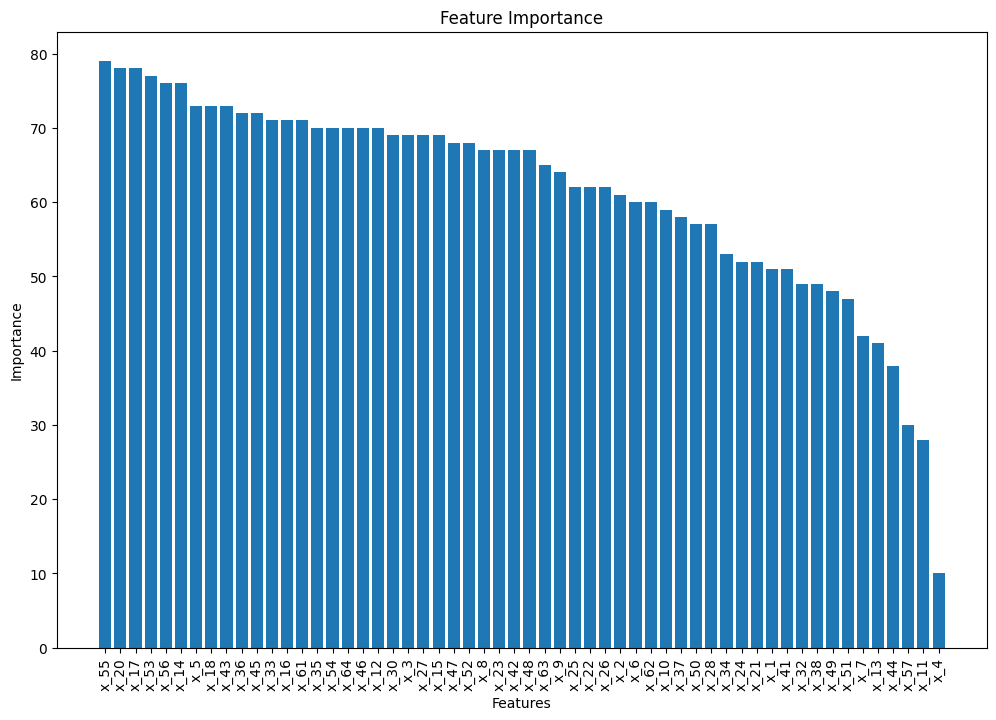

In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Given symbolic formula (abbreviated for clarity)
formula = str(formulas)

# Extract all feature occurrences
features = re.findall(r'x_\d+', formula)

# Count feature occurrences
feature_counts = Counter(features)

# Extract coefficients for the features
coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
coefficients = [float(c) for c in coefficients]

# Combine frequency and coefficient magnitude for importance
feature_importance = {}
for feature in feature_counts:
    feature_importance[feature] = feature_counts[feature]

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# Plotting feature importance
features, importance = zip(*sorted_features)
plt.figure(figsize=(12, 8))
plt.bar(features, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()


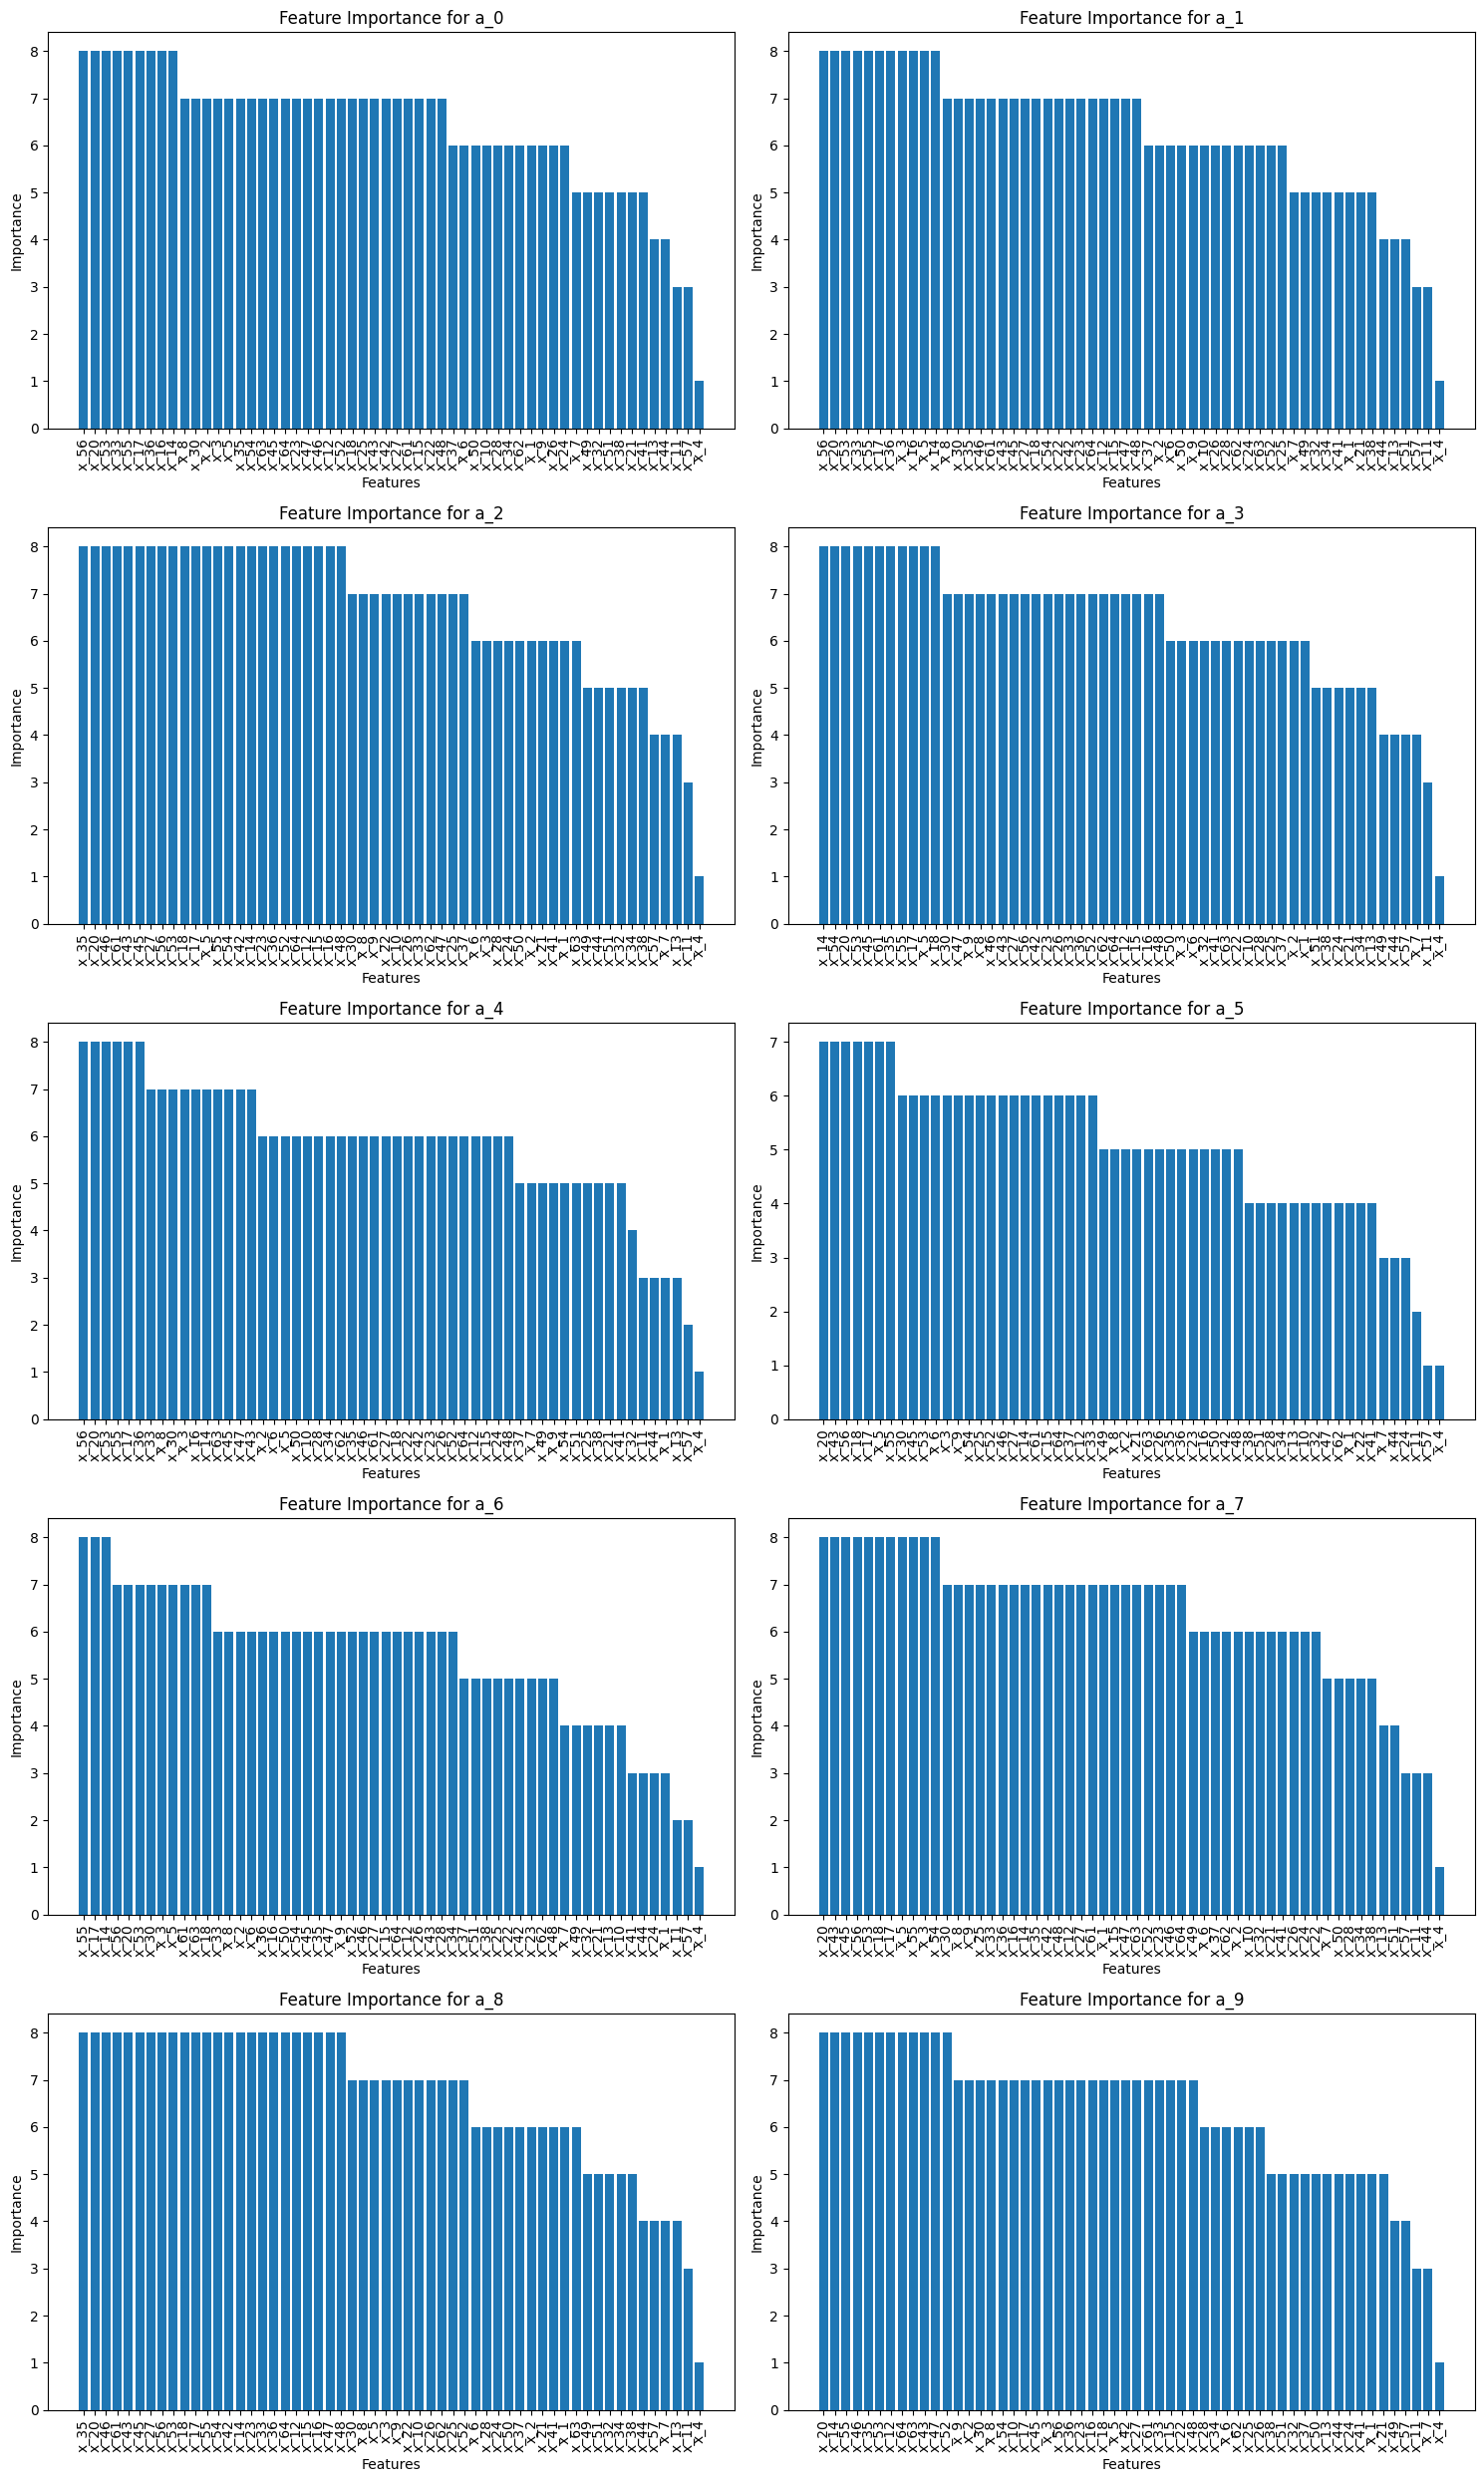

In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt

def parse_formula(formula):
    # Extract all feature occurrences
    features = re.findall(r'x_\d+', formula)
    # Extract coefficients for the features
    coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
    coefficients = [float(c) for c in coefficients]
    return features, coefficients

def compute_feature_importance(features, coefficients):
    # Count feature occurrences
    feature_counts = Counter(features)
    # Combine frequency and coefficient magnitude for importance
    feature_importance = {}
    for feature in feature_counts:
        feature_importance[feature] = feature_counts[feature]
    return feature_importance

# Plot feature importance for each component
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

for i, formula in enumerate(formulas):
    features, coefficients = parse_formula(str(formula))
    feature_importance = compute_feature_importance(features, coefficients)

    # Sort features by importance
    sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

    # Plotting feature importance
    features, importance = zip(*sorted_features)
    axes[i].bar(features, importance)
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Importance')
    axes[i].set_title(f'Feature Importance for a_{i}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


First Part: Activation Functions for the Middle Neurons in the First Hidden Layer

Objective: Plot activation functions for the middle neurons in the first hidden layer.
Setup: A 2x6 grid (2 rows, 6 columns) for plotting.
Loop: Iterate over input neurons (i = 0 and i = 1) and middle neurons (j = 0 to 5).
Layer: l = 1 corresponds to the first hidden layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

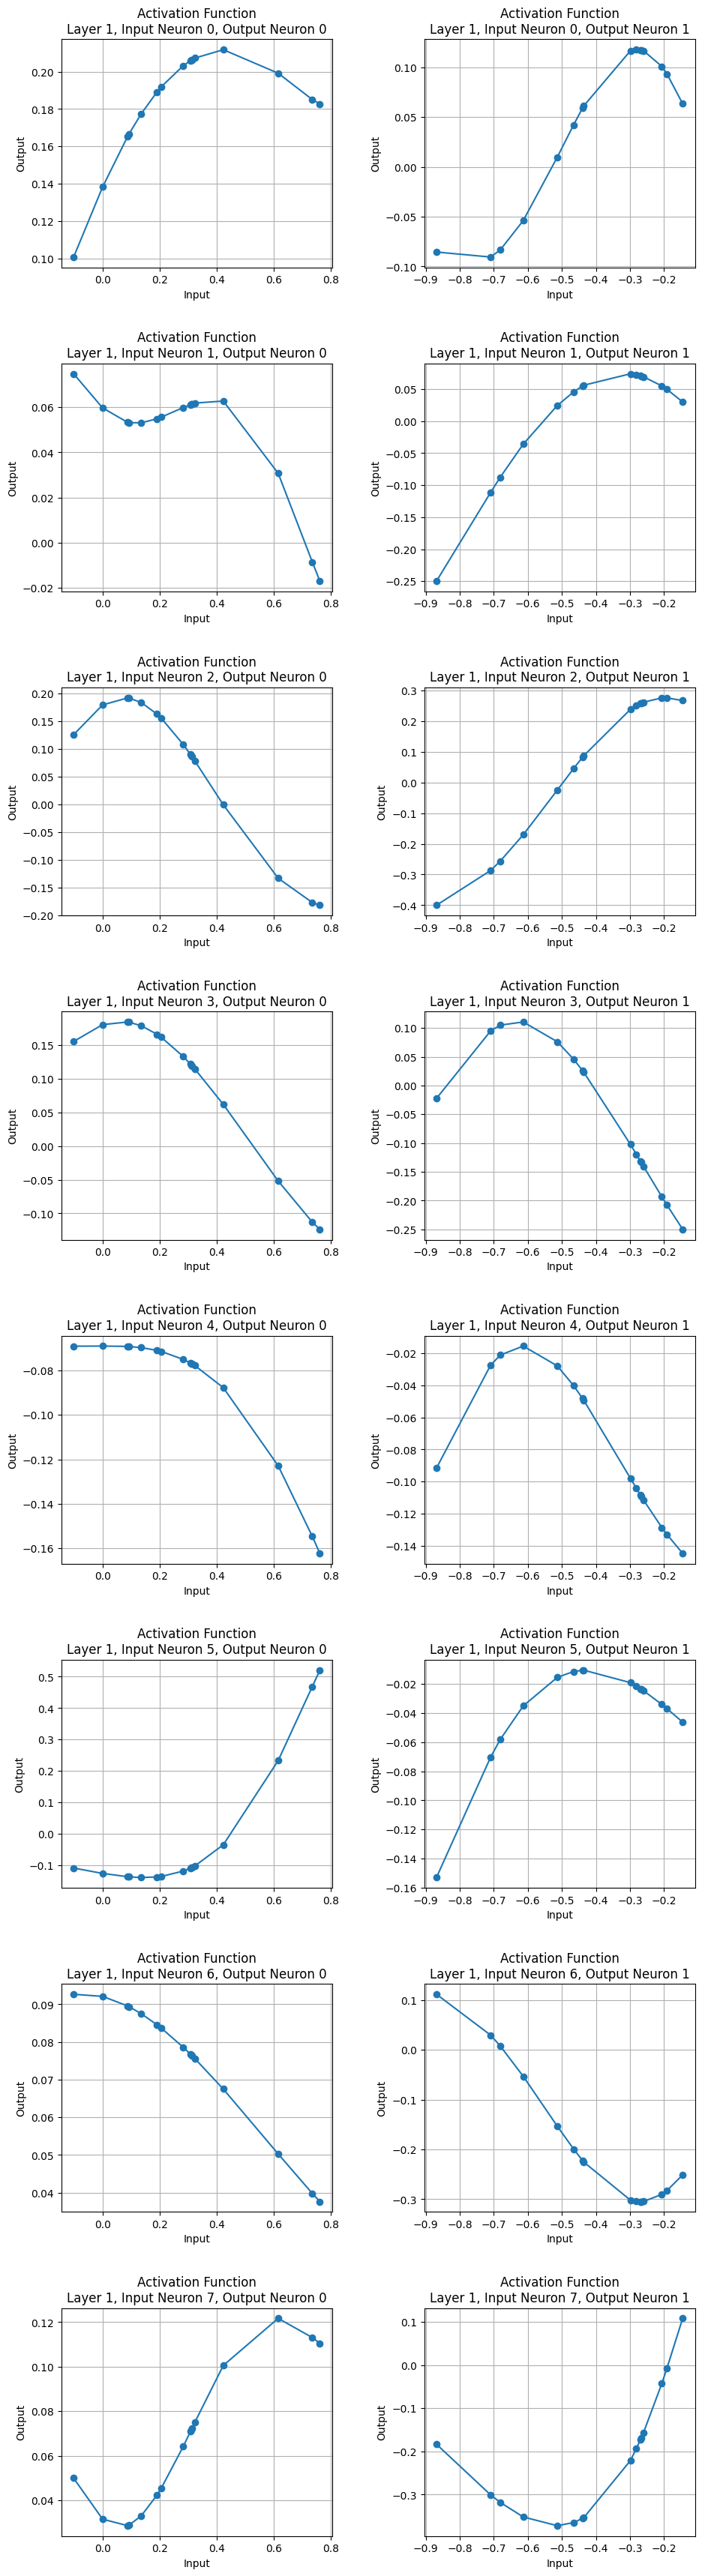

In [ ]:
# Create a 2x6 grid for plotting (2 rows, 6 columns)
fig, axs = plt.subplots(8, 2, figsize=(10, 35))
middle_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Output neurons in the first hidden layer
input_neurons = [0, 1]

model = q_network

for row, i in enumerate(middle_neurons):  # Input neurons i = 0 and i = 1
    for col, j in enumerate(input_neurons):
        l = 1  # Layer index (first hidden layer)

        # Extract inputs and outputs of the spline activation functions
        inputs = model.spline_preacts[l][:, i, j]
        outputs = model.spline_postacts[l][:, i, j]

        # Sort the inputs and corresponding outputs for plotting
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        outputs = outputs[rank]

        # Determine subplot location
        ax = axs[row, col]

        # Plot the activation function
        ax.plot(inputs, outputs, marker="o")
        ax.set_title(f'Activation Function\nLayer {l}, Input Neuron {i}, Output Neuron {j}')
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        ax.grid(True)

plt.tight_layout(pad=3)
plt.show()


Second Part: Activation Functions Between the First Hidden Layer and the Output Layer

Objective: Plot activation functions for the neurons between the first hidden layer and the output layer.
Setup: A 6x2 grid (6 rows, 2 columns) for plotting.
Loop: Iterate over hidden neurons (i = 0 to 5) and output neurons (j = 0 and j = 1).
Layer: l = 1 corresponds to the output layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

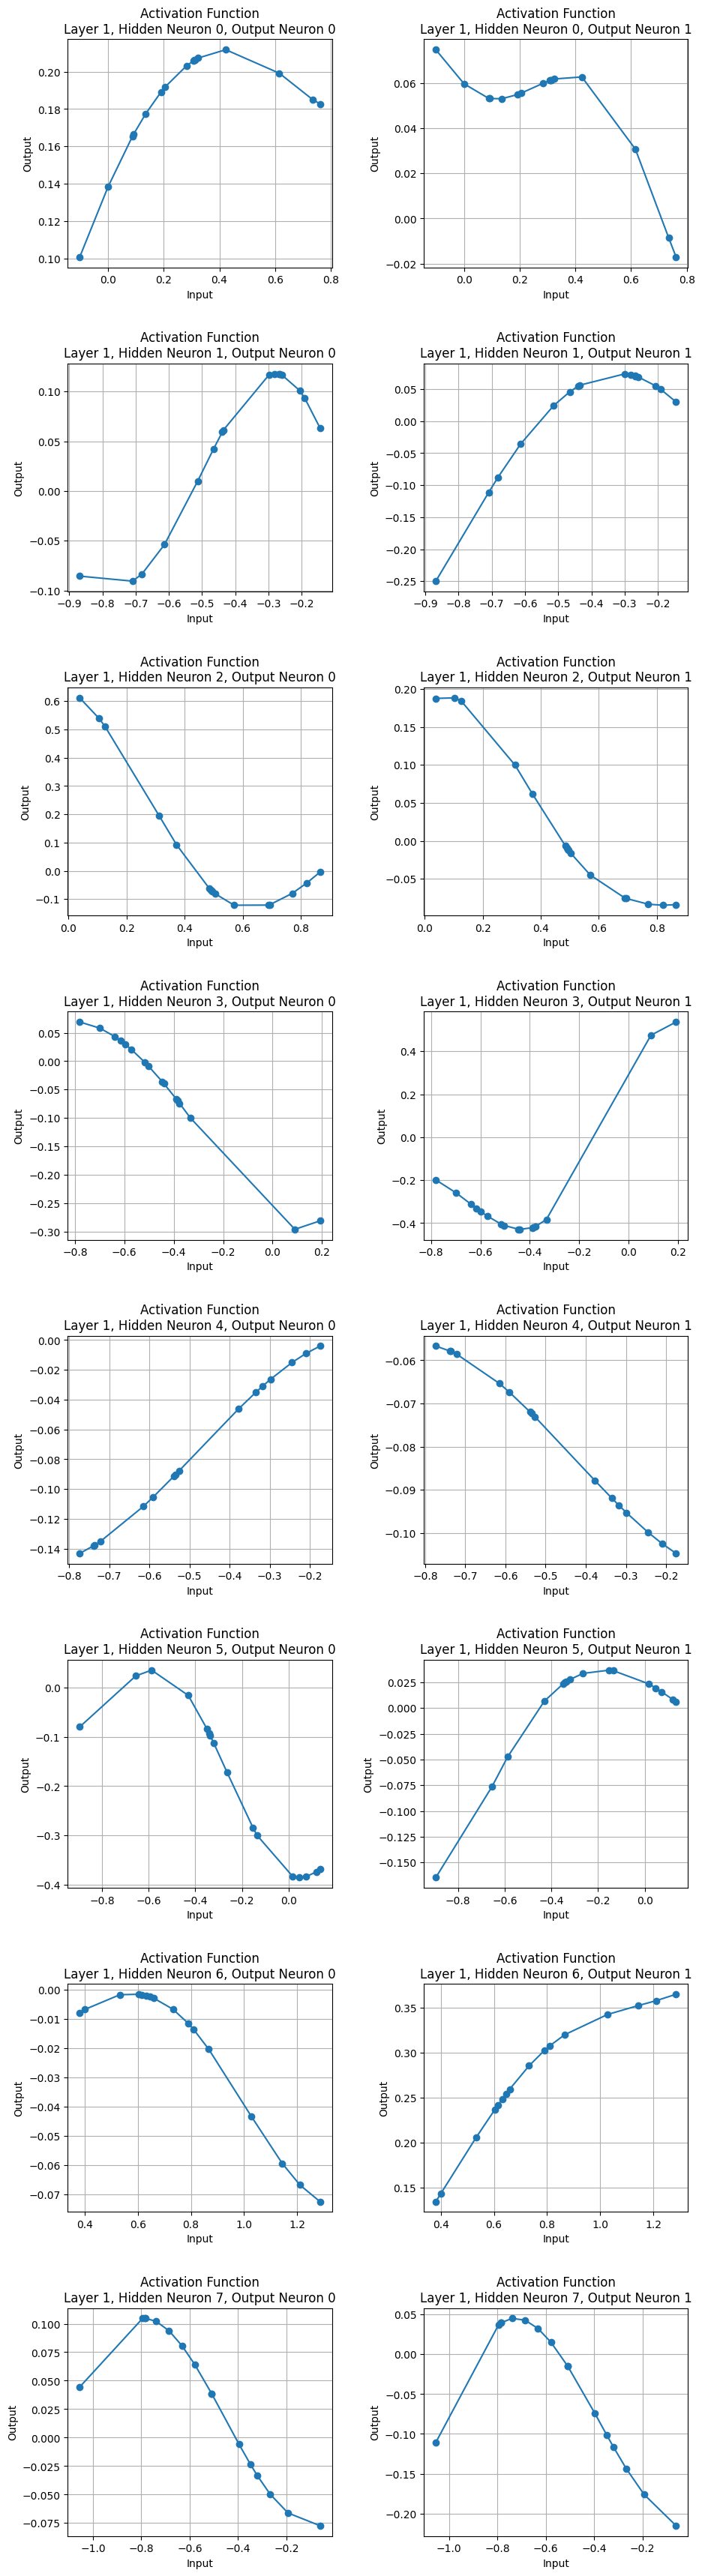

In [ ]:
# Extract and plot activation functions for the neurons between the first hidden layer and the output layer
hidden_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Neurons in the first hidden layer
output_neurons = [0, 1]  # Neurons in the output layer

# Create a 3x2 grid for plotting
fig, axs = plt.subplots(8, 2, figsize=(10, 35))

for row, i in enumerate(hidden_neurons):  # Neurons in the first hidden layer
    for col, j in enumerate(output_neurons):  # Neurons in the output layer
        l = 1  # Layer index (output layer)

        # Extract inputs and outputs of the spline activation functions
        inputs = model.spline_preacts[l][:, j, i]
        outputs = model.spline_postacts[l][:, j, i]

        # Sort the inputs and corresponding outputs for plotting
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        outputs = outputs[rank]

        # Determine subplot location
        ax = axs[row, col]

        # Plot the activation function
        ax.plot(inputs, outputs, marker="o")
        ax.set_title(f'Activation Function\nLayer {l}, Hidden Neuron {i}, Output Neuron {j}')
        ax.set_xlabel('Input')
        ax.set_ylabel('Output')
        ax.grid(True)

# Add space between subplots
plt.tight_layout(pad=3.0)
plt.show()

# Tensorboard

In [ ]:
import gc
gc.collect()

53086

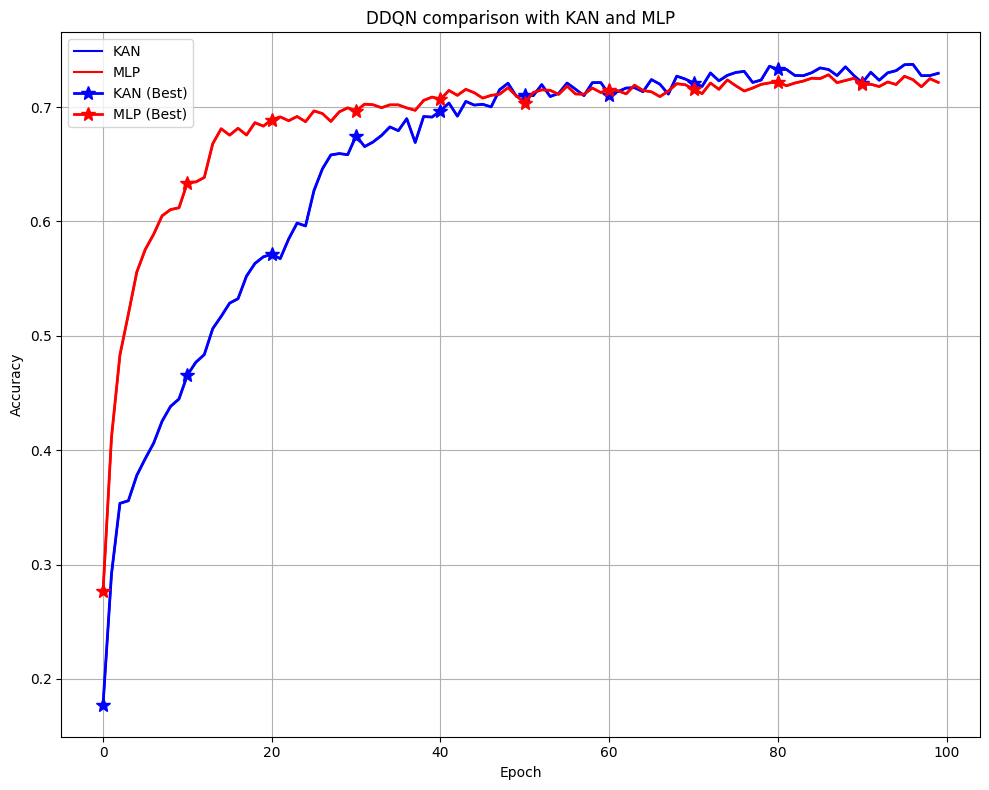

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
# from google.colab import files
# files.download('/content/results/KAN_MNIST_0_1720304363.csv')

In [5]:
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, exp, sin, cos, log, sqrt, tan, sinh, cosh, Abs, tanh
import numpy as np

# Explicitly define all 64 variables
x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34, x_35, x_36, x_37, x_38, x_39, x_40, x_41, x_42, x_43, x_44, x_45, x_46, x_47, x_48, x_49, x_50, x_51, x_52, x_53, x_54, x_55, x_56, x_57, x_58, x_59, x_60, x_61, x_62, x_63, x_64 = symbols('x_1:65')


formulas = [-53393.96*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.007023713842412)**2 + 0.22*sin(-6.46*(0.07 - x_14)**2 + 1.16*(0.08 - x_35)**2 + 12.36*(0.1 - x_54)**2 + 161.77*(0.11 - x_10)**4 + 1282.51*(0.11 - x_17)**4 - 3050.12*(0.12 - x_63)**4 - 838.3*(0.15 - x_45)**4 + 246.49*(0.16 - x_3)**4 - 475.04*(0.16 - x_56)**4 - 8.56*(0.16 - x_64)**2 - 1031.13*(0.16 - x_8)**4 + 908.64*(0.17 - x_28)**4 + 405.12*(0.17 - x_36)**4 + 260.96*(0.18 - x_32)**4 - 2.43*(0.2 - x_23)**2 - 398.13*(0.21 - x_11)**4 - 254.08*(0.21 - x_47)**4 + 190.33*(0.22 - x_20)**4 - 5.84*(0.22 - x_46)**2 + 2.87*(0.24 - x_12)**2 + 111.05*(0.24 - x_53)**4 + 82.06*(0.3 - x_34)**4 + 19.33*(0.3 - x_62)**4 - 29.97*(0.42 - x_55)**4 - 8.68*(0.47 - x_37)**4 + 1.03*(1 - 0.38*x_52)**3 - 0.14*(-x_16 - 0.82)**2 - 13.33*(-x_18 - 0.06)**3 - 1.29*(-x_2 - 0.64)**2 - 2.17*(-x_25 - 0.02)**2 + 191.42*(-x_43 - 0.09)**4 - 14.92*(-x_5 - 0.16)**3 + 165.11*(-x_50 - 0.07)**4 + 0.59*exp(10.0*x_42) + 0.42*sin(10.0*x_27 + 4.4) + 0.33*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.03*tan(0.4*x_13 - 7.82) - 0.41*tan(9.6*x_33 + 2.18) - 0.18*Abs(9.8*x_15 - 3.69) + 0.08*Abs(10.0*x_22 - 1.6) + 0.36*Abs(9.8*x_9 - 0.42) + 5.07897601357067 - 0.52*exp(-8.33*x_48) - 0.36*exp(-10.0*x_44) + 0.45*exp(-10.0*x_26)) - 0.11*sin(3.04*(0.04 - x_35)**2 + 110.89*(0.08 - x_20)**2 + 8.19*(0.08 - x_46)**2 + 9.65*(0.1 - x_61)**2 - 1577.31*(0.12 - x_30)**4 - 647.45*(0.12 - x_43)**4 - 2086.31*(0.12 - x_45)**4 - 1044.59*(0.12 - x_49)**4 + 8.8*(0.14 - x_27)**2 + 894.61*(0.14 - x_56)**4 - 17.22*(0.16 - x_53)**2 + 358.96*(0.18 - x_6)**4 - 28.89*(0.2 - x_18)**3 + 53.16*(0.22 - x_8)**3 - 267.49*(0.23 - x_17)**4 + 153.93*(0.23 - x_5)**4 + 308.48*(0.23 - x_55)**4 - 23.58*(0.24 - x_3)**3 + 297.79*(0.25 - x_9)**4 - 20.05*(0.46 - x_54)**4 + 0.75*(-x_22 - 0.9)**2 - 4.26*exp(10.0*x_42) + 0.06*tan(10.0*x_10 + 2.6) + 0.03*tan(1.04*x_14 - 7.81) - 0.e-2*tan(10.0*x_2 + 2.75) - 0.02*tan(7.56*x_23 - 6.85) + 0.01*tan(10.0*x_25 + 1.8) + 0.01*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.33*tan(10.0*x_33 + 5.2) + 0.01*tan(0.4*x_34 + 1.59) - 0.02*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.e-2*tan(1.3*x_51 + 1.6) + 0.01*tan(0.03*x_52 + 4.7) - 0.06*tan(0.67*x_57 + 1.6) + 0.03*tan(0.61*x_62 + 4.78) - 0.e-2*tan(4.0*x_63 - 7.99) - 0.33*tanh(10.0*x_64 - 1.0) - 0.04*Abs(10.0*x_12 - 1.45) + 0.1*Abs(10.0*x_15 - 4.0) + 0.1*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.37*Abs(10.0*x_47 - 0.2) - 0.2*Abs(9.6*x_50 - 0.64) + 2.94 + 0.86*exp(-10.0*x_48)) - 0.18*sin(96.27*(0.02 - x_10)**4 - 16.81*(0.06 - x_53)**2 + 348.32*(0.1 - x_56)**4 + 11.55*(0.11 - x_22)**3 + 4.27*(0.11 - x_35)**2 - 12.69*(0.12 - x_33)**2 - 6.06*(0.13 - x_12)**2 + 208.31*(0.13 - x_36)**3 + 1582.24*(0.13 - x_49)**4 + 9.19*(0.13 - x_61)**2 + 2.97*(0.14 - x_25)**2 + 182.39*(0.14 - x_3)**4 - 249.22*(0.14 - x_50)**4 + 492.9*(0.15 - x_28)**4 + 15.98*(0.15 - x_55)**2 - 202.39*(0.16 - x_30)**4 - 64.13*(0.17 - x_64)**3 - 13.18*(0.22 - x_43)**3 - 95.37*(0.24 - x_51)**4 + 90.14*(0.26 - x_15)**4 + 46.65*(0.3 - x_1)**4 + 33.74*(0.34 - x_17)**3 - 4.41*(0.34 - x_45)**3 - 18.6*(0.39 - x_34)**4 + 5.03*(1 - 0.52*x_38)**4 - 14.68*(-x_2 - 0.02)**4 + 1.62*(-x_46 - 0.1)**2 + 4.94*(-x_52 - 0.04)**2 - 4.32*(-x_6 - 0.34)**3 + 3.66*exp(6.0*x_4) - 0.13*exp(10.0*x_42) + 2.31*exp(1.81*x_48) - 0.08*sin(8.83*x_16 + 1.59) + 0.14*sin(10.0*x_23 - 3.8) + 0.1*sin(10.0*x_27 + 8.0) - 0.34*sin(5.68*x_62 - 1.41) - 0.14*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.03*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.e-2*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.04*tan(1.24*x_47 + 4.79) + 0.01*tan(1.05*x_9 - 7.81) + 0.1*Abs(8.2*x_14 - 0.42) + 0.15*Abs(9.8*x_54 - 0.82) - 19.84 - 0.82*exp(-6.58*x_63)) - 0.09*sin(49.66*(0.02 - x_50)**2 - 6.36*(0.08 - x_14)**2 + 1.98*(0.09 - x_24)**2 + 987.01*(0.1 - x_30)**4 + 20.52*(0.1 - x_54)**2 - 50.13*(0.15 - x_20)**2 - 13.44*(0.15 - x_53)**2 + 175.63*(0.16 - x_3)**3 + 32.98*(0.16 - x_45)**3 + 109.39*(0.16 - x_61)**4 + 163.71*(0.17 - x_35)**4 + 72.93*(0.22 - x_6)**4 - 354.97*(0.24 - x_47)**4 - 180.5*(0.24 - x_9)**4 + 13.32*(0.26 - x_51)**4 + 20.44*(0.33 - x_55)**4 - 32.55*(0.37 - x_17)**4 - 8.35*(0.63 - x_11)**4 - 1.49*(-x_22 - 0.14)**3 - 8.81*(-x_32 - 0.41)**3 + 8.96*(-0.88*x_41 - 1)**4 - 17.0*(-x_5 - 0.28)**3 - 15.89*(-x_63 - 0.36)**4 + 54.2*(-x_8 - 0.17)**4 + 22.11*exp(0.09*x_18) - 1.29*exp(10.0*x_42) - 0.16*sin(9.18*x_15 + 7.61) + 0.4*sin(4.5*x_16 - 1.38) - 0.26*sin(8.23*x_25 + 4.59) - 0.58*sin(10.0*x_27 + 1.8) - 0.49*sin(10.0*x_33 + 2.2) + 0.2*sin(10.0*x_52 + 8.2) + 0.38*sin(9.38*x_64 - 1.6) + 0.03*tan(0.22*x_1 + 1.59) - 0.08*tan(7.4*x_10 + 2.6) - 0.09*tan(6.95*x_12 - 7.79) - 0.09*tan(0.8*x_23 + 7.49) + 0.02*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.06*tan(0.2*x_49 + 4.75) - 0.01*tan(1.35*x_7 + 1.6) + 0.08*Abs(9.8*x_21 - 1.05) + 0.92*Abs(9.2*x_36 - 0.42) + 0.36*Abs(9.4*x_43 - 0.62) + 0.33*Abs(10.0*x_46 - 0.8) + 0.04*Abs(9.8*x_56 - 1.65) + 7.12 - 0.53*exp(-10.0*x_48) - 36.8*exp(-0.12*x_38)) - 0.08*sin(8.87*x_56**2 - 4.03*(0.02 - x_25)**2 - 18.14*(0.05 - x_52)**2 + 45.7*(0.06 - x_6)**2 - 52.55*(0.07 - x_20)**2 + 15.31*(0.07 - x_46)**2 - 14.78*(0.08 - x_2)**2 + 22.4*(0.1 - x_21)**2 - 20.74*(0.11 - x_18)**2 - 11.08*(0.15 - x_27)**2 - 255.09*(0.16 - x_30)**4 - 41.07*(0.18 - x_14)**3 + 15.42*(0.19 - x_61)**2 + 372.6*(0.2 - x_38)**4 - 195.97*(0.2 - x_51)**4 - 29.55*(0.2 - x_55)**2 + 13.91*(0.22 - x_15)**3 + 3.72*(0.26 - x_64)**2 + 42.56*(0.27 - x_37)**4 + 26.07*(0.32 - x_17)**4 + 73.93*(0.32 - x_63)**4 + 4.46*(0.43 - x_12)**4 + 3.19*(0.99 - x_26)**4 - 19.99*(1 - 0.06*x_43)**4 - 2.17*(-0.48*x_28 - 1)**3 - 5.02*(-x_3 - 0.32)**3 - 13.76*(-x_33 - 0.05)**2 + 6.32*(-x_34 - 0.43)**4 - 0.78*(-x_35 - 0.02)**2 - 268.21*(-x_5 - 0.07)**4 + 11.92*(-x_7 - 0.5)**4 - 0.22*(-0.79*x_8 - 1)**4 - 16.86*exp(0.66*x_13) + 0.17*exp(10.0*x_42) + 0.19*sin(6.09*x_16 - 1.38) - 0.1*sin(9.69*x_22 - 4.59) - 0.21*sin(10.0*x_23 - 2.2) + 0.12*sin(10.0*x_24 + 6.6) + 0.1*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.11*tanh(10.0*x_53 - 1.0) + 0.11*Abs(9.8*x_10 - 0.42) + 0.22*Abs(9.2*x_36 - 1.24) - 0.15*Abs(10.0*x_45 - 0.4) - 0.13*Abs(9.8*x_47 - 0.45) + 16.58 + 0.52*exp(-10.0*x_48) + 0.64*exp(-10.0*x_41)) - 0.04*sin(3.88*(0.02 - x_10)**2 - 7.48*(0.08 - x_64)**2 + 3662.4*(0.1 - x_33)**4 - 4.0*(0.1 - x_46)**2 + 958.46*(0.1 - x_8)**4 - 4.38*(0.11 - x_22)**2 - 14.71*(0.14 - x_14)**2 - 933.9*(0.14 - x_34)**4 - 16.0*(0.17 - x_61)**2 + 237.68*(0.2 - x_1)**4 - 326.18*(0.2 - x_7)**4 + 102.24*(0.22 - x_28)**4 - 164.75*(0.22 - x_5)**4 - 21.14*(0.23 - x_55)**3 - 126.04*(0.27 - x_45)**4 + 72.49*(0.29 - x_37)**4 + 24.35*(0.32 - x_32)**3 + 12.04*(0.43 - x_38)**4 + 2.95*(-x_23 - 0.02)**2 - 282.3*(-x_30 - 0.02)**4 - 0.22*(-x_35 - 0.7)**3 + 2.28*(-x_52 - 0.26)**2 + 24.79*(-x_9 - 0.14)**3 + 1.77*exp(0.64*x_2) + 3.81*exp(0.29*x_21) + 0.22*exp(4.05*x_25) - 0.86*exp(10.0*x_42) + 9.35*exp(0.84*x_63) - 0.4*sin(10.0*x_27 - 7.8) - 0.68*sin(10.0*x_54 - 0.24) + 0.03*sin(10.0*x_62 + 8.0) + 0.02*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.04*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.03*tan(0.67*x_57 + 1.6) - 0.06*Abs(9.6*x_12 - 1.84) - 0.24*Abs(10.0*x_15 - 3.2) + 0.07*Abs(9.8*x_16 - 4.07) - 0.03*Abs(10.0*x_24 - 2.6) + 0.22*Abs(8.6*x_47 - 0.42) - 0.38*Abs(6.2*x_53 - 0.21) - 32.86 - 0.19*exp(-10.0*x_48) + 0.36*exp(-10.0*x_26) + 1.63*exp(-0.62*x_18) + 17.55*exp(-0.23*x_17)) - 0.44*sin(52.22*(0.06 - x_9)**2 + 2.27*(0.07 - x_22)**2 + 4.27*(0.08 - x_23)**2 + 21.59*(0.1 - x_20)**2 + 1148.66*(0.11 - x_14)**4 + 8.53*(0.12 - x_55)**2 - 526.31*(0.13 - x_2)**4 + 873.94*(0.14 - x_30)**4 - 7.94*(0.15 - x_46)**2 + 26.58*(0.16 - x_35)**3 - 388.12*(0.16 - x_53)**4 + 134.54*(0.21 - x_12)**4 - 88.11*(0.21 - x_8)**4 + 349.09*(0.22 - x_28)**4 + 13.28*(0.22 - x_64)**2 - 290.17*(0.23 - x_63)**4 + 18.78*(0.26 - x_38)**4 + 23.5*(0.28 - x_34)**4 - 48.44*(0.28 - x_51)**4 + 4.0*(0.33 - x_15)**2 - 1.54*(0.78 - x_62)**4 - 0.25*(1 - 0.4*x_27)**3 + 43.23*(-x_43 - 0.13)**3 - 283.2*(-x_47 - 0.02)**4 - 10.13*(-x_52 - 0.08)**3 - 5.92*(-0.1*x_6 - 1)**4 - 0.96*exp(10.0*x_41) + 0.15*exp(10.0*x_42) + 0.08*sin(10.0*x_25 - 5.0) + 0.19*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.2*x_1 + 1.58) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.08*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.05*tan(5.8*x_24 + 8.2) + 0.01*tan(0.6*x_32 + 1.59) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.01*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.23*tanh(10.0*x_54 - 1.0) - 0.04*Abs(10.0*x_18 - 1.06) + 0.17*Abs(10.0*x_36 - 0.4) - 0.66*Abs(8.4*x_49 - 0.42) + 0.35*Abs(10.0*x_50 - 0.42) - 12.74 + 1.97*exp(-1.57*x_56) - 1.02*exp(-6.56*x_5) + 0.37*exp(-10.0*x_48) + 0.11*exp(-10.0*x_26) + 0.58*exp(-8.34*x_17)) + 0.13,
 27120433.73*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.00763255650642016)**3 + 0.27*sin(1.54*(0.04 - x_35)**2 + 56.06*(0.08 - x_20)**2 + 4.14*(0.08 - x_46)**2 + 4.88*(0.1 - x_61)**2 - 797.36*(0.12 - x_30)**4 - 327.3*(0.12 - x_43)**4 - 1054.66*(0.12 - x_45)**4 - 528.06*(0.12 - x_49)**4 + 4.45*(0.14 - x_27)**2 + 452.24*(0.14 - x_56)**4 - 8.71*(0.16 - x_53)**2 + 181.46*(0.18 - x_6)**4 - 14.6*(0.2 - x_18)**3 + 26.87*(0.22 - x_8)**3 - 135.22*(0.23 - x_17)**4 + 77.81*(0.23 - x_5)**4 + 155.94*(0.23 - x_55)**4 - 11.92*(0.24 - x_3)**3 + 150.54*(0.25 - x_9)**4 - 10.14*(0.46 - x_54)**4 + 0.38*(-x_22 - 0.9)**2 - 2.15*exp(10.0*x_42) + 0.03*tan(10.0*x_10 + 2.6) + 0.01*tan(1.04*x_14 - 7.81) - 0.01*tan(7.56*x_23 - 6.85) + 0.01*tan(0.42*x_26 + 1.59) - 0.e-2*tan(0.42*x_28 + 1.59) + 0.17*tan(10.0*x_33 + 5.2) - 0.e-2*tan(1.92*x_36 - 7.8) + 0.01*tan(1.4*x_44 + 1.6) - 0.03*tan(0.67*x_57 + 1.6) + 0.02*tan(0.61*x_62 + 4.78) - 0.17*tanh(10.0*x_64 - 1.0) - 0.02*Abs(10.0*x_12 - 1.45) + 0.05*Abs(10.0*x_15 - 4.0) + 0.05*Abs(10.0*x_16 - 4.3) - 0.01*Abs(10.0*x_24 - 1.8) - 0.19*Abs(10.0*x_47 - 0.2) - 0.1*Abs(9.6*x_50 - 0.64) + 0.81 + 0.43*exp(-10.0*x_48)) - 0.15*sin(-3.76*(0.07 - x_14)**2 + 0.68*(0.08 - x_35)**2 + 7.2*(0.1 - x_54)**2 + 94.28*(0.11 - x_10)**4 + 747.42*(0.11 - x_17)**4 - 1777.56*(0.12 - x_63)**4 - 488.54*(0.15 - x_45)**4 + 143.65*(0.16 - x_3)**4 - 276.84*(0.16 - x_56)**4 - 4.99*(0.16 - x_64)**2 - 600.92*(0.16 - x_8)**4 + 529.54*(0.17 - x_28)**4 + 236.1*(0.17 - x_36)**4 + 152.08*(0.18 - x_32)**4 - 1.42*(0.2 - x_23)**2 - 232.02*(0.21 - x_11)**4 - 148.08*(0.21 - x_47)**4 + 110.92*(0.22 - x_20)**4 - 3.41*(0.22 - x_46)**2 + 1.67*(0.24 - x_12)**2 + 64.72*(0.24 - x_53)**4 + 47.82*(0.3 - x_34)**4 + 11.26*(0.3 - x_62)**4 - 17.47*(0.42 - x_55)**4 - 5.06*(0.47 - x_37)**4 + 0.6*(1 - 0.38*x_52)**3 - 0.08*(-x_16 - 0.82)**2 - 7.77*(-x_18 - 0.06)**3 - 0.75*(-x_2 - 0.64)**2 - 1.27*(-x_25 - 0.02)**2 + 111.56*(-x_43 - 0.09)**4 - 8.69*(-x_5 - 0.16)**3 + 96.22*(-x_50 - 0.07)**4 + 0.35*exp(10.0*x_42) + 0.24*sin(10.0*x_27 + 4.4) + 0.19*sin(10.0*x_61 + 2.4) + 0.02*tan(0.4*x_13 - 7.82) - 0.24*tan(9.6*x_33 + 2.18) - 0.1*Abs(9.8*x_15 - 3.69) + 0.05*Abs(10.0*x_22 - 1.6) + 0.21*Abs(9.8*x_9 - 0.42) + 1.70472147303935 - 0.31*exp(-8.33*x_48) - 0.21*exp(-10.0*x_44) + 0.26*exp(-10.0*x_26)) + 0.13*sin(53.09*(0.02 - x_50)**2 - 6.8*(0.08 - x_14)**2 + 2.12*(0.09 - x_24)**2 + 1055.26*(0.1 - x_30)**4 + 21.94*(0.1 - x_54)**2 - 53.6*(0.15 - x_20)**2 - 14.37*(0.15 - x_53)**2 + 187.77*(0.16 - x_3)**3 + 35.26*(0.16 - x_45)**3 + 116.95*(0.16 - x_61)**4 + 175.03*(0.17 - x_35)**4 + 77.97*(0.22 - x_6)**4 - 379.51*(0.24 - x_47)**4 - 192.98*(0.24 - x_9)**4 + 14.24*(0.26 - x_51)**4 + 21.85*(0.33 - x_55)**4 - 34.8*(0.37 - x_17)**4 - 8.93*(0.63 - x_11)**4 - 1.59*(-x_22 - 0.14)**3 - 9.42*(-x_32 - 0.41)**3 + 9.58*(-0.88*x_41 - 1)**4 - 18.17*(-x_5 - 0.28)**3 - 16.99*(-x_63 - 0.36)**4 + 57.95*(-x_8 - 0.17)**4 + 23.64*exp(0.09*x_18) - 1.38*exp(10.0*x_42) - 0.17*sin(9.18*x_15 + 7.61) + 0.42*sin(4.5*x_16 - 1.38) - 0.28*sin(8.23*x_25 + 4.59) - 0.62*sin(10.0*x_27 + 1.8) - 0.53*sin(10.0*x_33 + 2.2) + 0.22*sin(10.0*x_52 + 8.2) + 0.4*sin(9.38*x_64 - 1.6) + 0.03*tan(0.22*x_1 + 1.59) - 0.08*tan(7.4*x_10 + 2.6) - 0.09*tan(6.95*x_12 - 7.79) - 0.09*tan(0.8*x_23 + 7.49) + 0.02*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.07*tan(0.2*x_49 + 4.75) - 0.01*tan(1.35*x_7 + 1.6) + 0.09*Abs(9.8*x_21 - 1.05) + 0.99*Abs(9.2*x_36 - 0.42) + 0.39*Abs(9.4*x_43 - 0.62) + 0.36*Abs(10.0*x_46 - 0.8) + 0.04*Abs(9.8*x_56 - 1.65) + 11.28 - 0.57*exp(-10.0*x_48) - 39.35*exp(-0.12*x_38)) - 0.57*sin(103.05*(0.02 - x_10)**4 - 17.99*(0.06 - x_53)**2 + 372.85*(0.1 - x_56)**4 + 12.36*(0.11 - x_22)**3 + 4.57*(0.11 - x_35)**2 - 13.58*(0.12 - x_33)**2 - 6.49*(0.13 - x_12)**2 + 222.98*(0.13 - x_36)**3 + 1693.62*(0.13 - x_49)**4 + 9.83*(0.13 - x_61)**2 + 3.17*(0.14 - x_25)**2 + 195.23*(0.14 - x_3)**4 - 266.77*(0.14 - x_50)**4 + 527.6*(0.15 - x_28)**4 + 17.11*(0.15 - x_55)**2 - 216.64*(0.16 - x_30)**4 - 68.65*(0.17 - x_64)**3 - 14.1*(0.22 - x_43)**3 - 102.08*(0.24 - x_51)**4 + 96.48*(0.26 - x_15)**4 + 49.93*(0.3 - x_1)**4 + 36.11*(0.34 - x_17)**3 - 4.72*(0.34 - x_45)**3 - 19.91*(0.39 - x_34)**4 + 5.39*(1 - 0.52*x_38)**4 - 15.71*(-x_2 - 0.02)**4 + 1.73*(-x_46 - 0.1)**2 + 5.29*(-x_52 - 0.04)**2 - 4.63*(-x_6 - 0.34)**3 + 3.91*exp(6.0*x_4) - 0.14*exp(10.0*x_42) + 2.47*exp(1.81*x_48) - 0.09*sin(8.83*x_16 + 1.59) + 0.15*sin(10.0*x_23 - 3.8) + 0.11*sin(10.0*x_27 + 8.0) - 0.37*sin(5.68*x_62 - 1.41) - 0.15*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.03*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.01*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.04*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.01*tan(1.05*x_9 - 7.81) + 0.11*Abs(8.2*x_14 - 0.42) + 0.16*Abs(9.8*x_54 - 0.82) - 12.34 - 0.87*exp(-6.58*x_63)) - 0.03*sin(9.7*x_56**2 - 4.41*(0.02 - x_25)**2 - 19.83*(0.05 - x_52)**2 + 49.97*(0.06 - x_6)**2 - 57.47*(0.07 - x_20)**2 + 16.74*(0.07 - x_46)**2 - 16.16*(0.08 - x_2)**2 + 24.5*(0.1 - x_21)**2 - 22.68*(0.11 - x_18)**2 - 12.12*(0.15 - x_27)**2 - 278.95*(0.16 - x_30)**4 - 44.92*(0.18 - x_14)**3 + 16.87*(0.19 - x_61)**2 + 407.47*(0.2 - x_38)**4 - 214.3*(0.2 - x_51)**4 - 32.32*(0.2 - x_55)**2 + 15.21*(0.22 - x_15)**3 + 4.07*(0.26 - x_64)**2 + 46.55*(0.27 - x_37)**4 + 28.51*(0.32 - x_17)**4 + 80.85*(0.32 - x_63)**4 + 4.88*(0.43 - x_12)**4 + 3.49*(0.99 - x_26)**4 - 21.86*(1 - 0.06*x_43)**4 - 2.37*(-0.48*x_28 - 1)**3 - 5.49*(-x_3 - 0.32)**3 - 15.05*(-x_33 - 0.05)**2 + 6.91*(-x_34 - 0.43)**4 - 0.85*(-x_35 - 0.02)**2 - 293.31*(-x_5 - 0.07)**4 + 13.03*(-x_7 - 0.5)**4 - 0.24*(-0.79*x_8 - 1)**4 - 18.44*exp(0.66*x_13) + 0.18*exp(10.0*x_42) + 0.2*sin(6.09*x_16 - 1.38) - 0.11*sin(9.69*x_22 - 4.59) - 0.23*sin(10.0*x_23 - 2.2) + 0.14*sin(10.0*x_24 + 6.6) + 0.11*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.12*tanh(10.0*x_53 - 1.0) + 0.12*Abs(9.8*x_10 - 0.42) + 0.24*Abs(9.2*x_36 - 1.24) - 0.16*Abs(10.0*x_45 - 0.4) - 0.14*Abs(9.8*x_47 - 0.45) + 27.92 + 0.57*exp(-10.0*x_48) + 0.7*exp(-10.0*x_41)) + 0.18*tanh(2.81*(0.02 - x_10)**2 - 5.42*(0.08 - x_64)**2 + 2655.81*(0.1 - x_33)**4 - 2.9*(0.1 - x_46)**2 + 695.03*(0.1 - x_8)**4 - 3.18*(0.11 - x_22)**2 - 10.67*(0.14 - x_14)**2 - 677.22*(0.14 - x_34)**4 - 11.6*(0.17 - x_61)**2 + 172.35*(0.2 - x_1)**4 - 236.53*(0.2 - x_7)**4 + 74.14*(0.22 - x_28)**4 - 119.47*(0.22 - x_5)**4 - 15.33*(0.23 - x_55)**3 - 91.4*(0.27 - x_45)**4 + 52.57*(0.29 - x_37)**4 + 17.66*(0.32 - x_32)**3 + 8.73*(0.43 - x_38)**4 + 2.14*(-x_23 - 0.02)**2 - 204.71*(-x_30 - 0.02)**4 - 0.16*(-x_35 - 0.7)**3 + 1.66*(-x_52 - 0.26)**2 + 17.98*(-x_9 - 0.14)**3 + 1.28*exp(0.64*x_2) + 2.77*exp(0.29*x_21) + 0.16*exp(4.05*x_25) - 0.62*exp(10.0*x_42) + 6.78*exp(0.84*x_63) - 0.29*sin(10.0*x_27 - 7.8) - 0.49*sin(10.0*x_54 - 0.24) + 0.02*sin(10.0*x_62 + 8.0) + 0.01*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.03*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.05*Abs(9.6*x_12 - 1.84) - 0.17*Abs(10.0*x_15 - 3.2) + 0.05*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.16*Abs(8.6*x_47 - 0.42) - 0.27*Abs(6.2*x_53 - 0.21) - 22.5 - 0.13*exp(-10.0*x_48) + 0.26*exp(-10.0*x_26) + 1.18*exp(-0.62*x_18) + 12.73*exp(-0.23*x_17)) + 0.15*tanh(58.26*(0.06 - x_9)**2 + 2.53*(0.07 - x_22)**2 + 4.77*(0.08 - x_23)**2 + 24.09*(0.1 - x_20)**2 + 1281.62*(0.11 - x_14)**4 + 9.52*(0.12 - x_55)**2 - 587.23*(0.13 - x_2)**4 + 975.1*(0.14 - x_30)**4 - 8.85*(0.15 - x_46)**2 + 29.65*(0.16 - x_35)**3 - 433.05*(0.16 - x_53)**4 + 150.11*(0.21 - x_12)**4 - 98.3*(0.21 - x_8)**4 + 389.49*(0.22 - x_28)**4 + 14.82*(0.22 - x_64)**2 - 323.76*(0.23 - x_63)**4 + 20.95*(0.26 - x_38)**4 + 26.22*(0.28 - x_34)**4 - 54.05*(0.28 - x_51)**4 + 4.46*(0.33 - x_15)**2 - 1.72*(0.78 - x_62)**4 - 0.27*(1 - 0.4*x_27)**3 + 48.23*(-x_43 - 0.13)**3 - 315.98*(-x_47 - 0.02)**4 - 11.3*(-x_52 - 0.08)**3 - 6.61*(-0.1*x_6 - 1)**4 - 1.07*exp(10.0*x_41) + 0.16*exp(10.0*x_42) + 0.09*sin(10.0*x_25 - 5.0) + 0.21*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.2*x_1 + 1.58) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.09*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.06*tan(5.8*x_24 + 8.2) - 0.e-2*tan(0.04*x_3 - 7.84) + 0.01*tan(0.6*x_32 + 1.59) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.01*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.26*tanh(10.0*x_54 - 1.0) - 0.05*Abs(10.0*x_18 - 1.06) + 0.19*Abs(10.0*x_36 - 0.4) - 0.74*Abs(8.4*x_49 - 0.42) + 0.4*Abs(10.0*x_50 - 0.42) - 3.13 + 2.2*exp(-1.57*x_56) - 1.14*exp(-6.56*x_5) + 0.41*exp(-10.0*x_48) + 0.12*exp(-10.0*x_26) + 0.65*exp(-8.34*x_17)) - 0.03,
 0.34*sin(2.08*(0.04 - x_35)**2 + 75.66*(0.08 - x_20)**2 + 5.59*(0.08 - x_46)**2 + 6.59*(0.1 - x_61)**2 - 1076.2*(0.12 - x_30)**4 - 441.75*(0.12 - x_43)**4 - 1423.49*(0.12 - x_45)**4 - 712.72*(0.12 - x_49)**4 + 6.0*(0.14 - x_27)**2 + 610.39*(0.14 - x_56)**4 - 11.75*(0.16 - x_53)**2 + 244.92*(0.18 - x_6)**4 - 19.71*(0.2 - x_18)**3 + 36.27*(0.22 - x_8)**3 - 182.51*(0.23 - x_17)**4 + 105.03*(0.23 - x_5)**4 + 210.48*(0.23 - x_55)**4 - 16.09*(0.24 - x_3)**3 + 203.18*(0.25 - x_9)**4 - 13.68*(0.46 - x_54)**4 + 0.51*(-x_22 - 0.9)**2 - 2.91*exp(10.0*x_42) + 0.04*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.02*tan(7.56*x_23 - 6.85) + 0.e-2*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.22*tan(10.0*x_33 + 5.2) - 0.01*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.01*tan(1.3*x_51 + 1.6) + 0.e-2*tan(0.03*x_52 + 4.7) - 0.04*tan(0.67*x_57 + 1.6) + 0.02*tan(0.61*x_62 + 4.78) - 0.22*tanh(10.0*x_64 - 1.0) - 0.03*Abs(10.0*x_12 - 1.45) + 0.07*Abs(10.0*x_15 - 4.0) + 0.07*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.25*Abs(10.0*x_47 - 0.2) - 0.14*Abs(9.6*x_50 - 0.64) + 0.886927115329316 + 0.58*exp(-10.0*x_48)) - 0.18*sin(-38.0*x_56**3 - 2.36*(0.02 - x_25)**3 + 28.04*(0.06 - x_20)**2 + 33.03*(0.08 - x_53)**2 - 32.77*(0.1 - x_33)**2 - 1777.58*(0.12 - x_37)**4 + 302.04*(0.12 - x_55)**4 + 841.78*(0.13 - x_8)**4 + 417.45*(0.15 - x_30)**4 - 3.55*(0.15 - x_62)**2 + 24.26*(0.17 - x_2)**2 + 264.24*(0.19 - x_17)**4 + 67.73*(0.2 - x_6)**3 - 143.99*(0.25 - x_36)**4 + 51.27*(0.29 - x_3)**4 + 139.58*(0.29 - x_7)**4 + 117.13*(0.3 - x_49)**4 - 9.22*(0.33 - x_16)**3 - 28.09*(0.34 - x_5)**4 + 1.65*(0.86 - x_10)**2 - 1.56*(1 - 0.92*x_32)**3 - 23.71*(-x_14 - 0.1)**4 + 5.31*(-x_21 - 0.21)**3 + 1.62*(-x_35 - 0.02)**2 + 74.86*(-x_50 - 0.06)**4 + 1.28*exp(1.63*x_18) - 0.44*exp(10.0*x_41) - 0.14*exp(10.0*x_42) + 0.26*exp(10.0*x_48) - 0.1*sin(10.0*x_12 - 8.2) + 0.17*sin(10.0*x_27 - 0.8) - 0.85*sin(10.0*x_61 - 8.0) - 0.04*tan(0.4*x_1 - 7.82) + 0.05*tan(4.02*x_15 - 7.59) + 0.04*tan(2.0*x_45 + 4.8) - 0.3*tan(7.2*x_54 - 4.21) - 0.02*tan(0.85*x_57 + 1.6) - 0.17*tanh(10.0*x_52 - 1.0) - 0.05*Abs(10.0*x_23 - 1.0) + 0.25*Abs(10.0*x_43 - 0.83) + 0.19*Abs(10.0*x_46 - 0.6) + 0.44*Abs(8.39*x_64 - 0.61) - 0.37*Abs(10.0*x_9 - 0.6) - 1.41 + 4.78*exp(-1.2*x_26)) - 0.22*sin(-5.14*(0.07 - x_14)**2 + 0.93*(0.08 - x_35)**2 + 9.85*(0.1 - x_54)**2 + 128.88*(0.11 - x_10)**4 + 1021.8*(0.11 - x_17)**4 - 2430.11*(0.12 - x_63)**4 - 667.89*(0.15 - x_45)**4 + 196.39*(0.16 - x_3)**4 - 378.47*(0.16 - x_56)**4 - 6.82*(0.16 - x_64)**2 - 821.53*(0.16 - x_8)**4 + 723.93*(0.17 - x_28)**4 + 322.77*(0.17 - x_36)**4 + 207.92*(0.18 - x_32)**4 - 1.94*(0.2 - x_23)**2 - 317.2*(0.21 - x_11)**4 - 202.44*(0.21 - x_47)**4 + 151.64*(0.22 - x_20)**4 - 4.66*(0.22 - x_46)**2 + 2.29*(0.24 - x_12)**2 + 88.48*(0.24 - x_53)**4 + 65.38*(0.3 - x_34)**4 + 15.4*(0.3 - x_62)**4 - 23.88*(0.42 - x_55)**4 - 6.91*(0.47 - x_37)**4 + 0.82*(1 - 0.38*x_52)**3 - 0.11*(-x_16 - 0.82)**2 - 10.62*(-x_18 - 0.06)**3 - 1.03*(-x_2 - 0.64)**2 - 1.73*(-x_25 - 0.02)**2 + 152.51*(-x_43 - 0.09)**4 - 11.88*(-x_5 - 0.16)**3 + 131.55*(-x_50 - 0.07)**4 + 0.47*exp(10.0*x_42) + 0.33*sin(10.0*x_27 + 4.4) + 0.27*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.02*tan(0.4*x_13 - 7.82) - 0.32*tan(9.6*x_33 + 2.18) - 0.14*Abs(9.8*x_15 - 3.69) + 0.06*Abs(10.0*x_22 - 1.6) + 0.28*Abs(9.8*x_9 - 0.42) + 14.6092659470072 - 0.42*exp(-8.33*x_48) - 0.29*exp(-10.0*x_44) + 0.35*exp(-10.0*x_26)) + 0.32*sin(31.78*(0.06 - x_9)**2 + 1.38*(0.07 - x_22)**2 + 2.6*(0.08 - x_23)**2 + 13.14*(0.1 - x_20)**2 + 699.06*(0.11 - x_14)**4 + 5.19*(0.12 - x_55)**2 - 320.31*(0.13 - x_2)**4 + 531.88*(0.14 - x_30)**4 - 4.83*(0.15 - x_46)**2 + 16.18*(0.16 - x_35)**3 - 236.21*(0.16 - x_53)**4 + 81.88*(0.21 - x_12)**4 - 53.62*(0.21 - x_8)**4 + 212.45*(0.22 - x_28)**4 + 8.08*(0.22 - x_64)**2 - 176.6*(0.23 - x_63)**4 + 11.43*(0.26 - x_38)**4 + 14.3*(0.28 - x_34)**4 - 29.48*(0.28 - x_51)**4 + 2.43*(0.33 - x_15)**2 - 0.94*(0.78 - x_62)**4 - 0.15*(1 - 0.4*x_27)**3 + 26.31*(-x_43 - 0.13)**3 - 172.35*(-x_47 - 0.02)**4 - 6.16*(-x_52 - 0.08)**3 - 3.61*(-0.1*x_6 - 1)**4 - 0.58*exp(10.0*x_41) + 0.09*exp(10.0*x_42) + 0.05*sin(10.0*x_25 - 5.0) + 0.12*sin(10.0*x_61 - 0.8) + 0.05*tan(4.09*x_16 - 7.03) + 0.01*tan(0.8*x_21 + 7.65) - 0.03*tan(5.8*x_24 + 8.2) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.e-2*tan(1.06*x_45 - 7.81) - 0.02*tan(0.01*x_7 - 7.85) + 0.14*tanh(10.0*x_54 - 1.0) - 0.03*Abs(10.0*x_18 - 1.06) + 0.11*Abs(10.0*x_36 - 0.4) - 0.4*Abs(8.4*x_49 - 0.42) + 0.22*Abs(10.0*x_50 - 0.42) + 7.39 + 1.2*exp(-1.57*x_56) - 0.62*exp(-6.56*x_5) + 0.22*exp(-10.0*x_48) + 0.07*exp(-10.0*x_26) + 0.36*exp(-8.34*x_17)) + 0.35*sin(35.0*(0.02 - x_50)**2 - 4.48*(0.08 - x_14)**2 + 1.4*(0.09 - x_24)**2 + 695.72*(0.1 - x_30)**4 + 14.47*(0.1 - x_54)**2 - 35.34*(0.15 - x_20)**2 - 9.47*(0.15 - x_53)**2 + 123.8*(0.16 - x_3)**3 + 23.25*(0.16 - x_45)**3 + 77.11*(0.16 - x_61)**4 + 115.4*(0.17 - x_35)**4 + 51.4*(0.22 - x_6)**4 - 250.21*(0.24 - x_47)**4 - 127.23*(0.24 - x_9)**4 + 9.39*(0.26 - x_51)**4 + 14.41*(0.33 - x_55)**4 - 22.95*(0.37 - x_17)**4 - 5.88*(0.63 - x_11)**4 - 1.05*(-x_22 - 0.14)**3 - 6.21*(-x_32 - 0.41)**3 + 6.31*(-0.88*x_41 - 1)**4 - 11.98*(-x_5 - 0.28)**3 - 11.2*(-x_63 - 0.36)**4 + 38.21*(-x_8 - 0.17)**4 + 15.59*exp(0.09*x_18) - 0.91*exp(10.0*x_42) - 0.11*sin(9.18*x_15 + 7.61) + 0.28*sin(4.5*x_16 - 1.38) - 0.19*sin(8.23*x_25 + 4.59) - 0.41*sin(10.0*x_27 + 1.8) - 0.35*sin(10.0*x_33 + 2.2) + 0.14*sin(10.0*x_52 + 8.2) + 0.27*sin(9.38*x_64 - 1.6) + 0.02*tan(0.22*x_1 + 1.59) - 0.06*tan(7.4*x_10 + 2.6) - 0.06*tan(6.95*x_12 - 7.79) - 0.06*tan(0.8*x_23 + 7.49) + 0.01*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.05*tan(0.2*x_49 + 4.75) + 0.06*Abs(9.8*x_21 - 1.05) + 0.65*Abs(9.2*x_36 - 0.42) + 0.26*Abs(9.4*x_43 - 0.62) + 0.24*Abs(10.0*x_46 - 0.8) + 0.03*Abs(9.8*x_56 - 1.65) + 7.06 - 0.37*exp(-10.0*x_48) - 25.94*exp(-0.12*x_38)) - 0.27*sin(8.33*x_56**2 - 3.78*(0.02 - x_25)**2 - 17.02*(0.05 - x_52)**2 + 42.89*(0.06 - x_6)**2 - 49.32*(0.07 - x_20)**2 + 14.37*(0.07 - x_46)**2 - 13.87*(0.08 - x_2)**2 + 21.02*(0.1 - x_21)**2 - 19.47*(0.11 - x_18)**2 - 10.4*(0.15 - x_27)**2 - 239.4*(0.16 - x_30)**4 - 38.55*(0.18 - x_14)**3 + 14.48*(0.19 - x_61)**2 + 349.69*(0.2 - x_38)**4 - 183.91*(0.2 - x_51)**4 - 27.74*(0.2 - x_55)**2 + 13.05*(0.22 - x_15)**3 + 3.49*(0.26 - x_64)**2 + 39.95*(0.27 - x_37)**4 + 24.46*(0.32 - x_17)**4 + 69.38*(0.32 - x_63)**4 + 4.19*(0.43 - x_12)**4 + 3.0*(0.99 - x_26)**4 - 18.76*(1 - 0.06*x_43)**4 - 2.03*(-0.48*x_28 - 1)**3 - 4.71*(-x_3 - 0.32)**3 - 12.91*(-x_33 - 0.05)**2 + 5.93*(-x_34 - 0.43)**4 - 0.73*(-x_35 - 0.02)**2 - 251.71*(-x_5 - 0.07)**4 + 11.18*(-x_7 - 0.5)**4 - 0.2*(-0.79*x_8 - 1)**4 - 15.82*exp(0.66*x_13) + 0.16*exp(10.0*x_42) + 0.18*sin(6.09*x_16 - 1.38) - 0.09*sin(9.69*x_22 - 4.59) - 0.2*sin(10.0*x_23 - 2.2) + 0.12*sin(10.0*x_24 + 6.6) + 0.1*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.1*tanh(10.0*x_53 - 1.0) + 0.1*Abs(9.8*x_10 - 0.42) + 0.21*Abs(9.2*x_36 - 1.24) - 0.14*Abs(10.0*x_45 - 0.4) - 0.12*Abs(9.8*x_47 - 0.45) + 30.95 + 0.49*exp(-10.0*x_48) + 0.6*exp(-10.0*x_41)) - 0.2*tanh(2.42*(0.02 - x_10)**2 - 4.66*(0.08 - x_64)**2 + 2281.14*(0.1 - x_33)**4 - 2.49*(0.1 - x_46)**2 + 596.98*(0.1 - x_8)**4 - 2.73*(0.11 - x_22)**2 - 9.16*(0.14 - x_14)**2 - 581.68*(0.14 - x_34)**4 - 9.96*(0.17 - x_61)**2 + 148.04*(0.2 - x_1)**4 - 203.16*(0.2 - x_7)**4 + 63.68*(0.22 - x_28)**4 - 102.62*(0.22 - x_5)**4 - 13.17*(0.23 - x_55)**3 - 78.5*(0.27 - x_45)**4 + 45.15*(0.29 - x_37)**4 + 15.17*(0.32 - x_32)**3 + 7.5*(0.43 - x_38)**4 + 1.83*(-x_23 - 0.02)**2 - 175.83*(-x_30 - 0.02)**4 - 0.14*(-x_35 - 0.7)**3 + 1.42*(-x_52 - 0.26)**2 + 15.44*(-x_9 - 0.14)**3 + 1.1*exp(0.64*x_2) + 2.38*exp(0.29*x_21) + 0.14*exp(4.05*x_25) - 0.54*exp(10.0*x_42) + 5.82*exp(0.84*x_63) - 0.25*sin(10.0*x_27 - 7.8) - 0.42*sin(10.0*x_54 - 0.24) + 0.02*sin(10.0*x_62 + 8.0) + 0.01*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.02*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.04*Abs(9.6*x_12 - 1.84) - 0.15*Abs(10.0*x_15 - 3.2) + 0.04*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.14*Abs(8.6*x_47 - 0.42) - 0.23*Abs(6.2*x_53 - 0.21) - 20.29 - 0.12*exp(-10.0*x_48) + 0.23*exp(-10.0*x_26) + 1.01*exp(-0.62*x_18) + 10.93*exp(-0.23*x_17)) - 0.11*tanh(283.03*(0.02 - x_10)**4 - 49.42*(0.06 - x_53)**2 + 1024.08*(0.1 - x_56)**4 + 33.95*(0.11 - x_22)**3 + 12.56*(0.11 - x_35)**2 - 37.31*(0.12 - x_33)**2 - 17.83*(0.13 - x_12)**2 + 612.44*(0.13 - x_36)**3 + 4651.79*(0.13 - x_49)**4 + 27.01*(0.13 - x_61)**2 + 8.72*(0.14 - x_25)**2 + 536.23*(0.14 - x_3)**4 - 732.71*(0.14 - x_50)**4 + 1449.12*(0.15 - x_28)**4 + 46.99*(0.15 - x_55)**2 - 595.04*(0.16 - x_30)**4 - 188.55*(0.17 - x_64)**3 - 38.74*(0.22 - x_43)**3 - 280.37*(0.24 - x_51)**4 + 265.0*(0.26 - x_15)**4 + 137.15*(0.3 - x_1)**4 + 99.18*(0.34 - x_17)**3 - 12.96*(0.34 - x_45)**3 - 54.69*(0.39 - x_34)**4 + 14.79*(1 - 0.52*x_38)**4 - 43.15*(-x_2 - 0.02)**4 + 4.75*(-x_46 - 0.1)**2 + 14.52*(-x_52 - 0.04)**2 - 12.71*(-x_6 - 0.34)**3 + 10.75*exp(6.0*x_4) - 0.37*exp(10.0*x_42) + 6.79*exp(1.81*x_48) - 0.24*sin(8.83*x_16 + 1.59) + 0.42*sin(10.0*x_23 - 3.8) + 0.31*sin(10.0*x_27 + 8.0) - 1.01*sin(5.68*x_62 - 1.41) + 0.01*tan(2.82*x_13 + 1.41) - 0.41*tan(9.6*x_18 + 8.58) + 0.02*tan(0.1*x_20 + 7.83) + 0.07*tan(10.0*x_21 - 3.4) + 0.02*tan(7.71*x_24 + 4.82) - 0.03*tan(0.04*x_26 + 1.58) + 0.02*tan(1.4*x_32 - 7.81) + 0.01*tan(3.42*x_37 + 4.42) + 0.02*tan(0.8*x_41 + 1.59) + 0.01*tan(1.8*x_44 + 1.6) + 0.12*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.03*tan(1.05*x_9 - 7.81) + 0.3*Abs(8.2*x_14 - 0.42) + 0.45*Abs(9.8*x_54 - 0.82) - 41.61 - 2.4*exp(-6.58*x_63)) - 0.52,
 -29935.77*(0.05*(0.02 - x_50)**2 - 0.e-2*(0.08 - x_14)**2 + (0.1 - x_30)**4 + 0.02*(0.1 - x_54)**2 - 0.05*(0.15 - x_20)**2 - 0.01*(0.15 - x_53)**2 + 0.18*(0.16 - x_3)**3 + 0.03*(0.16 - x_45)**3 + 0.11*(0.16 - x_61)**4 + 0.17*(0.17 - x_35)**4 + 0.07*(0.22 - x_6)**4 - 0.36*(0.24 - x_47)**4 - 0.18*(0.24 - x_9)**4 + 0.01*(0.26 - x_51)**4 + 0.02*(0.33 - x_55)**4 - 0.03*(0.37 - x_17)**4 - 0.e-2*(0.63 - x_11)**4 - 0.e-2*(-x_32 - 0.41)**3 + 0.01*(-0.88*x_41 - 1)**4 - 0.02*(-x_5 - 0.28)**3 - 0.02*(-x_63 - 0.36)**4 + 0.05*(-x_8 - 0.17)**4 + 0.02*exp(0.09*x_18) + 0.01 - 0.04*exp(-0.12*x_38))**2 + 0.21*sin(2.23*(0.04 - x_35)**2 + 81.14*(0.08 - x_20)**2 + 5.99*(0.08 - x_46)**2 + 7.06*(0.1 - x_61)**2 - 1154.11*(0.12 - x_30)**4 - 473.73*(0.12 - x_43)**4 - 1526.54*(0.12 - x_45)**4 - 764.32*(0.12 - x_49)**4 + 6.44*(0.14 - x_27)**2 + 654.58*(0.14 - x_56)**4 - 12.6*(0.16 - x_53)**2 + 262.65*(0.18 - x_6)**4 - 21.14*(0.2 - x_18)**3 + 38.9*(0.22 - x_8)**3 - 195.72*(0.23 - x_17)**4 + 112.63*(0.23 - x_5)**4 + 225.71*(0.23 - x_55)**4 - 17.25*(0.24 - x_3)**3 + 217.89*(0.25 - x_9)**4 - 14.67*(0.46 - x_54)**4 + 0.55*(-x_22 - 0.9)**2 - 3.12*exp(10.0*x_42) + 0.04*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.02*tan(7.56*x_23 - 6.85) + 0.e-2*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.24*tan(10.0*x_33 + 5.2) - 0.01*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.01*tan(1.3*x_51 + 1.6) + 0.e-2*tan(0.03*x_52 + 4.7) - 0.05*tan(0.67*x_57 + 1.6) + 0.02*tan(0.61*x_62 + 4.78) - 0.24*tanh(10.0*x_64 - 1.0) - 0.03*Abs(10.0*x_12 - 1.45) + 0.08*Abs(10.0*x_15 - 4.0) + 0.07*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.27*Abs(10.0*x_47 - 0.2) - 0.15*Abs(9.6*x_50 - 0.64) - 9.63335000220333 + 0.63*exp(-10.0*x_48)) - 0.17*sin(-29.16*x_56**3 - 1.81*(0.02 - x_25)**3 + 21.52*(0.06 - x_20)**2 + 25.35*(0.08 - x_53)**2 - 25.15*(0.1 - x_33)**2 - 1364.3*(0.12 - x_37)**4 + 231.82*(0.12 - x_55)**4 + 646.07*(0.13 - x_8)**4 + 320.4*(0.15 - x_30)**4 - 2.73*(0.15 - x_62)**2 + 18.62*(0.17 - x_2)**2 + 202.81*(0.19 - x_17)**4 + 51.98*(0.2 - x_6)**3 - 110.52*(0.25 - x_36)**4 + 39.35*(0.29 - x_3)**4 + 107.13*(0.29 - x_7)**4 + 89.9*(0.3 - x_49)**4 - 7.08*(0.33 - x_16)**3 - 21.56*(0.34 - x_5)**4 + 1.27*(0.86 - x_10)**2 - 1.2*(1 - 0.92*x_32)**3 - 18.2*(-x_14 - 0.1)**4 + 4.08*(-x_21 - 0.21)**3 + 1.24*(-x_35 - 0.02)**2 + 57.45*(-x_50 - 0.06)**4 + 0.98*exp(1.63*x_18) - 0.34*exp(10.0*x_41) - 0.11*exp(10.0*x_42) + 0.2*exp(10.0*x_48) - 0.08*sin(10.0*x_12 - 8.2) + 0.13*sin(10.0*x_27 - 0.8) - 0.65*sin(10.0*x_61 - 8.0) - 0.03*tan(0.4*x_1 - 7.82) + 0.04*tan(4.02*x_15 - 7.59) + 0.03*tan(2.0*x_45 + 4.8) - 0.23*tan(7.2*x_54 - 4.21) - 0.02*tan(0.85*x_57 + 1.6) - 0.13*tanh(10.0*x_52 - 1.0) - 0.04*Abs(10.0*x_23 - 1.0) + 0.19*Abs(10.0*x_43 - 0.83) + 0.14*Abs(10.0*x_46 - 0.6) + 0.34*Abs(8.39*x_64 - 0.61) - 0.28*Abs(10.0*x_9 - 0.6) + 3.54 + 3.67*exp(-1.2*x_26)) + 0.32*sin(4.86*(0.07 - x_14)**2 - 0.88*(0.08 - x_35)**2 - 9.31*(0.1 - x_54)**2 - 121.86*(0.11 - x_10)**4 - 966.08*(0.11 - x_17)**4 + 2297.59*(0.12 - x_63)**4 + 631.47*(0.15 - x_45)**4 - 185.68*(0.16 - x_3)**4 + 357.83*(0.16 - x_56)**4 + 6.44*(0.16 - x_64)**2 + 776.73*(0.16 - x_8)**4 - 684.45*(0.17 - x_28)**4 - 305.17*(0.17 - x_36)**4 - 196.58*(0.18 - x_32)**4 + 1.83*(0.2 - x_23)**2 + 299.9*(0.21 - x_11)**4 + 191.4*(0.21 - x_47)**4 - 143.37*(0.22 - x_20)**4 + 4.4*(0.22 - x_46)**2 - 2.16*(0.24 - x_12)**2 - 83.65*(0.24 - x_53)**4 - 61.81*(0.3 - x_34)**4 - 14.56*(0.3 - x_62)**4 + 22.58*(0.42 - x_55)**4 + 6.54*(0.47 - x_37)**4 - 0.78*(1 - 0.38*x_52)**3 + 0.11*(-x_16 - 0.82)**2 + 10.04*(-x_18 - 0.06)**3 + 0.97*(-x_2 - 0.64)**2 + 1.64*(-x_25 - 0.02)**2 - 144.19*(-x_43 - 0.09)**4 + 11.24*(-x_5 - 0.16)**3 - 124.37*(-x_50 - 0.07)**4 - 0.45*exp(10.0*x_42) - 0.32*sin(10.0*x_27 + 4.4) - 0.25*sin(10.0*x_61 + 2.4) + 0.01*tan(0.42*x_1 + 1.59) - 0.02*tan(0.4*x_13 - 7.82) + 0.31*tan(9.6*x_33 + 2.18) + 0.13*Abs(9.8*x_15 - 3.69) - 0.06*Abs(10.0*x_22 - 1.6) - 0.27*Abs(9.8*x_9 - 0.42) + 1.83306276963679 + 0.39*exp(-8.33*x_48) + 0.27*exp(-10.0*x_44) - 0.34*exp(-10.0*x_26)) - 0.25*sin(2.55*(0.02 - x_10)**2 - 4.91*(0.08 - x_64)**2 + 2406.16*(0.1 - x_33)**4 - 2.63*(0.1 - x_46)**2 + 629.7*(0.1 - x_8)**4 - 2.88*(0.11 - x_22)**2 - 9.66*(0.14 - x_14)**2 - 613.56*(0.14 - x_34)**4 - 10.51*(0.17 - x_61)**2 + 156.15*(0.2 - x_1)**4 - 214.3*(0.2 - x_7)**4 + 67.17*(0.22 - x_28)**4 - 108.24*(0.22 - x_5)**4 - 13.89*(0.23 - x_55)**3 - 82.81*(0.27 - x_45)**4 + 47.63*(0.29 - x_37)**4 + 16.0*(0.32 - x_32)**3 + 7.91*(0.43 - x_38)**4 + 1.93*(-x_23 - 0.02)**2 - 185.47*(-x_30 - 0.02)**4 - 0.14*(-x_35 - 0.7)**3 + 1.5*(-x_52 - 0.26)**2 + 16.29*(-x_9 - 0.14)**3 + 1.16*exp(0.64*x_2) + 2.51*exp(0.29*x_21) + 0.14*exp(4.05*x_25) - 0.57*exp(10.0*x_42) + 6.14*exp(0.84*x_63) - 0.26*sin(10.0*x_27 - 7.8) - 0.45*sin(10.0*x_54 - 0.24) + 0.02*sin(10.0*x_62 + 8.0) + 0.01*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.02*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.04*Abs(9.6*x_12 - 1.84) - 0.16*Abs(10.0*x_15 - 3.2) + 0.05*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.14*Abs(8.6*x_47 - 0.42) - 0.25*Abs(6.2*x_53 - 0.21) - 27.38 - 0.12*exp(-10.0*x_48) + 0.24*exp(-10.0*x_26) + 1.07*exp(-0.62*x_18) + 11.53*exp(-0.23*x_17)) + 0.3*sin(8.42*x_56**2 - 3.83*(0.02 - x_25)**2 - 17.21*(0.05 - x_52)**2 + 43.38*(0.06 - x_6)**2 - 49.88*(0.07 - x_20)**2 + 14.53*(0.07 - x_46)**2 - 14.02*(0.08 - x_2)**2 + 21.26*(0.1 - x_21)**2 - 19.69*(0.11 - x_18)**2 - 10.52*(0.15 - x_27)**2 - 242.12*(0.16 - x_30)**4 - 38.98*(0.18 - x_14)**3 + 14.64*(0.19 - x_61)**2 + 353.66*(0.2 - x_38)**4 - 186.0*(0.2 - x_51)**4 - 28.05*(0.2 - x_55)**2 + 13.2*(0.22 - x_15)**3 + 3.53*(0.26 - x_64)**2 + 40.4*(0.27 - x_37)**4 + 24.74*(0.32 - x_17)**4 + 70.17*(0.32 - x_63)**4 + 4.23*(0.43 - x_12)**4 + 3.03*(0.99 - x_26)**4 - 18.97*(1 - 0.06*x_43)**4 - 2.06*(-0.48*x_28 - 1)**3 - 4.76*(-x_3 - 0.32)**3 - 13.06*(-x_33 - 0.05)**2 + 6.0*(-x_34 - 0.43)**4 - 0.74*(-x_35 - 0.02)**2 - 254.57*(-x_5 - 0.07)**4 + 11.31*(-x_7 - 0.5)**4 - 0.2*(-0.79*x_8 - 1)**4 - 16.0*exp(0.66*x_13) + 0.16*exp(10.0*x_42) + 0.18*sin(6.09*x_16 - 1.38) - 0.1*sin(9.69*x_22 - 4.59) - 0.2*sin(10.0*x_23 - 2.2) + 0.12*sin(10.0*x_24 + 6.6) + 0.1*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.1*tanh(10.0*x_53 - 1.0) + 0.11*Abs(9.8*x_10 - 0.42) + 0.21*Abs(9.2*x_36 - 1.24) - 0.14*Abs(10.0*x_45 - 0.4) - 0.13*Abs(9.8*x_47 - 0.45) + 25.03 + 0.5*exp(-10.0*x_48) + 0.61*exp(-10.0*x_41)) + 0.2*sin(52.4*(0.06 - x_9)**2 + 2.28*(0.07 - x_22)**2 + 4.29*(0.08 - x_23)**2 + 21.66*(0.1 - x_20)**2 + 1152.5*(0.11 - x_14)**4 + 8.56*(0.12 - x_55)**2 - 528.07*(0.13 - x_2)**4 + 876.87*(0.14 - x_30)**4 - 7.96*(0.15 - x_46)**2 + 26.67*(0.16 - x_35)**3 - 389.42*(0.16 - x_53)**4 + 134.99*(0.21 - x_12)**4 - 88.4*(0.21 - x_8)**4 + 350.25*(0.22 - x_28)**4 + 13.33*(0.22 - x_64)**2 - 291.15*(0.23 - x_63)**4 + 18.84*(0.26 - x_38)**4 + 23.57*(0.28 - x_34)**4 - 48.61*(0.28 - x_51)**4 + 4.01*(0.33 - x_15)**2 - 1.55*(0.78 - x_62)**4 - 0.25*(1 - 0.4*x_27)**3 + 43.37*(-x_43 - 0.13)**3 - 284.15*(-x_47 - 0.02)**4 - 10.16*(-x_52 - 0.08)**3 - 5.94*(-0.1*x_6 - 1)**4 - 0.96*exp(10.0*x_41) + 0.15*exp(10.0*x_42) + 0.08*sin(10.0*x_25 - 5.0) + 0.19*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.2*x_1 + 1.58) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.08*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.05*tan(5.8*x_24 + 8.2) + 0.01*tan(0.6*x_32 + 1.59) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.01*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.24*tanh(10.0*x_54 - 1.0) - 0.04*Abs(10.0*x_18 - 1.06) + 0.17*Abs(10.0*x_36 - 0.4) - 0.67*Abs(8.4*x_49 - 0.42) + 0.36*Abs(10.0*x_50 - 0.42) - 0.33 + 1.98*exp(-1.57*x_56) - 1.03*exp(-6.56*x_5) + 0.37*exp(-10.0*x_48) + 0.11*exp(-10.0*x_26) + 0.59*exp(-8.34*x_17)) - 0.01*Abs(136.98*(x_1 - 0.3)**4 + 282.69*(x_10 - 0.02)**4 - 17.81*(x_12 - 0.13)**2 + 264.68*(x_15 - 0.26)**4 - 99.06*(x_17 - 0.34)**3 - 43.1*(x_2 + 0.02)**4 - 33.91*(x_22 - 0.11)**3 + 8.71*(x_25 - 0.14)**2 + 1447.35*(x_28 - 0.15)**4 + 535.57*(x_3 - 0.14)**4 - 594.31*(x_30 - 0.16)**4 - 37.26*(x_33 - 0.12)**2 - 54.63*(x_34 - 0.39)**4 + 12.55*(x_35 - 0.11)**2 - 611.69*(x_36 - 0.13)**3 + 14.78*(0.52*x_38 - 1)**4 + 38.69*(x_43 - 0.22)**3 + 12.95*(x_45 - 0.34)**3 + 4.75*(x_46 + 0.1)**2 + 4646.1*(x_49 - 0.13)**4 - 731.82*(x_50 - 0.14)**4 - 280.03*(x_51 - 0.24)**4 + 14.5*(x_52 + 0.04)**2 - 49.36*(x_53 - 0.06)**2 + 46.93*(x_55 - 0.15)**2 + 1022.82*(x_56 - 0.1)**4 + 12.7*(x_6 + 0.34)**3 + 26.97*(x_61 - 0.13)**2 + 188.32*(x_64 - 0.17)**3 + 10.73*exp(6.0*x_4) - 0.37*exp(10.0*x_42) + 6.78*exp(1.81*x_48) - 0.24*sin(8.83*x_16 + 1.59) + 0.42*sin(10.0*x_23 - 3.8) + 0.31*sin(10.0*x_27 + 8.0) - 1.01*sin(5.68*x_62 - 1.41) + 0.01*tan(2.82*x_13 + 1.41) - 0.41*tan(9.6*x_18 + 8.58) + 0.02*tan(0.1*x_20 + 7.83) + 0.07*tan(10.0*x_21 - 3.4) + 0.02*tan(7.71*x_24 + 4.82) - 0.03*tan(0.04*x_26 + 1.58) + 0.02*tan(1.4*x_32 - 7.81) + 0.01*tan(3.42*x_37 + 4.42) + 0.02*tan(0.8*x_41 + 1.59) + 0.01*tan(1.8*x_44 + 1.6) + 0.12*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.03*tan(1.05*x_9 - 7.81) + 0.3*Abs(8.2*x_14 - 0.42) + 0.45*Abs(9.8*x_54 - 0.82) - 36.41 - 2.4*exp(-6.58*x_63)) + 0.07,
 9776157.05*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.e-2)**3 - 254577.6*(0.05*(0.11 - x_10)**4 + 0.42*(0.11 - x_17)**4 - (0.12 - x_63)**4 - 0.27*(0.15 - x_45)**4 + 0.08*(0.16 - x_3)**4 - 0.16*(0.16 - x_56)**4 - 0.34*(0.16 - x_8)**4 + 0.3*(0.17 - x_28)**4 + 0.13*(0.17 - x_36)**4 + 0.09*(0.18 - x_32)**4 - 0.13*(0.21 - x_11)**4 - 0.08*(0.21 - x_47)**4 + 0.06*(0.22 - x_20)**4 + 0.04*(0.24 - x_53)**4 + 0.03*(0.3 - x_34)**4 + 0.01*(0.3 - x_62)**4 - 0.e-2*(0.42 - x_55)**4 + 0.06*(-x_43 - 0.09)**4 + 0.05*(-x_50 - 0.07)**4 - 0.0010410192286675)**2 + 0.06*sin(2.86*(0.04 - x_35)**2 + 104.18*(0.08 - x_20)**2 + 7.69*(0.08 - x_46)**2 + 9.07*(0.1 - x_61)**2 - 1481.89*(0.12 - x_30)**4 - 608.28*(0.12 - x_43)**4 - 1960.09*(0.12 - x_45)**4 - 981.4*(0.12 - x_49)**4 + 8.27*(0.14 - x_27)**2 + 840.48*(0.14 - x_56)**4 - 16.18*(0.16 - x_53)**2 + 337.24*(0.18 - x_6)**4 - 27.14*(0.2 - x_18)**3 + 49.95*(0.22 - x_8)**3 - 251.31*(0.23 - x_17)**4 + 144.62*(0.23 - x_5)**4 + 289.82*(0.23 - x_55)**4 - 22.15*(0.24 - x_3)**3 + 279.77*(0.25 - x_9)**4 - 18.84*(0.46 - x_54)**4 + 0.71*(-x_22 - 0.9)**2 - 4.0*exp(10.0*x_42) + 0.05*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.01*tan(10.0*x_2 + 2.75) - 0.02*tan(7.56*x_23 - 6.85) + 0.01*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.31*tan(10.0*x_33 + 5.2) + 0.e-2*tan(0.4*x_34 + 1.59) - 0.01*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.01*tan(1.3*x_51 + 1.6) + 0.e-2*tan(0.03*x_52 + 4.7) - 0.06*tan(0.67*x_57 + 1.6) + 0.03*tan(0.61*x_62 + 4.78) - 0.01*tan(4.0*x_63 - 7.99) - 0.31*tanh(10.0*x_64 - 1.0) - 0.04*Abs(10.0*x_12 - 1.45) + 0.1*Abs(10.0*x_15 - 4.0) + 0.09*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.35*Abs(10.0*x_47 - 0.2) - 0.19*Abs(9.6*x_50 - 0.64) - 3.1271011239103 + 0.81*exp(-10.0*x_48)) - 0.16*sin(96.8*(0.02 - x_10)**4 - 16.9*(0.06 - x_53)**2 + 350.23*(0.1 - x_56)**4 + 11.61*(0.11 - x_22)**3 + 4.3*(0.11 - x_35)**2 - 12.76*(0.12 - x_33)**2 - 6.1*(0.13 - x_12)**2 + 209.45*(0.13 - x_36)**3 + 1590.91*(0.13 - x_49)**4 + 9.24*(0.13 - x_61)**2 + 2.98*(0.14 - x_25)**2 + 183.39*(0.14 - x_3)**4 - 250.59*(0.14 - x_50)**4 + 495.6*(0.15 - x_28)**4 + 16.07*(0.15 - x_55)**2 - 203.5*(0.16 - x_30)**4 - 64.48*(0.17 - x_64)**3 - 13.25*(0.22 - x_43)**3 - 95.89*(0.24 - x_51)**4 + 90.63*(0.26 - x_15)**4 + 46.9*(0.3 - x_1)**4 + 33.92*(0.34 - x_17)**3 - 4.43*(0.34 - x_45)**3 - 18.71*(0.39 - x_34)**4 + 5.06*(1 - 0.52*x_38)**4 - 14.76*(-x_2 - 0.02)**4 + 1.63*(-x_46 - 0.1)**2 + 4.97*(-x_52 - 0.04)**2 - 4.35*(-x_6 - 0.34)**3 + 3.68*exp(6.0*x_4) - 0.13*exp(10.0*x_42) + 2.32*exp(1.81*x_48) - 0.08*sin(8.83*x_16 + 1.59) + 0.14*sin(10.0*x_23 - 3.8) + 0.1*sin(10.0*x_27 + 8.0) - 0.35*sin(5.68*x_62 - 1.41) - 0.14*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.03*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.e-2*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.04*tan(1.24*x_47 + 4.79) + 0.01*tan(1.05*x_9 - 7.81) + 0.1*Abs(8.2*x_14 - 0.42) + 0.15*Abs(9.8*x_54 - 0.82) - 8.3 - 0.82*exp(-6.58*x_63)) - 0.1*sin(39.94*(0.06 - x_9)**2 + 1.74*(0.07 - x_22)**2 + 3.27*(0.08 - x_23)**2 + 16.51*(0.1 - x_20)**2 + 878.51*(0.11 - x_14)**4 + 6.53*(0.12 - x_55)**2 - 402.53*(0.13 - x_2)**4 + 668.41*(0.14 - x_30)**4 - 6.07*(0.15 - x_46)**2 + 20.33*(0.16 - x_35)**3 - 296.84*(0.16 - x_53)**4 + 102.9*(0.21 - x_12)**4 - 67.38*(0.21 - x_8)**4 + 266.99*(0.22 - x_28)**4 + 10.16*(0.22 - x_64)**2 - 221.93*(0.23 - x_63)**4 + 14.36*(0.26 - x_38)**4 + 17.97*(0.28 - x_34)**4 - 37.05*(0.28 - x_51)**4 + 3.06*(0.33 - x_15)**2 - 1.18*(0.78 - x_62)**4 - 0.19*(1 - 0.4*x_27)**3 + 33.06*(-x_43 - 0.13)**3 - 216.6*(-x_47 - 0.02)**4 - 7.75*(-x_52 - 0.08)**3 - 4.53*(-0.1*x_6 - 1)**4 - 0.73*exp(10.0*x_41) + 0.11*exp(10.0*x_42) + 0.06*sin(10.0*x_25 - 5.0) + 0.14*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.06*tan(4.09*x_16 - 7.03) + 0.01*tan(0.8*x_21 + 7.65) - 0.04*tan(5.8*x_24 + 8.2) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.e-2*tan(1.06*x_45 - 7.81) - 0.02*tan(0.01*x_7 - 7.85) + 0.18*tanh(10.0*x_54 - 1.0) - 0.03*Abs(10.0*x_18 - 1.06) + 0.13*Abs(10.0*x_36 - 0.4) - 0.51*Abs(8.4*x_49 - 0.42) + 0.27*Abs(10.0*x_50 - 0.42) - 2.87 + 1.51*exp(-1.57*x_56) - 0.78*exp(-6.56*x_5) + 0.28*exp(-10.0*x_48) + 0.08*exp(-10.0*x_26) + 0.45*exp(-8.34*x_17)) + 0.09*sin(68.32*(0.02 - x_50)**2 - 8.75*(0.08 - x_14)**2 + 2.73*(0.09 - x_24)**2 + 1357.97*(0.1 - x_30)**4 + 28.23*(0.1 - x_54)**2 - 68.97*(0.15 - x_20)**2 - 18.49*(0.15 - x_53)**2 + 241.63*(0.16 - x_3)**3 + 45.38*(0.16 - x_45)**3 + 150.5*(0.16 - x_61)**4 + 225.24*(0.17 - x_35)**4 + 100.34*(0.22 - x_6)**4 - 488.38*(0.24 - x_47)**4 - 248.34*(0.24 - x_9)**4 + 18.32*(0.26 - x_51)**4 + 28.12*(0.33 - x_55)**4 - 44.79*(0.37 - x_17)**4 - 11.49*(0.63 - x_11)**4 - 2.04*(-x_22 - 0.14)**3 - 12.12*(-x_32 - 0.41)**3 + 12.32*(-0.88*x_41 - 1)**4 - 23.39*(-x_5 - 0.28)**3 - 21.87*(-x_63 - 0.36)**4 + 74.57*(-x_8 - 0.17)**4 + 30.42*exp(0.09*x_18) - 1.77*exp(10.0*x_42) - 0.22*sin(9.18*x_15 + 7.61) + 0.54*sin(4.5*x_16 - 1.38) - 0.36*sin(8.23*x_25 + 4.59) - 0.8*sin(10.0*x_27 + 1.8) - 0.68*sin(10.0*x_33 + 2.2) + 0.28*sin(10.0*x_52 + 8.2) + 0.52*sin(9.38*x_64 - 1.6) + 0.04*tan(0.22*x_1 + 1.59) - 0.11*tan(7.4*x_10 + 2.6) - 0.12*tan(6.95*x_12 - 7.79) - 0.12*tan(0.8*x_23 + 7.49) - 0.01*tan(0.6*x_26 + 1.59) + 0.02*tan(0.4*x_37 - 7.82) - 0.02*tan(2.55*x_44 + 1.6) - 0.09*tan(0.2*x_49 + 4.75) - 0.01*tan(1.35*x_7 + 1.6) + 0.11*Abs(9.8*x_21 - 1.05) + 1.27*Abs(9.2*x_36 - 0.42) + 0.5*Abs(9.4*x_43 - 0.62) + 0.46*Abs(10.0*x_46 - 0.8) + 0.05*Abs(9.8*x_56 - 1.65) + 15.46 - 0.73*exp(-10.0*x_48) - 50.63*exp(-0.12*x_38)) + 0.64*sin(3.12*(0.02 - x_10)**2 - 6.02*(0.08 - x_64)**2 + 2949.91*(0.1 - x_33)**4 - 3.22*(0.1 - x_46)**2 + 772.0*(0.1 - x_8)**4 - 3.53*(0.11 - x_22)**2 - 11.85*(0.14 - x_14)**2 - 752.22*(0.14 - x_34)**4 - 12.88*(0.17 - x_61)**2 + 191.44*(0.2 - x_1)**4 - 262.73*(0.2 - x_7)**4 + 82.35*(0.22 - x_28)**4 - 132.7*(0.22 - x_5)**4 - 17.03*(0.23 - x_55)**3 - 101.52*(0.27 - x_45)**4 + 58.39*(0.29 - x_37)**4 + 19.61*(0.32 - x_32)**3 + 9.7*(0.43 - x_38)**4 + 2.37*(-x_23 - 0.02)**2 - 227.38*(-x_30 - 0.02)**4 - 0.18*(-x_35 - 0.7)**3 + 1.84*(-x_52 - 0.26)**2 + 19.97*(-x_9 - 0.14)**3 + 1.43*exp(0.64*x_2) + 3.07*exp(0.29*x_21) + 0.17*exp(4.05*x_25) - 0.69*exp(10.0*x_42) + 7.53*exp(0.84*x_63) - 0.32*sin(10.0*x_27 - 7.8) - 0.55*sin(10.0*x_54 - 0.24) + 0.02*sin(10.0*x_62 + 8.0) + 0.02*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.03*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.05*Abs(9.6*x_12 - 1.84) - 0.19*Abs(10.0*x_15 - 3.2) + 0.06*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.18*Abs(8.6*x_47 - 0.42) - 0.3*Abs(6.2*x_53 - 0.21) - 14.3 - 0.15*exp(-10.0*x_48) + 0.29*exp(-10.0*x_26) + 1.31*exp(-0.62*x_18) + 14.14*exp(-0.23*x_17)) - 0.05*tan(5.8*x_56**2 - 2.64*(0.02 - x_25)**2 - 11.86*(0.05 - x_52)**2 + 29.88*(0.06 - x_6)**2 - 34.36*(0.07 - x_20)**2 + 10.01*(0.07 - x_46)**2 - 9.66*(0.08 - x_2)**2 + 14.65*(0.1 - x_21)**2 - 13.56*(0.11 - x_18)**2 - 7.24*(0.15 - x_27)**2 - 166.79*(0.16 - x_30)**4 - 26.86*(0.18 - x_14)**3 + 10.08*(0.19 - x_61)**2 + 243.63*(0.2 - x_38)**4 - 128.13*(0.2 - x_51)**4 - 19.32*(0.2 - x_55)**2 + 9.09*(0.22 - x_15)**3 + 2.43*(0.26 - x_64)**2 + 27.83*(0.27 - x_37)**4 + 17.04*(0.32 - x_17)**4 + 48.34*(0.32 - x_63)**4 + 2.92*(0.43 - x_12)**4 + 2.09*(0.99 - x_26)**4 - 13.07*(1 - 0.06*x_43)**4 - 1.42*(-0.48*x_28 - 1)**3 - 3.28*(-x_3 - 0.32)**3 - 9.0*(-x_33 - 0.05)**2 + 4.13*(-x_34 - 0.43)**4 - 0.51*(-x_35 - 0.02)**2 - 175.37*(-x_5 - 0.07)**4 + 7.79*(-x_7 - 0.5)**4 - 0.14*(-0.79*x_8 - 1)**4 - 11.02*exp(0.66*x_13) + 0.11*exp(10.0*x_42) + 0.12*sin(6.09*x_16 - 1.38) - 0.07*sin(9.69*x_22 - 4.59) - 0.14*sin(10.0*x_23 - 2.2) + 0.08*sin(10.0*x_24 + 6.6) + 0.07*sin(9.65*x_62 - 5.0) - 0.03*tan(1.91*x_11 - 7.8) + 0.07*tanh(10.0*x_53 - 1.0) + 0.07*Abs(9.8*x_10 - 0.42) + 0.14*Abs(9.2*x_36 - 1.24) - 0.1*Abs(10.0*x_45 - 0.4) - 0.09*Abs(9.8*x_47 - 0.45) + 6.21 + 0.34*exp(-10.0*x_48) + 0.42*exp(-10.0*x_41)) + 0.39,
 -65868.4*(-0.05*(0.08 - x_20)**2 + 0.76*(0.12 - x_30)**4 + 0.31*(0.12 - x_43)**4 + (0.12 - x_45)**4 + 0.5*(0.12 - x_49)**4 - 0.43*(0.14 - x_56)**4 + 0.01*(0.16 - x_53)**2 - 0.17*(0.18 - x_6)**4 + 0.01*(0.2 - x_18)**3 - 0.03*(0.22 - x_8)**3 + 0.13*(0.23 - x_17)**4 - 0.07*(0.23 - x_5)**4 - 0.15*(0.23 - x_55)**4 + 0.01*(0.24 - x_3)**3 - 0.14*(0.25 - x_9)**4 + 0.01*(0.46 - x_54)**4 - 0.000186572422735838)**2 - 4663.35*(0.02*x_56**2 - 0.01*(0.02 - x_25)**2 - 0.05*(0.05 - x_52)**2 + 0.12*(0.06 - x_6)**2 - 0.14*(0.07 - x_20)**2 + 0.04*(0.07 - x_46)**2 - 0.04*(0.08 - x_2)**2 + 0.06*(0.1 - x_21)**2 - 0.06*(0.11 - x_18)**2 - 0.03*(0.15 - x_27)**2 - 0.68*(0.16 - x_30)**4 - 0.11*(0.18 - x_14)**3 + 0.04*(0.19 - x_61)**2 + (0.2 - x_38)**4 - 0.53*(0.2 - x_51)**4 - 0.08*(0.2 - x_55)**2 + 0.04*(0.22 - x_15)**3 + 0.01*(0.26 - x_64)**2 + 0.11*(0.27 - x_37)**4 + 0.07*(0.32 - x_17)**4 + 0.2*(0.32 - x_63)**4 + 0.01*(0.43 - x_12)**4 + 0.01*(0.99 - x_26)**4 - 0.05*(1 - 0.06*x_43)**4 - 0.e-2*(-0.48*x_28 - 1)**3 - 0.01*(-x_3 - 0.32)**3 - 0.04*(-x_33 - 0.05)**2 + 0.02*(-x_34 - 0.43)**4 - 0.72*(-x_5 - 0.07)**4 + 0.03*(-x_7 - 0.5)**4 - 0.05*exp(0.66*x_13) + 0.05)**2 + 0.15*sin(-6.59*(0.07 - x_14)**2 + 1.19*(0.08 - x_35)**2 + 12.62*(0.1 - x_54)**2 + 165.14*(0.11 - x_10)**4 + 1309.25*(0.11 - x_17)**4 - 3113.73*(0.12 - x_63)**4 - 855.78*(0.15 - x_45)**4 + 251.63*(0.16 - x_3)**4 - 484.94*(0.16 - x_56)**4 - 8.73*(0.16 - x_64)**2 - 1052.63*(0.16 - x_8)**4 + 927.58*(0.17 - x_28)**4 + 413.57*(0.17 - x_36)**4 + 266.41*(0.18 - x_32)**4 - 2.48*(0.2 - x_23)**2 - 406.43*(0.21 - x_11)**4 - 259.38*(0.21 - x_47)**4 + 194.3*(0.22 - x_20)**4 - 5.96*(0.22 - x_46)**2 + 2.93*(0.24 - x_12)**2 + 113.36*(0.24 - x_53)**4 + 83.77*(0.3 - x_34)**4 + 19.73*(0.3 - x_62)**4 - 30.6*(0.42 - x_55)**4 - 8.86*(0.47 - x_37)**4 + 1.05*(1 - 0.38*x_52)**3 - 0.14*(-x_16 - 0.82)**2 - 13.61*(-x_18 - 0.06)**3 - 1.32*(-x_2 - 0.64)**2 - 2.22*(-x_25 - 0.02)**2 + 195.41*(-x_43 - 0.09)**4 - 15.23*(-x_5 - 0.16)**3 + 168.55*(-x_50 - 0.07)**4 + 0.61*exp(10.0*x_42) + 0.43*sin(10.0*x_27 + 4.4) + 0.34*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.03*tan(0.4*x_13 - 7.82) - 0.42*tan(9.6*x_33 + 2.18) - 0.18*Abs(9.8*x_15 - 3.69) + 0.08*Abs(10.0*x_22 - 1.6) + 0.36*Abs(9.8*x_9 - 0.42) + 1.46906139890225 - 0.53*exp(-8.33*x_48) - 0.37*exp(-10.0*x_44) + 0.45*exp(-10.0*x_26)) - 0.07*sin(30.12*(0.02 - x_50)**2 - 3.86*(0.08 - x_14)**2 + 1.2*(0.09 - x_24)**2 + 598.7*(0.1 - x_30)**4 + 12.45*(0.1 - x_54)**2 - 30.41*(0.15 - x_20)**2 - 8.15*(0.15 - x_53)**2 + 106.53*(0.16 - x_3)**3 + 20.01*(0.16 - x_45)**3 + 66.35*(0.16 - x_61)**4 + 99.3*(0.17 - x_35)**4 + 44.24*(0.22 - x_6)**4 - 215.32*(0.24 - x_47)**4 - 109.49*(0.24 - x_9)**4 + 8.08*(0.26 - x_51)**4 + 12.4*(0.33 - x_55)**4 - 19.75*(0.37 - x_17)**4 - 5.06*(0.63 - x_11)**4 - 0.9*(-x_22 - 0.14)**3 - 5.34*(-x_32 - 0.41)**3 + 5.43*(-0.88*x_41 - 1)**4 - 10.31*(-x_5 - 0.28)**3 - 9.64*(-x_63 - 0.36)**4 + 32.88*(-x_8 - 0.17)**4 + 13.41*exp(0.09*x_18) - 0.78*exp(10.0*x_42) - 0.1*sin(9.18*x_15 + 7.61) + 0.24*sin(4.5*x_16 - 1.38) - 0.16*sin(8.23*x_25 + 4.59) - 0.35*sin(10.0*x_27 + 1.8) - 0.3*sin(10.0*x_33 + 2.2) + 0.12*sin(10.0*x_52 + 8.2) + 0.23*sin(9.38*x_64 - 1.6) + 0.02*tan(0.22*x_1 + 1.59) - 0.05*tan(7.4*x_10 + 2.6) - 0.05*tan(6.95*x_12 - 7.79) - 0.05*tan(0.8*x_23 + 7.49) + 0.e-2*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.04*tan(0.2*x_49 + 4.75) + 0.05*Abs(9.8*x_21 - 1.05) + 0.56*Abs(9.2*x_36 - 0.42) + 0.22*Abs(9.4*x_43 - 0.62) + 0.2*Abs(10.0*x_46 - 0.8) + 0.02*Abs(9.8*x_56 - 1.65) + 9.08 - 0.32*exp(-10.0*x_48) - 22.32*exp(-0.12*x_38)) - 0.15*sin(44.79*(0.06 - x_9)**2 + 1.95*(0.07 - x_22)**2 + 3.66*(0.08 - x_23)**2 + 18.52*(0.1 - x_20)**2 + 985.17*(0.11 - x_14)**4 + 7.32*(0.12 - x_55)**2 - 451.4*(0.13 - x_2)**4 + 749.55*(0.14 - x_30)**4 - 6.81*(0.15 - x_46)**2 + 22.8*(0.16 - x_35)**3 - 332.88*(0.16 - x_53)**4 + 115.39*(0.21 - x_12)**4 - 75.57*(0.21 - x_8)**4 + 299.4*(0.22 - x_28)**4 + 11.39*(0.22 - x_64)**2 - 248.87*(0.23 - x_63)**4 + 16.11*(0.26 - x_38)**4 + 20.15*(0.28 - x_34)**4 - 41.55*(0.28 - x_51)**4 + 3.43*(0.33 - x_15)**2 - 1.32*(0.78 - x_62)**4 - 0.21*(1 - 0.4*x_27)**3 + 37.08*(-x_43 - 0.13)**3 - 242.89*(-x_47 - 0.02)**4 - 8.69*(-x_52 - 0.08)**3 - 5.08*(-0.1*x_6 - 1)**4 - 0.82*exp(10.0*x_41) + 0.13*exp(10.0*x_42) + 0.07*sin(10.0*x_25 - 5.0) + 0.16*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.07*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.04*tan(5.8*x_24 + 8.2) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.e-2*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.2*tanh(10.0*x_54 - 1.0) - 0.04*Abs(10.0*x_18 - 1.06) + 0.15*Abs(10.0*x_36 - 0.4) - 0.57*Abs(8.4*x_49 - 0.42) + 0.3*Abs(10.0*x_50 - 0.42) - 9.29 + 1.69*exp(-1.57*x_56) - 0.88*exp(-6.56*x_5) + 0.31*exp(-10.0*x_48) + 0.09*exp(-10.0*x_26) + 0.5*exp(-8.34*x_17)) + 0.42*tanh(-40.89*x_56**3 - 2.54*(0.02 - x_25)**3 + 30.17*(0.06 - x_20)**2 + 35.55*(0.08 - x_53)**2 - 35.27*(0.1 - x_33)**2 - 1912.82*(0.12 - x_37)**4 + 325.02*(0.12 - x_55)**4 + 905.82*(0.13 - x_8)**4 + 449.21*(0.15 - x_30)**4 - 3.82*(0.15 - x_62)**2 + 26.1*(0.17 - x_2)**2 + 284.34*(0.19 - x_17)**4 + 72.89*(0.2 - x_6)**3 - 154.95*(0.25 - x_36)**4 + 55.17*(0.29 - x_3)**4 + 150.2*(0.29 - x_7)**4 + 126.05*(0.3 - x_49)**4 - 9.92*(0.33 - x_16)**3 - 30.23*(0.34 - x_5)**4 + 1.77*(0.86 - x_10)**2 - 1.68*(1 - 0.92*x_32)**3 - 25.52*(-x_14 - 0.1)**4 + 5.72*(-x_21 - 0.21)**3 + 1.74*(-x_35 - 0.02)**2 + 80.55*(-x_50 - 0.06)**4 + 1.37*exp(1.63*x_18) - 0.47*exp(10.0*x_41) - 0.16*exp(10.0*x_42) + 0.28*exp(10.0*x_48) - 0.11*sin(10.0*x_12 - 8.2) + 0.18*sin(10.0*x_27 - 0.8) - 0.91*sin(10.0*x_61 - 8.0) - 0.04*tan(0.4*x_1 - 7.82) + 0.06*tan(4.02*x_15 - 7.59) + 0.04*tan(2.0*x_45 + 4.8) - 0.32*tan(7.2*x_54 - 4.21) - 0.03*tan(0.85*x_57 + 1.6) - 0.18*tanh(10.0*x_52 - 1.0) - 0.05*Abs(10.0*x_23 - 1.0) + 0.27*Abs(10.0*x_43 - 0.83) + 0.2*Abs(10.0*x_46 - 0.6) + 0.47*Abs(8.39*x_64 - 0.61) - 0.39*Abs(10.0*x_9 - 0.6) + 4.614 + 5.14*exp(-1.2*x_26)) - 0.06*Abs(137.15*(x_1 - 0.3)**4 + 283.03*(x_10 - 0.02)**4 - 17.83*(x_12 - 0.13)**2 + 265.0*(x_15 - 0.26)**4 - 99.18*(x_17 - 0.34)**3 - 43.15*(x_2 + 0.02)**4 - 33.95*(x_22 - 0.11)**3 + 8.72*(x_25 - 0.14)**2 + 1449.12*(x_28 - 0.15)**4 + 536.23*(x_3 - 0.14)**4 - 595.04*(x_30 - 0.16)**4 - 37.31*(x_33 - 0.12)**2 - 54.69*(x_34 - 0.39)**4 + 12.56*(x_35 - 0.11)**2 - 612.44*(x_36 - 0.13)**3 + 14.79*(0.52*x_38 - 1)**4 + 38.74*(x_43 - 0.22)**3 + 12.96*(x_45 - 0.34)**3 + 4.75*(x_46 + 0.1)**2 + 4651.79*(x_49 - 0.13)**4 - 732.71*(x_50 - 0.14)**4 - 280.37*(x_51 - 0.24)**4 + 14.52*(x_52 + 0.04)**2 - 49.42*(x_53 - 0.06)**2 + 46.99*(x_55 - 0.15)**2 + 1024.08*(x_56 - 0.1)**4 + 12.71*(x_6 + 0.34)**3 + 27.01*(x_61 - 0.13)**2 + 188.55*(x_64 - 0.17)**3 + 10.75*exp(6.0*x_4) - 0.37*exp(10.0*x_42) + 6.79*exp(1.81*x_48) - 0.24*sin(8.83*x_16 + 1.59) + 0.42*sin(10.0*x_23 - 3.8) + 0.31*sin(10.0*x_27 + 8.0) - 1.01*sin(5.68*x_62 - 1.41) + 0.01*tan(2.82*x_13 + 1.41) - 0.41*tan(9.6*x_18 + 8.58) + 0.02*tan(0.1*x_20 + 7.83) + 0.07*tan(10.0*x_21 - 3.4) + 0.02*tan(7.71*x_24 + 4.82) - 0.03*tan(0.04*x_26 + 1.58) + 0.02*tan(1.4*x_32 - 7.81) + 0.01*tan(3.42*x_37 + 4.42) + 0.02*tan(0.8*x_41 + 1.59) + 0.01*tan(1.8*x_44 + 1.6) + 0.12*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.03*tan(1.05*x_9 - 7.81) + 0.3*Abs(8.2*x_14 - 0.42) + 0.45*Abs(9.8*x_54 - 0.82) - 39.21 - 2.4*exp(-6.58*x_63)) + 0.34,
 -8039.98*(0.02*x_56**3 - 0.02*(0.06 - x_20)**2 - 0.02*(0.08 - x_53)**2 + 0.02*(0.1 - x_33)**2 + (0.12 - x_37)**4 - 0.17*(0.12 - x_55)**4 - 0.47*(0.13 - x_8)**4 - 0.23*(0.15 - x_30)**4 - 0.01*(0.17 - x_2)**2 - 0.15*(0.19 - x_17)**4 - 0.04*(0.2 - x_6)**3 + 0.08*(0.25 - x_36)**4 - 0.03*(0.29 - x_3)**4 - 0.08*(0.29 - x_7)**4 - 0.07*(0.3 - x_49)**4 + 0.01*(0.33 - x_16)**3 + 0.02*(0.34 - x_5)**4 + 0.01*(-x_14 - 0.1)**4 - 0.04*(-x_50 - 0.06)**4 - 0.00814244007751409)**2 - 18995.21*(0.05*(0.02 - x_50)**2 - 0.e-2*(0.08 - x_14)**2 + (0.1 - x_30)**4 + 0.02*(0.1 - x_54)**2 - 0.05*(0.15 - x_20)**2 - 0.01*(0.15 - x_53)**2 + 0.18*(0.16 - x_3)**3 + 0.03*(0.16 - x_45)**3 + 0.11*(0.16 - x_61)**4 + 0.17*(0.17 - x_35)**4 + 0.07*(0.22 - x_6)**4 - 0.36*(0.24 - x_47)**4 - 0.18*(0.24 - x_9)**4 + 0.01*(0.26 - x_51)**4 + 0.02*(0.33 - x_55)**4 - 0.03*(0.37 - x_17)**4 - 0.e-2*(0.63 - x_11)**4 - 0.e-2*(-x_32 - 0.41)**3 + 0.01*(-0.88*x_41 - 1)**4 - 0.02*(-x_5 - 0.28)**3 - 0.02*(-x_63 - 0.36)**4 + 0.05*(-x_8 - 0.17)**4 + 0.02*exp(0.09*x_18) + 0.01 - 0.04*exp(-0.12*x_38))**2 - 59266122.0*(0.02*x_56**2 - 0.01*(0.02 - x_25)**2 - 0.05*(0.05 - x_52)**2 + 0.12*(0.06 - x_6)**2 - 0.14*(0.07 - x_20)**2 + 0.04*(0.07 - x_46)**2 - 0.04*(0.08 - x_2)**2 + 0.06*(0.1 - x_21)**2 - 0.06*(0.11 - x_18)**2 - 0.03*(0.15 - x_27)**2 - 0.68*(0.16 - x_30)**4 - 0.11*(0.18 - x_14)**3 + 0.04*(0.19 - x_61)**2 + (0.2 - x_38)**4 - 0.53*(0.2 - x_51)**4 - 0.08*(0.2 - x_55)**2 + 0.04*(0.22 - x_15)**3 + 0.01*(0.26 - x_64)**2 + 0.11*(0.27 - x_37)**4 + 0.07*(0.32 - x_17)**4 + 0.2*(0.32 - x_63)**4 + 0.01*(0.43 - x_12)**4 + 0.01*(0.99 - x_26)**4 - 0.05*(1 - 0.06*x_43)**4 - 0.e-2*(-0.48*x_28 - 1)**3 - 0.01*(-x_3 - 0.32)**3 - 0.04*(-x_33 - 0.05)**2 + 0.02*(-x_34 - 0.43)**4 - 0.72*(-x_5 - 0.07)**4 + 0.03*(-x_7 - 0.5)**4 - 0.05*exp(0.66*x_13) + 0.05)**4 - 0.2*sin(2.42*(0.04 - x_35)**2 + 88.11*(0.08 - x_20)**2 + 6.51*(0.08 - x_46)**2 + 7.67*(0.1 - x_61)**2 - 1253.32*(0.12 - x_30)**4 - 514.46*(0.12 - x_43)**4 - 1657.76*(0.12 - x_45)**4 - 830.02*(0.12 - x_49)**4 + 6.99*(0.14 - x_27)**2 + 710.84*(0.14 - x_56)**4 - 13.69*(0.16 - x_53)**2 + 285.23*(0.18 - x_6)**4 - 22.95*(0.2 - x_18)**3 + 42.24*(0.22 - x_8)**3 - 212.54*(0.23 - x_17)**4 + 122.31*(0.23 - x_5)**4 + 245.11*(0.23 - x_55)**4 - 18.73*(0.24 - x_3)**3 + 236.62*(0.25 - x_9)**4 - 15.93*(0.46 - x_54)**4 + 0.6*(-x_22 - 0.9)**2 - 3.38*exp(10.0*x_42) + 0.05*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.02*tan(7.56*x_23 - 6.85) + 0.e-2*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.26*tan(10.0*x_33 + 5.2) + 0.e-2*tan(0.4*x_34 + 1.59) - 0.01*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.01*tan(1.3*x_51 + 1.6) + 0.e-2*tan(0.03*x_52 + 4.7) - 0.05*tan(0.67*x_57 + 1.6) + 0.03*tan(0.61*x_62 + 4.78) - 0.01*tan(4.0*x_63 - 7.99) - 0.26*tanh(10.0*x_64 - 1.0) - 0.03*Abs(10.0*x_12 - 1.45) + 0.08*Abs(10.0*x_15 - 4.0) + 0.08*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.3*Abs(10.0*x_47 - 0.2) - 0.16*Abs(9.6*x_50 - 0.64) - 12.48 + 0.68*exp(-10.0*x_48)) - 0.42*sin(-5.58*(0.07 - x_14)**2 + 1.01*(0.08 - x_35)**2 + 10.68*(0.1 - x_54)**2 + 139.84*(0.11 - x_10)**4 + 1108.69*(0.11 - x_17)**4 - 2636.74*(0.12 - x_63)**4 - 724.68*(0.15 - x_45)**4 + 213.09*(0.16 - x_3)**4 - 410.66*(0.16 - x_56)**4 - 7.4*(0.16 - x_64)**2 - 891.38*(0.16 - x_8)**4 + 785.49*(0.17 - x_28)**4 + 350.22*(0.17 - x_36)**4 + 225.6*(0.18 - x_32)**4 - 2.1*(0.2 - x_23)**2 - 344.17*(0.21 - x_11)**4 - 219.65*(0.21 - x_47)**4 + 164.53*(0.22 - x_20)**4 - 5.05*(0.22 - x_46)**2 + 2.48*(0.24 - x_12)**2 + 96.0*(0.24 - x_53)**4 + 70.94*(0.3 - x_34)**4 + 16.71*(0.3 - x_62)**4 - 25.91*(0.42 - x_55)**4 - 7.5*(0.47 - x_37)**4 + 0.89*(1 - 0.38*x_52)**3 - 0.12*(-x_16 - 0.82)**2 - 11.52*(-x_18 - 0.06)**3 - 1.12*(-x_2 - 0.64)**2 - 1.88*(-x_25 - 0.02)**2 + 165.48*(-x_43 - 0.09)**4 - 12.89*(-x_5 - 0.16)**3 + 142.73*(-x_50 - 0.07)**4 + 0.51*exp(10.0*x_42) + 0.36*sin(10.0*x_27 + 4.4) + 0.29*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.03*tan(0.4*x_13 - 7.82) - 0.35*tan(9.6*x_33 + 2.18) - 0.15*Abs(9.8*x_15 - 3.69) + 0.07*Abs(10.0*x_22 - 1.6) + 0.31*Abs(9.8*x_9 - 0.42) + 6.81935599420755 - 0.45*exp(-8.33*x_48) - 0.31*exp(-10.0*x_44) + 0.39*exp(-10.0*x_26)) - 0.33*sin(3.19*(0.02 - x_10)**2 - 6.14*(0.08 - x_64)**2 + 3008.58*(0.1 - x_33)**4 - 3.29*(0.1 - x_46)**2 + 787.35*(0.1 - x_8)**4 - 3.6*(0.11 - x_22)**2 - 12.08*(0.14 - x_14)**2 - 767.18*(0.14 - x_34)**4 - 13.14*(0.17 - x_61)**2 + 195.25*(0.2 - x_1)**4 - 267.95*(0.2 - x_7)**4 + 83.99*(0.22 - x_28)**4 - 135.34*(0.22 - x_5)**4 - 17.36*(0.23 - x_55)**3 - 103.54*(0.27 - x_45)**4 + 59.55*(0.29 - x_37)**4 + 20.01*(0.32 - x_32)**3 + 9.89*(0.43 - x_38)**4 + 2.42*(-x_23 - 0.02)**2 - 231.91*(-x_30 - 0.02)**4 - 0.18*(-x_35 - 0.7)**3 + 1.88*(-x_52 - 0.26)**2 + 20.37*(-x_9 - 0.14)**3 + 1.45*exp(0.64*x_2) + 3.13*exp(0.29*x_21) + 0.18*exp(4.05*x_25) - 0.71*exp(10.0*x_42) + 7.68*exp(0.84*x_63) - 0.33*sin(10.0*x_27 - 7.8) - 0.56*sin(10.0*x_54 - 0.24) + 0.02*sin(10.0*x_62 + 8.0) + 0.02*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.03*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.05*Abs(9.6*x_12 - 1.84) - 0.2*Abs(10.0*x_15 - 3.2) + 0.06*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.18*Abs(8.6*x_47 - 0.42) - 0.31*Abs(6.2*x_53 - 0.21) - 33.73 - 0.15*exp(-10.0*x_48) + 0.3*exp(-10.0*x_26) + 1.34*exp(-0.62*x_18) + 14.42*exp(-0.23*x_17)) + 0.21*tanh(73.59*(0.02 - x_10)**4 - 12.85*(0.06 - x_53)**2 + 266.26*(0.1 - x_56)**4 + 8.83*(0.11 - x_22)**3 + 3.27*(0.11 - x_35)**2 - 9.7*(0.12 - x_33)**2 - 4.64*(0.13 - x_12)**2 + 159.23*(0.13 - x_36)**3 + 1209.47*(0.13 - x_49)**4 + 7.02*(0.13 - x_61)**2 + 2.27*(0.14 - x_25)**2 + 139.42*(0.14 - x_3)**4 - 190.51*(0.14 - x_50)**4 + 376.77*(0.15 - x_28)**4 + 12.22*(0.15 - x_55)**2 - 154.71*(0.16 - x_30)**4 - 49.02*(0.17 - x_64)**3 - 10.07*(0.22 - x_43)**3 - 72.9*(0.24 - x_51)**4 + 68.9*(0.26 - x_15)**4 + 35.66*(0.3 - x_1)**4 + 25.79*(0.34 - x_17)**3 - 3.37*(0.34 - x_45)**3 - 14.22*(0.39 - x_34)**4 + 3.85*(1 - 0.52*x_38)**4 - 11.22*(-x_2 - 0.02)**4 + 1.24*(-x_46 - 0.1)**2 + 3.78*(-x_52 - 0.04)**2 - 3.31*(-x_6 - 0.34)**3 + 2.79*exp(6.0*x_4) - 0.1*exp(10.0*x_42) + 1.77*exp(1.81*x_48) - 0.06*sin(8.83*x_16 + 1.59) + 0.11*sin(10.0*x_23 - 3.8) + 0.08*sin(10.0*x_27 + 8.0) - 0.26*sin(5.68*x_62 - 1.41) - 0.11*tan(9.6*x_18 + 8.58) + 0.02*tan(10.0*x_21 - 3.4) - 0.e-2*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.03*tan(1.24*x_47 + 4.79) + 0.01*tan(1.05*x_9 - 7.81) + 0.08*Abs(8.2*x_14 - 0.42) + 0.12*Abs(9.8*x_54 - 0.82) - 10.07 - 0.62*exp(-6.58*x_63)) - 0.31*tanh(36.37*(0.06 - x_9)**2 + 1.58*(0.07 - x_22)**2 + 2.97*(0.08 - x_23)**2 + 15.04*(0.1 - x_20)**2 + 800.03*(0.11 - x_14)**4 + 5.94*(0.12 - x_55)**2 - 366.57*(0.13 - x_2)**4 + 608.7*(0.14 - x_30)**4 - 5.53*(0.15 - x_46)**2 + 18.51*(0.16 - x_35)**3 - 270.32*(0.16 - x_53)**4 + 93.71*(0.21 - x_12)**4 - 61.37*(0.21 - x_8)**4 + 243.14*(0.22 - x_28)**4 + 9.25*(0.22 - x_64)**2 - 202.1*(0.23 - x_63)**4 + 13.08*(0.26 - x_38)**4 + 16.36*(0.28 - x_34)**4 - 33.74*(0.28 - x_51)**4 + 2.78*(0.33 - x_15)**2 - 1.07*(0.78 - x_62)**4 - 0.17*(1 - 0.4*x_27)**3 + 30.11*(-x_43 - 0.13)**3 - 197.25*(-x_47 - 0.02)**4 - 7.05*(-x_52 - 0.08)**3 - 4.13*(-0.1*x_6 - 1)**4 - 0.67*exp(10.0*x_41) + 0.1*exp(10.0*x_42) + 0.05*sin(10.0*x_25 - 5.0) + 0.13*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.05*tan(4.09*x_16 - 7.03) + 0.01*tan(0.8*x_21 + 7.65) - 0.03*tan(5.8*x_24 + 8.2) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.e-2*tan(1.06*x_45 - 7.81) - 0.02*tan(0.01*x_7 - 7.85) + 0.16*tanh(10.0*x_54 - 1.0) - 0.03*Abs(10.0*x_18 - 1.06) + 0.12*Abs(10.0*x_36 - 0.4) - 0.46*Abs(8.4*x_49 - 0.42) + 0.25*Abs(10.0*x_50 - 0.42) - 2.18 + 1.37*exp(-1.57*x_56) - 0.71*exp(-6.56*x_5) + 0.26*exp(-10.0*x_48) + 0.08*exp(-10.0*x_26) + 0.41*exp(-8.34*x_17)) + 0.05,
 266089.61*(-0.05*(0.08 - x_20)**2 + 0.76*(0.12 - x_30)**4 + 0.31*(0.12 - x_43)**4 + (0.12 - x_45)**4 + 0.5*(0.12 - x_49)**4 - 0.43*(0.14 - x_56)**4 + 0.01*(0.16 - x_53)**2 - 0.17*(0.18 - x_6)**4 + 0.01*(0.2 - x_18)**3 - 0.03*(0.22 - x_8)**3 + 0.13*(0.23 - x_17)**4 - 0.07*(0.23 - x_5)**4 - 0.15*(0.23 - x_55)**4 + 0.01*(0.24 - x_3)**3 - 0.14*(0.25 - x_9)**4 + 0.01*(0.46 - x_54)**4)**2 - 0.05*sin(-47.0*x_56**3 - 2.92*(0.02 - x_25)**3 + 34.68*(0.06 - x_20)**2 + 40.86*(0.08 - x_53)**2 - 40.54*(0.1 - x_33)**2 - 2198.81*(0.12 - x_37)**4 + 373.62*(0.12 - x_55)**4 + 1041.25*(0.13 - x_8)**4 + 516.37*(0.15 - x_30)**4 - 4.4*(0.15 - x_62)**2 + 30.0*(0.17 - x_2)**2 + 326.86*(0.19 - x_17)**4 + 83.78*(0.2 - x_6)**3 - 178.11*(0.25 - x_36)**4 + 63.42*(0.29 - x_3)**4 + 172.66*(0.29 - x_7)**4 + 144.89*(0.3 - x_49)**4 - 11.4*(0.33 - x_16)**3 - 34.75*(0.34 - x_5)**4 + 2.04*(0.86 - x_10)**2 - 1.93*(1 - 0.92*x_32)**3 - 29.33*(-x_14 - 0.1)**4 + 6.57*(-x_21 - 0.21)**3 + 2.0*(-x_35 - 0.02)**2 + 92.6*(-x_50 - 0.06)**4 + 1.58*exp(1.63*x_18) - 0.54*exp(10.0*x_41) - 0.18*exp(10.0*x_42) + 0.32*exp(10.0*x_48) - 0.13*sin(10.0*x_12 - 8.2) + 0.21*sin(10.0*x_27 - 0.8) - 1.05*sin(10.0*x_61 - 8.0) - 0.05*tan(0.4*x_1 - 7.82) + 0.06*tan(4.02*x_15 - 7.59) + 0.05*tan(2.0*x_45 + 4.8) + 0.01*tan(0.01*x_47 - 4.72) - 0.37*tan(7.2*x_54 - 4.21) - 0.03*tan(0.85*x_57 + 1.6) - 0.e-2*tan(3.16*x_63 + 1.6) - 0.21*tanh(10.0*x_52 - 1.0) - 0.06*Abs(10.0*x_23 - 1.0) + 0.31*Abs(10.0*x_43 - 0.83) + 0.23*Abs(10.0*x_46 - 0.6) + 0.55*Abs(8.39*x_64 - 0.61) - 0.45*Abs(10.0*x_9 - 0.6) + 9.65977658568238 + 5.91*exp(-1.2*x_26)) - 0.05*sin(-10.63*(0.07 - x_14)**2 + 1.92*(0.08 - x_35)**2 + 20.34*(0.1 - x_54)**2 + 266.23*(0.11 - x_10)**4 + 2110.72*(0.11 - x_17)**4 - 5019.82*(0.12 - x_63)**4 - 1379.65*(0.15 - x_45)**4 + 405.67*(0.16 - x_3)**4 - 781.8*(0.16 - x_56)**4 - 14.08*(0.16 - x_64)**2 - 1697.01*(0.16 - x_8)**4 + 1495.41*(0.17 - x_28)**4 + 666.74*(0.17 - x_36)**4 + 429.49*(0.18 - x_32)**4 - 4.0*(0.2 - x_23)**2 - 655.23*(0.21 - x_11)**4 - 418.17*(0.21 - x_47)**4 + 313.24*(0.22 - x_20)**4 - 9.62*(0.22 - x_46)**2 + 4.73*(0.24 - x_12)**2 + 182.76*(0.24 - x_53)**4 + 135.05*(0.3 - x_34)**4 + 31.81*(0.3 - x_62)**4 - 49.33*(0.42 - x_55)**4 - 14.28*(0.47 - x_37)**4 + 1.7*(1 - 0.38*x_52)**3 - 0.23*(-x_16 - 0.82)**2 - 21.93*(-x_18 - 0.06)**3 - 2.13*(-x_2 - 0.64)**2 - 3.58*(-x_25 - 0.02)**2 + 315.04*(-x_43 - 0.09)**4 - 24.55*(-x_5 - 0.16)**3 + 271.73*(-x_50 - 0.07)**4 + 0.98*exp(10.0*x_42) + 0.69*sin(10.0*x_27 + 4.4) + 0.55*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.05*tan(0.4*x_13 - 7.82) - 0.01*tan(8.62*x_24 + 1.39) - 0.67*tan(9.6*x_33 + 2.18) - 0.29*Abs(9.8*x_15 - 3.69) + 0.13*Abs(10.0*x_22 - 1.6) + 0.59*Abs(9.8*x_9 - 0.42) + 8.58218830888095 - 0.86*exp(-8.33*x_48) - 0.6*exp(-10.0*x_44) + 0.73*exp(-10.0*x_26)) + 0.11*sin(49.14*(0.02 - x_50)**2 - 6.29*(0.08 - x_14)**2 + 1.96*(0.09 - x_24)**2 + 976.8*(0.1 - x_30)**4 + 20.31*(0.1 - x_54)**2 - 49.61*(0.15 - x_20)**2 - 13.3*(0.15 - x_53)**2 + 173.81*(0.16 - x_3)**3 + 32.64*(0.16 - x_45)**3 + 108.26*(0.16 - x_61)**4 + 162.02*(0.17 - x_35)**4 + 72.17*(0.22 - x_6)**4 - 351.3*(0.24 - x_47)**4 - 178.63*(0.24 - x_9)**4 + 13.18*(0.26 - x_51)**4 + 20.23*(0.33 - x_55)**4 - 32.22*(0.37 - x_17)**4 - 8.26*(0.63 - x_11)**4 - 1.47*(-x_22 - 0.14)**3 - 8.72*(-x_32 - 0.41)**3 + 8.86*(-0.88*x_41 - 1)**4 - 16.82*(-x_5 - 0.28)**3 - 15.73*(-x_63 - 0.36)**4 + 53.64*(-x_8 - 0.17)**4 + 21.88*exp(0.09*x_18) - 1.28*exp(10.0*x_42) - 0.16*sin(9.18*x_15 + 7.61) + 0.39*sin(4.5*x_16 - 1.38) - 0.26*sin(8.23*x_25 + 4.59) - 0.57*sin(10.0*x_27 + 1.8) - 0.49*sin(10.0*x_33 + 2.2) + 0.2*sin(10.0*x_52 + 8.2) + 0.37*sin(9.38*x_64 - 1.6) + 0.03*tan(0.22*x_1 + 1.59) - 0.08*tan(7.4*x_10 + 2.6) - 0.09*tan(6.95*x_12 - 7.79) - 0.08*tan(0.8*x_23 + 7.49) + 0.01*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.06*tan(0.2*x_49 + 4.75) - 0.01*tan(1.35*x_7 + 1.6) + 0.08*Abs(9.8*x_21 - 1.05) + 0.91*Abs(9.2*x_36 - 0.42) + 0.36*Abs(9.4*x_43 - 0.62) + 0.33*Abs(10.0*x_46 - 0.8) + 0.04*Abs(9.8*x_56 - 1.65) + 6.1 - 0.52*exp(-10.0*x_48) - 36.42*exp(-0.12*x_38)) + 0.14*sin(8.18*x_56**2 - 3.72*(0.02 - x_25)**2 - 16.73*(0.05 - x_52)**2 + 42.16*(0.06 - x_6)**2 - 48.48*(0.07 - x_20)**2 + 14.12*(0.07 - x_46)**2 - 13.63*(0.08 - x_2)**2 + 20.66*(0.1 - x_21)**2 - 19.13*(0.11 - x_18)**2 - 10.22*(0.15 - x_27)**2 - 235.31*(0.16 - x_30)**4 - 37.89*(0.18 - x_14)**3 + 14.23*(0.19 - x_61)**2 + 343.72*(0.2 - x_38)**4 - 180.78*(0.2 - x_51)**4 - 27.26*(0.2 - x_55)**2 + 12.83*(0.22 - x_15)**3 + 3.43*(0.26 - x_64)**2 + 39.27*(0.27 - x_37)**4 + 24.05*(0.32 - x_17)**4 + 68.2*(0.32 - x_63)**4 + 4.12*(0.43 - x_12)**4 + 2.95*(0.99 - x_26)**4 - 18.44*(1 - 0.06*x_43)**4 - 2.0*(-0.48*x_28 - 1)**3 - 4.63*(-x_3 - 0.32)**3 - 12.69*(-x_33 - 0.05)**2 + 5.83*(-x_34 - 0.43)**4 - 0.72*(-x_35 - 0.02)**2 - 247.42*(-x_5 - 0.07)**4 + 10.99*(-x_7 - 0.5)**4 - 0.2*(-0.79*x_8 - 1)**4 - 15.55*exp(0.66*x_13) + 0.16*exp(10.0*x_42) + 0.17*sin(6.09*x_16 - 1.38) - 0.09*sin(9.69*x_22 - 4.59) - 0.2*sin(10.0*x_23 - 2.2) + 0.11*sin(10.0*x_24 + 6.6) + 0.09*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.1*tanh(10.0*x_53 - 1.0) + 0.1*Abs(9.8*x_10 - 0.42) + 0.2*Abs(9.2*x_36 - 1.24) - 0.14*Abs(10.0*x_45 - 0.4) - 0.12*Abs(9.8*x_47 - 0.45) + 31.04 + 0.48*exp(-10.0*x_48) + 0.59*exp(-10.0*x_41)) - 0.03*sin(5.73*(0.02 - x_10)**2 - 11.05*(0.08 - x_64)**2 + 5413.44*(0.1 - x_33)**4 - 5.91*(0.1 - x_46)**2 + 1416.71*(0.1 - x_8)**4 - 6.47*(0.11 - x_22)**2 - 21.74*(0.14 - x_14)**2 - 1380.41*(0.14 - x_34)**4 - 23.64*(0.17 - x_61)**2 + 351.31*(0.2 - x_1)**4 - 482.14*(0.2 - x_7)**4 + 151.13*(0.22 - x_28)**4 - 243.52*(0.22 - x_5)**4 - 31.24*(0.23 - x_55)**3 - 186.3*(0.27 - x_45)**4 + 107.15*(0.29 - x_37)**4 + 36.0*(0.32 - x_32)**3 + 17.8*(0.43 - x_38)**4 + 4.35*(-x_23 - 0.02)**2 - 417.28*(-x_30 - 0.02)**4 - 0.32*(-x_35 - 0.7)**3 + 3.38*(-x_52 - 0.26)**2 + 36.64*(-x_9 - 0.14)**3 + 2.62*exp(0.64*x_2) + 5.64*exp(0.29*x_21) + 0.32*exp(4.05*x_25) - 1.27*exp(10.0*x_42) + 13.82*exp(0.84*x_63) - 0.59*sin(10.0*x_27 - 7.8) - 1.0*sin(10.0*x_54 - 0.24) + 0.04*sin(10.0*x_62 + 8.0) + 0.03*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.05*tan(10.0*x_36 - 3.6) + 0.02*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.02*tan(0.4*x_44 + 1.59) - 0.e-2*tan(1.6*x_49 + 1.6) + 0.02*tan(0.41*x_56 - 7.82) + 0.04*tan(0.67*x_57 + 1.6) - 0.09*Abs(9.6*x_12 - 1.84) - 0.36*Abs(10.0*x_15 - 3.2) + 0.1*Abs(9.8*x_16 - 4.07) - 0.04*Abs(10.0*x_24 - 2.6) + 0.32*Abs(8.6*x_47 - 0.42) - 0.56*Abs(6.2*x_53 - 0.21) - 47.93 - 0.27*exp(-10.0*x_48) + 0.54*exp(-10.0*x_26) + 2.41*exp(-0.62*x_18) + 25.94*exp(-0.23*x_17)) + 0.09*sin(57.72*(0.06 - x_9)**2 + 2.51*(0.07 - x_22)**2 + 4.72*(0.08 - x_23)**2 + 23.86*(0.1 - x_20)**2 + 1269.52*(0.11 - x_14)**4 + 9.43*(0.12 - x_55)**2 - 581.69*(0.13 - x_2)**4 + 965.9*(0.14 - x_30)**4 - 8.77*(0.15 - x_46)**2 + 29.38*(0.16 - x_35)**3 - 428.96*(0.16 - x_53)**4 + 148.7*(0.21 - x_12)**4 - 97.38*(0.21 - x_8)**4 + 385.82*(0.22 - x_28)**4 + 14.68*(0.22 - x_64)**2 - 320.71*(0.23 - x_63)**4 + 20.75*(0.26 - x_38)**4 + 25.97*(0.28 - x_34)**4 - 53.54*(0.28 - x_51)**4 + 4.42*(0.33 - x_15)**2 - 1.7*(0.78 - x_62)**4 - 0.27*(1 - 0.4*x_27)**3 + 47.78*(-x_43 - 0.13)**3 - 313.0*(-x_47 - 0.02)**4 - 11.19*(-x_52 - 0.08)**3 - 6.55*(-0.1*x_6 - 1)**4 - 1.06*exp(10.0*x_41) + 0.16*exp(10.0*x_42) + 0.08*sin(10.0*x_25 - 5.0) + 0.21*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.2*x_1 + 1.58) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.09*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.05*tan(5.8*x_24 + 8.2) - 0.e-2*tan(0.04*x_3 - 7.84) + 0.01*tan(0.6*x_32 + 1.59) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.01*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.26*tanh(10.0*x_54 - 1.0) - 0.05*Abs(10.0*x_18 - 1.06) + 0.19*Abs(10.0*x_36 - 0.4) - 0.73*Abs(8.4*x_49 - 0.42) + 0.39*Abs(10.0*x_50 - 0.42) - 7.76 + 2.18*exp(-1.57*x_56) - 1.13*exp(-6.56*x_5) + 0.41*exp(-10.0*x_48) + 0.12*exp(-10.0*x_26) + 0.65*exp(-8.34*x_17)) + 0.03*tan(122.73*(0.02 - x_10)**4 - 21.43*(0.06 - x_53)**2 + 444.05*(0.1 - x_56)**4 + 14.72*(0.11 - x_22)**3 + 5.45*(0.11 - x_35)**2 - 16.18*(0.12 - x_33)**2 - 7.73*(0.13 - x_12)**2 + 265.56*(0.13 - x_36)**3 + 2017.05*(0.13 - x_49)**4 + 11.71*(0.13 - x_61)**2 + 3.78*(0.14 - x_25)**2 + 232.51*(0.14 - x_3)**4 - 317.71*(0.14 - x_50)**4 + 628.35*(0.15 - x_28)**4 + 20.38*(0.15 - x_55)**2 - 258.01*(0.16 - x_30)**4 - 81.76*(0.17 - x_64)**3 - 16.8*(0.22 - x_43)**3 - 121.57*(0.24 - x_51)**4 + 114.91*(0.26 - x_15)**4 + 59.47*(0.3 - x_1)**4 + 43.01*(0.34 - x_17)**3 - 5.62*(0.34 - x_45)**3 - 23.72*(0.39 - x_34)**4 + 6.41*(1 - 0.52*x_38)**4 - 18.71*(-x_2 - 0.02)**4 + 2.06*(-x_46 - 0.1)**2 + 6.3*(-x_52 - 0.04)**2 - 5.51*(-x_6 - 0.34)**3 + 4.66*exp(6.0*x_4) - 0.16*exp(10.0*x_42) + 2.94*exp(1.81*x_48) - 0.1*sin(8.83*x_16 + 1.59) + 0.18*sin(10.0*x_23 - 3.8) + 0.13*sin(10.0*x_27 + 8.0) - 0.44*sin(5.68*x_62 - 1.41) - 0.18*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.03*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.01*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.05*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.01*tan(1.05*x_9 - 7.81) + 0.13*Abs(8.2*x_14 - 0.42) + 0.19*Abs(9.8*x_54 - 0.82) - 19.47 - 1.04*exp(-6.58*x_63)) - 0.11,
 -0.29*sin(1.93*(0.04 - x_35)**2 + 70.38*(0.08 - x_20)**2 + 5.2*(0.08 - x_46)**2 + 6.13*(0.1 - x_61)**2 - 1001.12*(0.12 - x_30)**4 - 410.94*(0.12 - x_43)**4 - 1324.18*(0.12 - x_45)**4 - 663.0*(0.12 - x_49)**4 + 5.59*(0.14 - x_27)**2 + 567.81*(0.14 - x_56)**4 - 10.93*(0.16 - x_53)**2 + 227.83*(0.18 - x_6)**4 - 18.33*(0.2 - x_18)**3 + 33.74*(0.22 - x_8)**3 - 169.78*(0.23 - x_17)**4 + 97.7*(0.23 - x_5)**4 + 195.79*(0.23 - x_55)**4 - 14.96*(0.24 - x_3)**3 + 189.01*(0.25 - x_9)**4 - 12.73*(0.46 - x_54)**4 + 0.48*(-x_22 - 0.9)**2 - 2.7*exp(10.0*x_42) + 0.04*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.02*tan(7.56*x_23 - 6.85) + 0.01*tan(0.42*x_26 + 1.59) - 0.e-2*tan(0.42*x_28 + 1.59) + 0.21*tan(10.0*x_33 + 5.2) - 0.e-2*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.e-2*tan(1.3*x_51 + 1.6) - 0.04*tan(0.67*x_57 + 1.6) + 0.02*tan(0.61*x_62 + 4.78) - 0.21*tanh(10.0*x_64 - 1.0) - 0.03*Abs(10.0*x_12 - 1.45) + 0.07*Abs(10.0*x_15 - 4.0) + 0.06*Abs(10.0*x_16 - 4.3) - 0.01*Abs(10.0*x_24 - 1.8) - 0.24*Abs(10.0*x_47 - 0.2) - 0.13*Abs(9.6*x_50 - 0.64) + 6.74979130842295 + 0.54*exp(-10.0*x_48)) + 0.11*sin(-42.06*x_56**3 - 2.61*(0.02 - x_25)**3 + 31.03*(0.06 - x_20)**2 + 36.56*(0.08 - x_53)**2 - 36.27*(0.1 - x_33)**2 - 1967.42*(0.12 - x_37)**4 + 334.3*(0.12 - x_55)**4 + 931.68*(0.13 - x_8)**4 + 462.04*(0.15 - x_30)**4 - 3.93*(0.15 - x_62)**2 + 26.85*(0.17 - x_2)**2 + 292.46*(0.19 - x_17)**4 + 74.97*(0.2 - x_6)**3 - 159.37*(0.25 - x_36)**4 + 56.75*(0.29 - x_3)**4 + 154.49*(0.29 - x_7)**4 + 129.64*(0.3 - x_49)**4 - 10.2*(0.33 - x_16)**3 - 31.09*(0.34 - x_5)**4 + 1.83*(0.86 - x_10)**2 - 1.73*(1 - 0.92*x_32)**3 - 26.25*(-x_14 - 0.1)**4 + 5.88*(-x_21 - 0.21)**3 + 1.79*(-x_35 - 0.02)**2 + 82.85*(-x_50 - 0.06)**4 + 1.41*exp(1.63*x_18) - 0.48*exp(10.0*x_41) - 0.16*exp(10.0*x_42) + 0.28*exp(10.0*x_48) - 0.11*sin(10.0*x_12 - 8.2) + 0.19*sin(10.0*x_27 - 0.8) - 0.94*sin(10.0*x_61 - 8.0) - 0.05*tan(0.4*x_1 - 7.82) + 0.06*tan(4.02*x_15 - 7.59) + 0.04*tan(2.0*x_45 + 4.8) + 0.01*tan(0.01*x_47 - 4.72) - 0.33*tan(7.2*x_54 - 4.21) - 0.03*tan(0.85*x_57 + 1.6) - 0.19*tanh(10.0*x_52 - 1.0) - 0.05*Abs(10.0*x_23 - 1.0) + 0.28*Abs(10.0*x_43 - 0.83) + 0.21*Abs(10.0*x_46 - 0.6) + 0.49*Abs(8.39*x_64 - 0.61) - 0.41*Abs(10.0*x_9 - 0.6) + 1.03 + 5.29*exp(-1.2*x_26)) + 0.29*sin(-5.75*(0.07 - x_14)**2 + 1.04*(0.08 - x_35)**2 + 11.0*(0.1 - x_54)**2 + 143.98*(0.11 - x_10)**4 + 1141.51*(0.11 - x_17)**4 - 2714.79*(0.12 - x_63)**4 - 746.14*(0.15 - x_45)**4 + 219.39*(0.16 - x_3)**4 - 422.81*(0.16 - x_56)**4 - 7.62*(0.16 - x_64)**2 - 917.77*(0.16 - x_8)**4 + 808.74*(0.17 - x_28)**4 + 360.58*(0.17 - x_36)**4 + 232.27*(0.18 - x_32)**4 - 2.16*(0.2 - x_23)**2 - 354.36*(0.21 - x_11)**4 - 226.15*(0.21 - x_47)**4 + 169.4*(0.22 - x_20)**4 - 5.2*(0.22 - x_46)**2 + 2.56*(0.24 - x_12)**2 + 98.84*(0.24 - x_53)**4 + 73.04*(0.3 - x_34)**4 + 17.2*(0.3 - x_62)**4 - 26.68*(0.42 - x_55)**4 - 7.72*(0.47 - x_37)**4 + 0.92*(1 - 0.38*x_52)**3 - 0.12*(-x_16 - 0.82)**2 - 11.86*(-x_18 - 0.06)**3 - 1.15*(-x_2 - 0.64)**2 - 1.94*(-x_25 - 0.02)**2 + 170.38*(-x_43 - 0.09)**4 - 13.28*(-x_5 - 0.16)**3 + 146.96*(-x_50 - 0.07)**4 + 0.53*exp(10.0*x_42) + 0.37*sin(10.0*x_27 + 4.4) + 0.3*sin(10.0*x_61 + 2.4) - 0.01*tan(0.42*x_1 + 1.59) + 0.03*tan(0.4*x_13 - 7.82) - 0.36*tan(9.6*x_33 + 2.18) - 0.16*Abs(9.8*x_15 - 3.69) + 0.07*Abs(10.0*x_22 - 1.6) + 0.32*Abs(9.8*x_9 - 0.42) + 1.80119021250623 - 0.47*exp(-8.33*x_48) - 0.32*exp(-10.0*x_44) + 0.4*exp(-10.0*x_26)) - 0.19*sin(33.02*(0.02 - x_50)**2 - 4.23*(0.08 - x_14)**2 + 1.32*(0.09 - x_24)**2 + 656.39*(0.1 - x_30)**4 + 13.65*(0.1 - x_54)**2 - 33.34*(0.15 - x_20)**2 - 8.94*(0.15 - x_53)**2 + 116.8*(0.16 - x_3)**3 + 21.93*(0.16 - x_45)**3 + 72.75*(0.16 - x_61)**4 + 108.87*(0.17 - x_35)**4 + 48.5*(0.22 - x_6)**4 - 236.07*(0.24 - x_47)**4 - 120.04*(0.24 - x_9)**4 + 8.86*(0.26 - x_51)**4 + 13.59*(0.33 - x_55)**4 - 21.65*(0.37 - x_17)**4 - 5.55*(0.63 - x_11)**4 - 0.99*(-x_22 - 0.14)**3 - 5.86*(-x_32 - 0.41)**3 + 5.96*(-0.88*x_41 - 1)**4 - 11.3*(-x_5 - 0.28)**3 - 10.57*(-x_63 - 0.36)**4 + 36.05*(-x_8 - 0.17)**4 + 14.7*exp(0.09*x_18) - 0.86*exp(10.0*x_42) - 0.11*sin(9.18*x_15 + 7.61) + 0.26*sin(4.5*x_16 - 1.38) - 0.18*sin(8.23*x_25 + 4.59) - 0.39*sin(10.0*x_27 + 1.8) - 0.33*sin(10.0*x_33 + 2.2) + 0.14*sin(10.0*x_52 + 8.2) + 0.25*sin(9.38*x_64 - 1.6) + 0.02*tan(0.22*x_1 + 1.59) - 0.05*tan(7.4*x_10 + 2.6) - 0.06*tan(6.95*x_12 - 7.79) - 0.06*tan(0.8*x_23 + 7.49) + 0.e-2*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.04*tan(0.2*x_49 + 4.75) + 0.05*Abs(9.8*x_21 - 1.05) + 0.61*Abs(9.2*x_36 - 0.42) + 0.24*Abs(9.4*x_43 - 0.62) + 0.22*Abs(10.0*x_46 - 0.8) + 0.03*Abs(9.8*x_56 - 1.65) + 5.75 - 0.35*exp(-10.0*x_48) - 24.48*exp(-0.12*x_38)) + 0.18*sin(93.95*(0.02 - x_10)**4 - 16.41*(0.06 - x_53)**2 + 339.94*(0.1 - x_56)**4 + 11.27*(0.11 - x_22)**3 + 4.17*(0.11 - x_35)**2 - 12.38*(0.12 - x_33)**2 - 5.92*(0.13 - x_12)**2 + 203.3*(0.13 - x_36)**3 + 1544.17*(0.13 - x_49)**4 + 8.97*(0.13 - x_61)**2 + 2.89*(0.14 - x_25)**2 + 178.0*(0.14 - x_3)**4 - 243.23*(0.14 - x_50)**4 + 481.04*(0.15 - x_28)**4 + 15.6*(0.15 - x_55)**2 - 197.52*(0.16 - x_30)**4 - 62.59*(0.17 - x_64)**3 - 12.86*(0.22 - x_43)**3 - 93.07*(0.24 - x_51)**4 + 87.97*(0.26 - x_15)**4 + 45.53*(0.3 - x_1)**4 + 32.92*(0.34 - x_17)**3 - 4.3*(0.34 - x_45)**3 - 18.16*(0.39 - x_34)**4 + 4.91*(1 - 0.52*x_38)**4 - 14.32*(-x_2 - 0.02)**4 + 1.58*(-x_46 - 0.1)**2 + 4.82*(-x_52 - 0.04)**2 - 4.22*(-x_6 - 0.34)**3 + 3.57*exp(6.0*x_4) - 0.12*exp(10.0*x_42) + 2.25*exp(1.81*x_48) - 0.08*sin(8.83*x_16 + 1.59) + 0.14*sin(10.0*x_23 - 3.8) + 0.1*sin(10.0*x_27 + 8.0) - 0.34*sin(5.68*x_62 - 1.41) - 0.14*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.02*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.e-2*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.04*tan(1.24*x_47 + 4.79) + 0.01*tan(1.05*x_9 - 7.81) + 0.1*Abs(8.2*x_14 - 0.42) + 0.15*Abs(9.8*x_54 - 0.82) - 17.21 - 0.8*exp(-6.58*x_63)) - 0.25*sin(9.44*x_56**2 - 4.29*(0.02 - x_25)**2 - 19.3*(0.05 - x_52)**2 + 48.62*(0.06 - x_6)**2 - 55.92*(0.07 - x_20)**2 + 16.29*(0.07 - x_46)**2 - 15.72*(0.08 - x_2)**2 + 23.83*(0.1 - x_21)**2 - 22.07*(0.11 - x_18)**2 - 11.79*(0.15 - x_27)**2 - 271.4*(0.16 - x_30)**4 - 43.7*(0.18 - x_14)**3 + 16.41*(0.19 - x_61)**2 + 396.43*(0.2 - x_38)**4 - 208.5*(0.2 - x_51)**4 - 31.44*(0.2 - x_55)**2 + 14.8*(0.22 - x_15)**3 + 3.96*(0.26 - x_64)**2 + 45.29*(0.27 - x_37)**4 + 27.73*(0.32 - x_17)**4 + 78.66*(0.32 - x_63)**4 + 4.75*(0.43 - x_12)**4 + 3.4*(0.99 - x_26)**4 - 21.27*(1 - 0.06*x_43)**4 - 2.31*(-0.48*x_28 - 1)**3 - 5.34*(-x_3 - 0.32)**3 - 14.64*(-x_33 - 0.05)**2 + 6.72*(-x_34 - 0.43)**4 - 0.83*(-x_35 - 0.02)**2 - 285.36*(-x_5 - 0.07)**4 + 12.68*(-x_7 - 0.5)**4 - 0.23*(-0.79*x_8 - 1)**4 - 17.94*exp(0.66*x_13) + 0.18*exp(10.0*x_42) + 0.2*sin(6.09*x_16 - 1.38) - 0.11*sin(9.69*x_22 - 4.59) - 0.23*sin(10.0*x_23 - 2.2) + 0.13*sin(10.0*x_24 + 6.6) + 0.11*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.11*tanh(10.0*x_53 - 1.0) + 0.12*Abs(9.8*x_10 - 0.42) + 0.23*Abs(9.2*x_36 - 1.24) - 0.16*Abs(10.0*x_45 - 0.4) - 0.14*Abs(9.8*x_47 - 0.45) + 20.99 + 0.56*exp(-10.0*x_48) + 0.68*exp(-10.0*x_41)) - 0.25*sin(3.38*(0.02 - x_10)**2 - 6.52*(0.08 - x_64)**2 + 3191.3*(0.1 - x_33)**4 - 3.49*(0.1 - x_46)**2 + 835.17*(0.1 - x_8)**4 - 3.82*(0.11 - x_22)**2 - 12.82*(0.14 - x_14)**2 - 813.77*(0.14 - x_34)**4 - 13.94*(0.17 - x_61)**2 + 207.1*(0.2 - x_1)**4 - 284.23*(0.2 - x_7)**4 + 89.09*(0.22 - x_28)**4 - 143.56*(0.22 - x_5)**4 - 18.42*(0.23 - x_55)**3 - 109.83*(0.27 - x_45)**4 + 63.17*(0.29 - x_37)**4 + 21.22*(0.32 - x_32)**3 + 10.5*(0.43 - x_38)**4 + 2.57*(-x_23 - 0.02)**2 - 245.99*(-x_30 - 0.02)**4 - 0.19*(-x_35 - 0.7)**3 + 1.99*(-x_52 - 0.26)**2 + 21.6*(-x_9 - 0.14)**3 + 1.54*exp(0.64*x_2) + 3.32*exp(0.29*x_21) + 0.19*exp(4.05*x_25) - 0.75*exp(10.0*x_42) + 8.15*exp(0.84*x_63) - 0.35*sin(10.0*x_27 - 7.8) - 0.59*sin(10.0*x_54 - 0.24) + 0.03*sin(10.0*x_62 + 8.0) + 0.02*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.03*tan(10.0*x_36 - 3.6) + 0.01*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.02*tan(0.67*x_57 + 1.6) - 0.06*Abs(9.6*x_12 - 1.84) - 0.21*Abs(10.0*x_15 - 3.2) + 0.06*Abs(9.8*x_16 - 4.07) - 0.02*Abs(10.0*x_24 - 2.6) + 0.19*Abs(8.6*x_47 - 0.42) - 0.33*Abs(6.2*x_53 - 0.21) - 16.45 - 0.16*exp(-10.0*x_48) + 0.32*exp(-10.0*x_26) + 1.42*exp(-0.62*x_18) + 15.29*exp(-0.23*x_17)) + 0.42*tanh(46.78*(0.06 - x_9)**2 + 2.03*(0.07 - x_22)**2 + 3.83*(0.08 - x_23)**2 + 19.34*(0.1 - x_20)**2 + 1029.02*(0.11 - x_14)**4 + 7.64*(0.12 - x_55)**2 - 471.49*(0.13 - x_2)**4 + 782.92*(0.14 - x_30)**4 - 7.11*(0.15 - x_46)**2 + 23.81*(0.16 - x_35)**3 - 347.7*(0.16 - x_53)**4 + 120.53*(0.21 - x_12)**4 - 78.93*(0.21 - x_8)**4 + 312.73*(0.22 - x_28)**4 + 11.9*(0.22 - x_64)**2 - 259.95*(0.23 - x_63)**4 + 16.82*(0.26 - x_38)**4 + 21.05*(0.28 - x_34)**4 - 43.4*(0.28 - x_51)**4 + 3.58*(0.33 - x_15)**2 - 1.38*(0.78 - x_62)**4 - 0.22*(1 - 0.4*x_27)**3 + 38.73*(-x_43 - 0.13)**3 - 253.7*(-x_47 - 0.02)**4 - 9.07*(-x_52 - 0.08)**3 - 5.31*(-0.1*x_6 - 1)**4 - 0.86*exp(10.0*x_41) + 0.13*exp(10.0*x_42) + 0.07*sin(10.0*x_25 - 5.0) + 0.17*sin(10.0*x_61 - 0.8) - 0.e-2*tan(0.21*x_13 + 7.83) + 0.07*tan(4.09*x_16 - 7.03) + 0.02*tan(0.8*x_21 + 7.65) - 0.04*tan(5.8*x_24 + 8.2) + 0.01*tan(0.02*x_33 + 4.72) - 0.e-2*tan(2.68*x_37 + 1.6) - 0.e-2*tan(1.06*x_45 - 7.81) - 0.03*tan(0.01*x_7 - 7.85) + 0.21*tanh(10.0*x_54 - 1.0) - 0.04*Abs(10.0*x_18 - 1.06) + 0.16*Abs(10.0*x_36 - 0.4) - 0.59*Abs(8.4*x_49 - 0.42) + 0.32*Abs(10.0*x_50 - 0.42) - 2.67 + 1.77*exp(-1.57*x_56) - 0.92*exp(-6.56*x_5) + 0.33*exp(-10.0*x_48) + 0.1*exp(-10.0*x_26) + 0.52*exp(-8.34*x_17)) - 0.3,
 -11521.82*(0.05*(0.06 - x_9)**2 + 0.02*(0.1 - x_20)**2 + (0.11 - x_14)**4 + 0.01*(0.12 - x_55)**2 - 0.46*(0.13 - x_2)**4 + 0.76*(0.14 - x_30)**4 - 0.e-2*(0.15 - x_46)**2 + 0.02*(0.16 - x_35)**3 - 0.34*(0.16 - x_53)**4 + 0.12*(0.21 - x_12)**4 - 0.08*(0.21 - x_8)**4 + 0.3*(0.22 - x_28)**4 + 0.01*(0.22 - x_64)**2 - 0.25*(0.23 - x_63)**4 + 0.02*(0.26 - x_38)**4 + 0.02*(0.28 - x_34)**4 - 0.04*(0.28 - x_51)**4 + 0.04*(-x_43 - 0.13)**3 - 0.25*(-x_47 - 0.02)**4 - 0.e-2*(-x_52 - 0.08)**3 - 0.e-2*(-0.1*x_6 - 1)**4)**2 - 0.39*sin(-3.47*(0.07 - x_14)**2 + 0.63*(0.08 - x_35)**2 + 6.65*(0.1 - x_54)**2 + 87.02*(0.11 - x_10)**4 + 689.93*(0.11 - x_17)**4 - 1640.82*(0.12 - x_63)**4 - 450.96*(0.15 - x_45)**4 + 132.6*(0.16 - x_3)**4 - 255.55*(0.16 - x_56)**4 - 4.6*(0.16 - x_64)**2 - 554.7*(0.16 - x_8)**4 + 488.8*(0.17 - x_28)**4 + 217.94*(0.17 - x_36)**4 + 140.39*(0.18 - x_32)**4 - 1.31*(0.2 - x_23)**2 - 214.17*(0.21 - x_11)**4 - 136.69*(0.21 - x_47)**4 + 102.39*(0.22 - x_20)**4 - 3.14*(0.22 - x_46)**2 + 1.54*(0.24 - x_12)**2 + 59.74*(0.24 - x_53)**4 + 44.14*(0.3 - x_34)**4 + 10.4*(0.3 - x_62)**4 - 16.12*(0.42 - x_55)**4 - 4.67*(0.47 - x_37)**4 + 0.55*(1 - 0.38*x_52)**3 - 0.08*(-x_16 - 0.82)**2 - 7.17*(-x_18 - 0.06)**3 - 0.69*(-x_2 - 0.64)**2 - 1.17*(-x_25 - 0.02)**2 + 102.98*(-x_43 - 0.09)**4 - 8.02*(-x_5 - 0.16)**3 + 88.82*(-x_50 - 0.07)**4 + 0.32*exp(10.0*x_42) + 0.23*sin(10.0*x_27 + 4.4) + 0.18*sin(10.0*x_61 + 2.4) + 0.02*tan(0.4*x_13 - 7.82) - 0.22*tan(9.6*x_33 + 2.18) - 0.1*Abs(9.8*x_15 - 3.69) + 0.04*Abs(10.0*x_22 - 1.6) + 0.19*Abs(9.8*x_9 - 0.42) + 13.3788868745094 - 0.28*exp(-8.33*x_48) - 0.2*exp(-10.0*x_44) + 0.24*exp(-10.0*x_26)) - 0.2*sin(2.64*(0.04 - x_35)**2 + 96.23*(0.08 - x_20)**2 + 7.11*(0.08 - x_46)**2 + 8.38*(0.1 - x_61)**2 - 1368.8*(0.12 - x_30)**4 - 561.86*(0.12 - x_43)**4 - 1810.5*(0.12 - x_45)**4 - 906.5*(0.12 - x_49)**4 + 7.64*(0.14 - x_27)**2 + 776.34*(0.14 - x_56)**4 - 14.95*(0.16 - x_53)**2 + 311.51*(0.18 - x_6)**4 - 25.07*(0.2 - x_18)**3 + 46.13*(0.22 - x_8)**3 - 232.13*(0.23 - x_17)**4 + 133.58*(0.23 - x_5)**4 + 267.7*(0.23 - x_55)**4 - 20.46*(0.24 - x_3)**3 + 258.42*(0.25 - x_9)**4 - 17.4*(0.46 - x_54)**4 + 0.65*(-x_22 - 0.9)**2 - 3.7*exp(10.0*x_42) + 0.05*tan(10.0*x_10 + 2.6) + 0.02*tan(1.04*x_14 - 7.81) - 0.01*tan(10.0*x_2 + 2.75) - 0.02*tan(7.56*x_23 - 6.85) + 0.e-2*tan(0.42*x_26 + 1.59) - 0.01*tan(0.42*x_28 + 1.59) + 0.28*tan(10.0*x_33 + 5.2) + 0.e-2*tan(0.4*x_34 + 1.59) - 0.01*tan(1.92*x_36 - 7.8) + 0.02*tan(1.4*x_44 + 1.6) - 0.01*tan(1.3*x_51 + 1.6) + 0.e-2*tan(0.03*x_52 + 4.7) - 0.05*tan(0.67*x_57 + 1.6) + 0.03*tan(0.61*x_62 + 4.78) - 0.01*tan(4.0*x_63 - 7.99) - 0.28*tanh(10.0*x_64 - 1.0) - 0.04*Abs(10.0*x_12 - 1.45) + 0.09*Abs(10.0*x_15 - 4.0) + 0.08*Abs(10.0*x_16 - 4.3) - 0.02*Abs(10.0*x_24 - 1.8) - 0.32*Abs(10.0*x_47 - 0.2) - 0.17*Abs(9.6*x_50 - 0.64) - 3.32 + 0.74*exp(-10.0*x_48)) - 1.02*sin(19.03*(0.02 - x_50)**2 - 2.44*(0.08 - x_14)**2 + 0.76*(0.09 - x_24)**2 + 378.31*(0.1 - x_30)**4 + 7.87*(0.1 - x_54)**2 - 19.21*(0.15 - x_20)**2 - 5.15*(0.15 - x_53)**2 + 67.32*(0.16 - x_3)**3 + 12.64*(0.16 - x_45)**3 + 41.93*(0.16 - x_61)**4 + 62.75*(0.17 - x_35)**4 + 27.95*(0.22 - x_6)**4 - 136.05*(0.24 - x_47)**4 - 69.18*(0.24 - x_9)**4 + 5.1*(0.26 - x_51)**4 + 7.83*(0.33 - x_55)**4 - 12.48*(0.37 - x_17)**4 - 3.2*(0.63 - x_11)**4 - 0.57*(-x_22 - 0.14)**3 - 3.38*(-x_32 - 0.41)**3 + 3.43*(-0.88*x_41 - 1)**4 - 6.52*(-x_5 - 0.28)**3 - 6.09*(-x_63 - 0.36)**4 + 20.78*(-x_8 - 0.17)**4 + 8.47*exp(0.09*x_18) - 0.49*exp(10.0*x_42) - 0.06*sin(9.18*x_15 + 7.61) + 0.15*sin(4.5*x_16 - 1.38) - 0.1*sin(8.23*x_25 + 4.59) - 0.22*sin(10.0*x_27 + 1.8) - 0.19*sin(10.0*x_33 + 2.2) + 0.08*sin(10.0*x_52 + 8.2) + 0.14*sin(9.38*x_64 - 1.6) + 0.01*tan(0.22*x_1 + 1.59) - 0.03*tan(7.4*x_10 + 2.6) - 0.03*tan(6.95*x_12 - 7.79) - 0.03*tan(0.8*x_23 + 7.49) + 0.e-2*tan(0.4*x_37 - 7.82) - 0.01*tan(2.55*x_44 + 1.6) - 0.02*tan(0.2*x_49 + 4.75) + 0.03*Abs(9.8*x_21 - 1.05) + 0.35*Abs(9.2*x_36 - 0.42) + 0.14*Abs(9.4*x_43 - 0.62) + 0.13*Abs(10.0*x_46 - 0.8) + 0.01*Abs(9.8*x_56 - 1.65) + 4.96 - 0.2*exp(-10.0*x_48) - 14.11*exp(-0.12*x_38)) + 0.08*sin(-59.71*x_56**3 - 3.7*(0.02 - x_25)**3 + 44.05*(0.06 - x_20)**2 + 51.91*(0.08 - x_53)**2 - 51.5*(0.1 - x_33)**2 - 2793.11*(0.12 - x_37)**4 + 474.6*(0.12 - x_55)**4 + 1322.69*(0.13 - x_8)**4 + 655.94*(0.15 - x_30)**4 - 5.58*(0.15 - x_62)**2 + 38.11*(0.17 - x_2)**2 + 415.2*(0.19 - x_17)**4 + 106.43*(0.2 - x_6)**3 - 226.26*(0.25 - x_36)**4 + 80.56*(0.29 - x_3)**4 + 219.32*(0.29 - x_7)**4 + 184.05*(0.3 - x_49)**4 - 14.49*(0.33 - x_16)**3 - 44.14*(0.34 - x_5)**4 + 2.59*(0.86 - x_10)**2 - 2.45*(1 - 0.92*x_32)**3 - 37.26*(-x_14 - 0.1)**4 + 8.35*(-x_21 - 0.21)**3 + 2.54*(-x_35 - 0.02)**2 + 117.62*(-x_50 - 0.06)**4 + 2.01*exp(1.63*x_18) - 0.69*exp(10.0*x_41) - 0.23*exp(10.0*x_42) + 0.4*exp(10.0*x_48) - 0.16*sin(10.0*x_12 - 8.2) + 0.27*sin(10.0*x_27 - 0.8) - 1.34*sin(10.0*x_61 - 8.0) - 0.06*tan(0.4*x_1 - 7.82) - 0.e-2*tan(1.6*x_13 + 1.6) + 0.08*tan(4.02*x_15 - 7.59) + 0.01*tan(0.01*x_22 - 7.86) + 0.06*tan(2.0*x_45 + 4.8) + 0.01*tan(0.01*x_47 - 4.72) - 0.47*tan(7.2*x_54 - 4.21) - 0.04*tan(0.85*x_57 + 1.6) - 0.e-2*tan(3.16*x_63 + 1.6) - 0.26*tanh(10.0*x_52 - 1.0) - 0.07*Abs(10.0*x_23 - 1.0) + 0.39*Abs(10.0*x_43 - 0.83) + 0.29*Abs(10.0*x_46 - 0.6) + 0.69*Abs(8.39*x_64 - 0.61) - 0.58*Abs(10.0*x_9 - 0.6) + 4.98343789489736 + 7.51*exp(-1.2*x_26)) + 0.16*sin(8.18*x_56**2 - 3.72*(0.02 - x_25)**2 - 16.72*(0.05 - x_52)**2 + 42.13*(0.06 - x_6)**2 - 48.45*(0.07 - x_20)**2 + 14.11*(0.07 - x_46)**2 - 13.62*(0.08 - x_2)**2 + 20.65*(0.1 - x_21)**2 - 19.12*(0.11 - x_18)**2 - 10.21*(0.15 - x_27)**2 - 235.16*(0.16 - x_30)**4 - 37.87*(0.18 - x_14)**3 + 14.22*(0.19 - x_61)**2 + 343.5*(0.2 - x_38)**4 - 180.66*(0.2 - x_51)**4 - 27.25*(0.2 - x_55)**2 + 12.82*(0.22 - x_15)**3 + 3.43*(0.26 - x_64)**2 + 39.24*(0.27 - x_37)**4 + 24.03*(0.32 - x_17)**4 + 68.16*(0.32 - x_63)**4 + 4.11*(0.43 - x_12)**4 + 2.94*(0.99 - x_26)**4 - 18.43*(1 - 0.06*x_43)**4 - 2.0*(-0.48*x_28 - 1)**3 - 4.63*(-x_3 - 0.32)**3 - 12.68*(-x_33 - 0.05)**2 + 5.82*(-x_34 - 0.43)**4 - 0.72*(-x_35 - 0.02)**2 - 247.26*(-x_5 - 0.07)**4 + 10.99*(-x_7 - 0.5)**4 - 0.2*(-0.79*x_8 - 1)**4 - 15.54*exp(0.66*x_13) + 0.16*exp(10.0*x_42) + 0.17*sin(6.09*x_16 - 1.38) - 0.09*sin(9.69*x_22 - 4.59) - 0.2*sin(10.0*x_23 - 2.2) + 0.11*sin(10.0*x_24 + 6.6) + 0.09*sin(9.65*x_62 - 5.0) - 0.e-2*tan(0.24*x_1 + 1.59) - 0.04*tan(1.91*x_11 - 7.8) + 0.01*tan(0.21*x_54 - 7.83) + 0.01*tan(0.8*x_57 + 1.59) + 0.1*tanh(10.0*x_53 - 1.0) + 0.1*Abs(9.8*x_10 - 0.42) + 0.2*Abs(9.2*x_36 - 1.24) - 0.14*Abs(10.0*x_45 - 0.4) - 0.12*Abs(9.8*x_47 - 0.45) + 27.82 + 0.48*exp(-10.0*x_48) + 0.59*exp(-10.0*x_41)) + 0.16*sin(4.89*(0.02 - x_10)**2 - 9.43*(0.08 - x_64)**2 + 4617.92*(0.1 - x_33)**4 - 5.04*(0.1 - x_46)**2 + 1208.52*(0.1 - x_8)**4 - 5.52*(0.11 - x_22)**2 - 18.55*(0.14 - x_14)**2 - 1177.55*(0.14 - x_34)**4 - 20.17*(0.17 - x_61)**2 + 299.69*(0.2 - x_1)**4 - 411.28*(0.2 - x_7)**4 + 128.92*(0.22 - x_28)**4 - 207.74*(0.22 - x_5)**4 - 26.65*(0.23 - x_55)**3 - 158.92*(0.27 - x_45)**4 + 91.41*(0.29 - x_37)**4 + 30.71*(0.32 - x_32)**3 + 15.19*(0.43 - x_38)**4 + 3.71*(-x_23 - 0.02)**2 - 355.96*(-x_30 - 0.02)**4 - 0.28*(-x_35 - 0.7)**3 + 2.88*(-x_52 - 0.26)**2 + 31.26*(-x_9 - 0.14)**3 + 2.23*exp(0.64*x_2) + 4.81*exp(0.29*x_21) + 0.27*exp(4.05*x_25) - 1.09*exp(10.0*x_42) + 11.79*exp(0.84*x_63) - 0.5*sin(10.0*x_27 - 7.8) - 0.86*sin(10.0*x_54 - 0.24) + 0.04*sin(10.0*x_62 + 8.0) + 0.02*tan(1.6*x_13 - 7.8) + 0.01*tan(10.0*x_20 - 2.8) + 0.01*tan(0.06*x_3 + 1.58) + 0.05*tan(10.0*x_36 - 3.6) + 0.02*tan(0.4*x_41 + 1.59) + 0.01*tan(0.01*x_43 - 7.85) + 0.01*tan(0.4*x_44 + 1.59) + 0.01*tan(0.41*x_56 - 7.82) + 0.03*tan(0.67*x_57 + 1.6) - 0.08*Abs(9.6*x_12 - 1.84) - 0.3*Abs(10.0*x_15 - 3.2) + 0.09*Abs(9.8*x_16 - 4.07) - 0.03*Abs(10.0*x_24 - 2.6) + 0.28*Abs(8.6*x_47 - 0.42) - 0.47*Abs(6.2*x_53 - 0.21) - 38.83 - 0.23*exp(-10.0*x_48) + 0.46*exp(-10.0*x_26) + 2.05*exp(-0.62*x_18) + 22.13*exp(-0.23*x_17)) - 0.03*sin(166.89*(0.02 - x_10)**4 - 29.14*(0.06 - x_53)**2 + 603.85*(0.1 - x_56)**4 + 20.02*(0.11 - x_22)**3 + 7.41*(0.11 - x_35)**2 - 22.0*(0.12 - x_33)**2 - 10.51*(0.13 - x_12)**2 + 361.13*(0.13 - x_36)**3 + 2742.96*(0.13 - x_49)**4 + 15.93*(0.13 - x_61)**2 + 5.14*(0.14 - x_25)**2 + 316.19*(0.14 - x_3)**4 - 432.05*(0.14 - x_50)**4 + 854.48*(0.15 - x_28)**4 + 27.71*(0.15 - x_55)**2 - 350.87*(0.16 - x_30)**4 - 111.18*(0.17 - x_64)**3 - 22.84*(0.22 - x_43)**3 - 165.32*(0.24 - x_51)**4 + 156.26*(0.26 - x_15)**4 + 80.87*(0.3 - x_1)**4 + 58.48*(0.34 - x_17)**3 - 7.64*(0.34 - x_45)**3 - 32.25*(0.39 - x_34)**4 + 8.72*(1 - 0.52*x_38)**4 - 25.45*(-x_2 - 0.02)**4 + 2.8*(-x_46 - 0.1)**2 + 8.56*(-x_52 - 0.04)**2 - 7.5*(-x_6 - 0.34)**3 + 6.34*exp(6.0*x_4) - 0.22*exp(10.0*x_42) + 4.0*exp(1.81*x_48) - 0.14*sin(8.83*x_16 + 1.59) + 0.25*sin(10.0*x_23 - 3.8) + 0.18*sin(10.0*x_27 + 8.0) - 0.6*sin(5.68*x_62 - 1.41) + 0.01*tan(2.82*x_13 + 1.41) - 0.24*tan(9.6*x_18 + 8.58) + 0.01*tan(0.1*x_20 + 7.83) + 0.04*tan(10.0*x_21 - 3.4) + 0.01*tan(7.71*x_24 + 4.82) - 0.02*tan(0.04*x_26 + 1.58) + 0.01*tan(1.4*x_32 - 7.81) + 0.01*tan(0.8*x_41 + 1.59) + 0.01*tan(1.8*x_44 + 1.6) + 0.07*tan(1.24*x_47 + 4.79) + 0.01*tan(1.62*x_5 - 7.99) + 0.02*tan(1.05*x_9 - 7.81) + 0.18*Abs(8.2*x_14 - 0.42) + 0.26*Abs(9.8*x_54 - 0.82) - 16.18 - 1.41*exp(-6.58*x_63)) + 0.51]

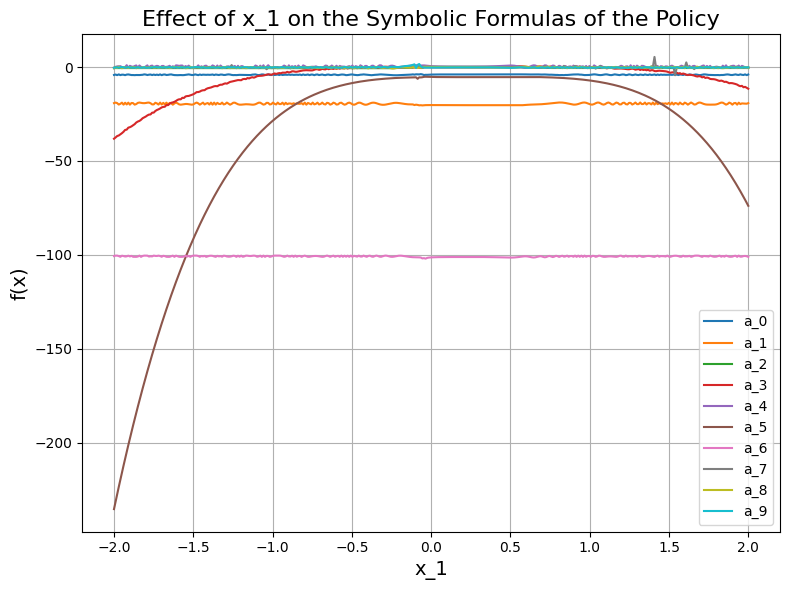

In [22]:
import matplotlib.pyplot as plt


# Example list of 10 formulas, each involving the 10 variables
# formulas = [
#     0.5*x_symbols[0] + 0.3*x_symbols[1]**2 - 0.2*x_symbols[2] + 0.1*x_symbols[3]**2,
#     exp(0.5*x_symbols[4]) - 0.8*sin(x_symbols[5]) + 0.3*cos(x_symbols[6]),
#     log(x_symbols[7] + 2) + sqrt(abs(x_symbols[8])) - 0.4*x_symbols[9],
#     0.2*x_symbols[0]**3 - 0.3*sin(x_symbols[1]) + 0.7*x_symbols[2]**2 + cos(x_symbols[3]),
#     sinh(x_symbols[4]) - cosh(x_symbols[5]) + 0.5*x_symbols[6]**2,
#     tan(x_symbols[7]) + 0.1*log(x_symbols[8] + 1) - 0.2*x_symbols[9]**2,
#     exp(-0.5*x_symbols[0]) + 0.3*x_symbols[1]**3 - 0.7*x_symbols[2] + sqrt(x_symbols[3] + 4),
#     0.4*sin(x_symbols[4]) + 0.6*cos(x_symbols[5] + x_symbols[6]**2) - 0.2*tan(x_symbols[7]),
#     log(x_symbols[8] + 3) + exp(x_symbols[9]) - 0.1*x_symbols[0] + 0.3*x_symbols[1],
#     sinh(x_symbols[2]) + cosh(x_symbols[3] - 1) - sin(x_symbols[4]) + 0.5*x_symbols[5]**2
# ]

# Generate values for x_1 (the variable to be varied)
x_values = np.linspace(-2, 2, 400)  # Values for the variable being varied
fixed_values = [0] * 63  # Initial fixed values for the other variables

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate through each formula
for i, formula in enumerate(formulas):
    # Lambdify the current formula with all 64 variables
    f = lambdify([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20,
                  x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34, x_35, x_36, x_37, x_38,
                  x_39, x_40, x_41, x_42, x_43, x_44, x_45, x_46, x_47, x_48, x_49, x_50, x_51, x_52, x_53, x_54, x_55, x_56,
                  x_57, x_58, x_59, x_60, x_61, x_62, x_63, x_64], formula, "numpy")

    # Compute y values for varying x_1
    y_values = [f(val, *fixed_values) for val in x_values]

    # Plot the function corresponding to the i-th formula
    ax.plot(x_values, y_values, label=f"a_{i}")

ax.set_xlabel('x_1', fontsize=14)
ax.set_ylabel('f(x)', fontsize=14)
ax.set_title('Effect of x_1 on the Symbolic Formulas of the Policy', fontsize=16)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig('10_formulas_plot.png', dpi=300)
plt.show()

https://daniel-bethell.co.uk/posts/mccp/

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Paper codes